# Project 2 Notebook # 


### Part 1: Training Model with SGD  ### 

In [2]:
import autograd.numpy as ag_np
import numpy as np
import pandas as pd
import os

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline


# %pip install autograd 

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

from CollabFilterOneVectorPerItem import CollabFilterOneVectorPerItem
from train_valid_test_loader import load_train_valid_test_datasets

DATA_DIR = './data_movie_lens_100k'
 

In [8]:
train_tuple, valid_tuple, test_tuple, n_users, n_items = load_train_valid_test_datasets()
print(train_tuple)

(array([662, 298,  90, ..., 574, 757, 503]), array([761,  90, 349, ..., 505, 472, 204]), array([5, 4, 4, ..., 2, 5, 3]))


In [11]:
# running 3 different k's 25 LOOPS
train_tuple, valid_tuple, test_tuple, n_users, n_items = load_train_valid_test_datasets()

# Hyperparameters
n_epochs = 25
batch_size = 64
step_size = 0.1
k_vals = [2, 10, 50]
alpha = 0.0  # No regularization

all_results = []
best_results = []

for k in k_vals:
    print(f"\nTraining model with k = {k}, alpha = {alpha}")
    model = CollabFilterOneVectorPerItem(
        n_epochs=n_epochs,
        batch_size=batch_size,
        step_size=step_size,
        n_factors=k,
        alpha=alpha,
    )
    model.init_parameter_dict(n_users, n_items, train_tuple)

    best_mae_valid = float('inf')
    best_epoch = 0
    best_params = None

    for epoch in range(n_epochs):
        # Train the model for one epoch
        model.fit(train_tuple, valid_tuple)

        # Validation metrics
        user_id_valid, item_id_valid, y_valid = valid_tuple
        y_pred_valid = model.predict(user_id_valid, item_id_valid)
#         mse_valid = ag_np.mean((y_pred_valid - y_valid) ** 2)
        mae_valid = ag_np.mean(ag_np.abs(y_pred_valid - y_valid))
        params = model.param_dict.copy()
        
#         use mae instead of mae
        if mae_valid < best_mae_valid:
            best_mae_valid = mae_valid
            best_epoch = epoch
            best_params = params

        print(f"Epoch {epoch + 1}/{n_epochs} - Validation MAE: {mae_valid:.4f}")
        
        all_results.append({        
            "k": k,
            "alpha": alpha,
            "mae_valid": mae_valid,
            "epoch": epoch})
        
        print("ALL RESULTS: ", all_results)

    # Load the best parameters
    model.param_dict = best_params

    # Compute final MAE metrics
    user_id_test, item_id_test, y_test = test_tuple
    y_pred_test = model.predict(user_id_test, item_id_test)
    mae_test = ag_np.mean(ag_np.abs(y_pred_test - y_test))

    mae_valid = ag_np.mean(ag_np.abs(model.predict(user_id_valid, item_id_valid) - y_valid))
    
    # Save best results
    best_results.append({
        "k": k,
        "alpha": alpha,
        "mae_valid": mae_valid,
        "mae_test": mae_test,
        "best_epoch": best_epoch,
        "params": best_params
    })

    print(f"Results for k={k}, alpha={alpha}:")
    print(f"  Best epoch: {best_epoch}")
    print(f"  Validation MAE: {mae_valid:.4f}")
    print(f"  Test MAE: {mae_test:.4f}")

# Final results summary
for res in best_results:
    print(f"k={res['k']}, Validation MAE={res['mae_valid']:.4f}, Test MAE={res['mae_test']:.4f}")



Training model with k = 2, alpha = 0.0
epoch       0.000 | loss_total     0.19604 | train_MAE     3.53059 | valid_MAE     3.54504 | grad_wrt_mu     0.10498 | grad_wrt_b_per_user     0.00011 | grad_wrt_c_per_item     0.00006 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.001 | loss_total     0.20176 | train_MAE     3.52005 | valid_MAE     3.53450 | grad_wrt_mu     0.10660 | grad_wrt_b_per_user     0.00011 | grad_wrt_c_per_item     0.00006 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.002 | loss_total     0.20743 | train_MAE     3.50935 | valid_MAE     3.52380 | grad_wrt_mu     0.10725 | grad_wrt_b_per_user     0.00011 | grad_wrt_c_per_item     0.00006 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.003 | loss_total     0.22660 | train_MAE     3.49859 | valid_MAE     3.51304 | grad_wrt_mu     0.11277 | grad_wrt_b_per_user     0.00012 | grad_wrt_c_per_item     0.00007 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.125 | 

epoch      12.000 | loss_total     0.01883 | train_MAE     0.92004 | valid_MAE     0.92235 | grad_wrt_mu     0.00013 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      13.000 | loss_total     0.01876 | train_MAE     0.91759 | valid_MAE     0.92000 | grad_wrt_mu     0.00548 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      14.000 | loss_total     0.01868 | train_MAE     0.91511 | valid_MAE     0.91764 | grad_wrt_mu     0.00609 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      15.000 | loss_total     0.01861 | train_MAE     0.91365 | valid_MAE     0.91636 | grad_wrt_mu     0.00205 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      16.000 | loss_total     0.01855 | train_MAE     0

epoch       3.000 | loss_total     0.01784 | train_MAE     0.89240 | valid_MAE     0.89699 | grad_wrt_mu     0.00133 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       3.500 | loss_total     0.01789 | train_MAE     0.89185 | valid_MAE     0.89653 | grad_wrt_mu     0.00297 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       4.000 | loss_total     0.01779 | train_MAE     0.89050 | valid_MAE     0.89519 | grad_wrt_mu     0.00007 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       4.500 | loss_total     0.01770 | train_MAE     0.89029 | valid_MAE     0.89508 | grad_wrt_mu     0.00032 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       5.000 | loss_total     0.01775 | train_MAE     0

epoch       0.500 | loss_total     0.01934 | train_MAE     0.86150 | valid_MAE     0.86852 | grad_wrt_mu     0.00461 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.625 | loss_total     0.01966 | train_MAE     0.86107 | valid_MAE     0.86807 | grad_wrt_mu     0.00143 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.751 | loss_total     0.01676 | train_MAE     0.86035 | valid_MAE     0.86732 | grad_wrt_mu     0.00968 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.876 | loss_total     0.01636 | train_MAE     0.86032 | valid_MAE     0.86731 | grad_wrt_mu     0.00443 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.000 | loss_total     0.01679 | train_MAE     0

epoch      19.000 | loss_total     0.01636 | train_MAE     0.84126 | valid_MAE     0.84963 | grad_wrt_mu     0.00090 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      20.000 | loss_total     0.01633 | train_MAE     0.84000 | valid_MAE     0.84840 | grad_wrt_mu     0.00129 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      21.000 | loss_total     0.01630 | train_MAE     0.83900 | valid_MAE     0.84747 | grad_wrt_mu     0.00091 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      22.000 | loss_total     0.01628 | train_MAE     0.83783 | valid_MAE     0.84634 | grad_wrt_mu     0.00070 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      23.000 | loss_total     0.01625 | train_MAE     0

epoch       6.000 | loss_total     0.01607 | train_MAE     0.82999 | valid_MAE     0.83907 | grad_wrt_mu     0.00854 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       6.500 | loss_total     0.01607 | train_MAE     0.82956 | valid_MAE     0.83868 | grad_wrt_mu     0.00700 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       7.000 | loss_total     0.01605 | train_MAE     0.82943 | valid_MAE     0.83860 | grad_wrt_mu     0.00058 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       7.500 | loss_total     0.01594 | train_MAE     0.82878 | valid_MAE     0.83796 | grad_wrt_mu     0.00273 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       8.000 | loss_total     0.01603 | train_MAE     0

epoch       1.251 | loss_total     0.01214 | train_MAE     0.81530 | valid_MAE     0.82553 | grad_wrt_mu     0.00262 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.376 | loss_total     0.01502 | train_MAE     0.81528 | valid_MAE     0.82552 | grad_wrt_mu     0.00129 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.500 | loss_total     0.01740 | train_MAE     0.81546 | valid_MAE     0.82575 | grad_wrt_mu     0.00172 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.625 | loss_total     0.01846 | train_MAE     0.81552 | valid_MAE     0.82582 | grad_wrt_mu     0.00352 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.751 | loss_total     0.01888 | train_MAE     0

epoch      24.999 | loss_total     0.01535 | train_MAE     0.80213 | valid_MAE     0.81337 | grad_wrt_mu     0.00220 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
Epoch 5/25 - Validation MSE: 1.1578
ALL RESULTS:  [{'k': 2, 'alpha': 0.0, 'mae_valid': 0.9008051680601037, 'epoch': 0}, {'k': 2, 'alpha': 0.0, 'mae_valid': 0.8683620052373315, 'epoch': 1}, {'k': 2, 'alpha': 0.0, 'mae_valid': 0.8446346182456719, 'epoch': 2}, {'k': 2, 'alpha': 0.0, 'mae_valid': 0.8264956443634125, 'epoch': 3}, {'k': 2, 'alpha': 0.0, 'mae_valid': 0.813396015212506, 'epoch': 4}]
epoch       0.000 | loss_total     0.01907 | train_MAE     0.80215 | valid_MAE     0.81340 | grad_wrt_mu     0.00234 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.001 | loss_total     0.01561 | train_MAE     0.80217 | valid_MAE     0.81342 | grad_wrt_mu     0.00106 | grad_wrt_b_per_u

epoch      10.000 | loss_total     0.01523 | train_MAE     0.79757 | valid_MAE     0.80922 | grad_wrt_mu     0.00079 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      11.000 | loss_total     0.01522 | train_MAE     0.79693 | valid_MAE     0.80858 | grad_wrt_mu     0.00501 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      12.000 | loss_total     0.01520 | train_MAE     0.79754 | valid_MAE     0.80938 | grad_wrt_mu     0.00103 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      13.000 | loss_total     0.01519 | train_MAE     0.79660 | valid_MAE     0.80840 | grad_wrt_mu     0.00019 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      14.000 | loss_total     0.01518 | train_MAE     0

epoch       1.751 | loss_total     0.01384 | train_MAE     0.79105 | valid_MAE     0.80338 | grad_wrt_mu     0.00789 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.876 | loss_total     0.01654 | train_MAE     0.79100 | valid_MAE     0.80333 | grad_wrt_mu     0.00042 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       2.000 | loss_total     0.01619 | train_MAE     0.79090 | valid_MAE     0.80323 | grad_wrt_mu     0.00054 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       2.500 | loss_total     0.01508 | train_MAE     0.79060 | valid_MAE     0.80293 | grad_wrt_mu     0.00080 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       3.000 | loss_total     0.01503 | train_MAE     0

epoch       0.251 | loss_total     0.01282 | train_MAE     0.78358 | valid_MAE     0.79684 | grad_wrt_mu     0.00147 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.376 | loss_total     0.01990 | train_MAE     0.78301 | valid_MAE     0.79620 | grad_wrt_mu     0.00419 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.500 | loss_total     0.01193 | train_MAE     0.78343 | valid_MAE     0.79670 | grad_wrt_mu     0.00392 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.625 | loss_total     0.01191 | train_MAE     0.78310 | valid_MAE     0.79632 | grad_wrt_mu     0.00352 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.751 | loss_total     0.01472 | train_MAE     0

epoch      17.000 | loss_total     0.01471 | train_MAE     0.77860 | valid_MAE     0.79237 | grad_wrt_mu     0.00092 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      18.000 | loss_total     0.01471 | train_MAE     0.77836 | valid_MAE     0.79217 | grad_wrt_mu     0.00213 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      19.000 | loss_total     0.01470 | train_MAE     0.77846 | valid_MAE     0.79235 | grad_wrt_mu     0.00266 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      20.000 | loss_total     0.01469 | train_MAE     0.77803 | valid_MAE     0.79193 | grad_wrt_mu     0.00130 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      21.000 | loss_total     0.01468 | train_MAE     0

epoch       4.500 | loss_total     0.01463 | train_MAE     0.77540 | valid_MAE     0.78954 | grad_wrt_mu     0.00174 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       5.000 | loss_total     0.01462 | train_MAE     0.77586 | valid_MAE     0.79011 | grad_wrt_mu     0.00043 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       5.500 | loss_total     0.01458 | train_MAE     0.77575 | valid_MAE     0.79002 | grad_wrt_mu     0.00310 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       6.000 | loss_total     0.01462 | train_MAE     0.77571 | valid_MAE     0.79001 | grad_wrt_mu     0.00043 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       6.500 | loss_total     0.01465 | train_MAE     0

epoch       0.751 | loss_total     0.01808 | train_MAE     0.77103 | valid_MAE     0.78582 | grad_wrt_mu     0.00191 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.876 | loss_total     0.01277 | train_MAE     0.77116 | valid_MAE     0.78598 | grad_wrt_mu     0.00292 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.000 | loss_total     0.01638 | train_MAE     0.77142 | valid_MAE     0.78629 | grad_wrt_mu     0.00357 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.125 | loss_total     0.01383 | train_MAE     0.77148 | valid_MAE     0.78636 | grad_wrt_mu     0.00303 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.251 | loss_total     0.01521 | train_MAE     0

epoch      21.000 | loss_total     0.01440 | train_MAE     0.76726 | valid_MAE     0.78257 | grad_wrt_mu     0.00694 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      22.000 | loss_total     0.01439 | train_MAE     0.76697 | valid_MAE     0.78229 | grad_wrt_mu     0.00066 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      23.000 | loss_total     0.01440 | train_MAE     0.76721 | valid_MAE     0.78264 | grad_wrt_mu     0.00338 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      24.000 | loss_total     0.01438 | train_MAE     0.76756 | valid_MAE     0.78310 | grad_wrt_mu     0.00372 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      24.999 | loss_total     0.01438 | train_MAE     0

epoch       6.000 | loss_total     0.01435 | train_MAE     0.76642 | valid_MAE     0.78215 | grad_wrt_mu     0.00687 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       6.500 | loss_total     0.01447 | train_MAE     0.76575 | valid_MAE     0.78139 | grad_wrt_mu     0.00156 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       7.000 | loss_total     0.01435 | train_MAE     0.76586 | valid_MAE     0.78155 | grad_wrt_mu     0.00097 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       7.500 | loss_total     0.01429 | train_MAE     0.76548 | valid_MAE     0.78112 | grad_wrt_mu     0.00959 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       8.000 | loss_total     0.01435 | train_MAE     0

epoch       1.000 | loss_total     0.02043 | train_MAE     0.76361 | valid_MAE     0.77988 | grad_wrt_mu     0.00230 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.125 | loss_total     0.01049 | train_MAE     0.76306 | valid_MAE     0.77923 | grad_wrt_mu     0.00466 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.251 | loss_total     0.01822 | train_MAE     0.76290 | valid_MAE     0.77904 | grad_wrt_mu     0.00061 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.376 | loss_total     0.01655 | train_MAE     0.76309 | valid_MAE     0.77929 | grad_wrt_mu     0.00043 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.500 | loss_total     0.01359 | train_MAE     0

epoch      23.000 | loss_total     0.01419 | train_MAE     0.75991 | valid_MAE     0.77653 | grad_wrt_mu     0.00473 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      24.000 | loss_total     0.01418 | train_MAE     0.76000 | valid_MAE     0.77670 | grad_wrt_mu     0.00358 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      24.999 | loss_total     0.01417 | train_MAE     0.75962 | valid_MAE     0.77627 | grad_wrt_mu     0.00204 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
Epoch 12/25 - Validation MSE: 1.1578
ALL RESULTS:  [{'k': 2, 'alpha': 0.0, 'mae_valid': 0.9008051680601037, 'epoch': 0}, {'k': 2, 'alpha': 0.0, 'mae_valid': 0.8683620052373315, 'epoch': 1}, {'k': 2, 'alpha': 0.0, 'mae_valid': 0.8446346182456719, 'epoch': 2}, {'k': 2, 'alpha': 0.0, 'mae_valid': 

epoch       7.000 | loss_total     0.01415 | train_MAE     0.75908 | valid_MAE     0.77595 | grad_wrt_mu     0.00028 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       7.500 | loss_total     0.01421 | train_MAE     0.75878 | valid_MAE     0.77560 | grad_wrt_mu     0.00329 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       8.000 | loss_total     0.01415 | train_MAE     0.75900 | valid_MAE     0.77591 | grad_wrt_mu     0.01000 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       9.000 | loss_total     0.01414 | train_MAE     0.75847 | valid_MAE     0.77531 | grad_wrt_mu     0.00452 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      10.000 | loss_total     0.01414 | train_MAE     0

epoch       1.000 | loss_total     0.01414 | train_MAE     0.75670 | valid_MAE     0.77392 | grad_wrt_mu     0.00315 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.125 | loss_total     0.01615 | train_MAE     0.75648 | valid_MAE     0.77365 | grad_wrt_mu     0.00570 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.251 | loss_total     0.01412 | train_MAE     0.75662 | valid_MAE     0.77383 | grad_wrt_mu     0.00060 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.376 | loss_total     0.01289 | train_MAE     0.75660 | valid_MAE     0.77381 | grad_wrt_mu     0.00362 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.500 | loss_total     0.01090 | train_MAE     0

epoch      23.000 | loss_total     0.01402 | train_MAE     0.75462 | valid_MAE     0.77233 | grad_wrt_mu     0.00271 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      24.000 | loss_total     0.01403 | train_MAE     0.75445 | valid_MAE     0.77217 | grad_wrt_mu     0.00120 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      24.999 | loss_total     0.01402 | train_MAE     0.75450 | valid_MAE     0.77227 | grad_wrt_mu     0.00454 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
Epoch 14/25 - Validation MSE: 1.1578
ALL RESULTS:  [{'k': 2, 'alpha': 0.0, 'mae_valid': 0.9008051680601037, 'epoch': 0}, {'k': 2, 'alpha': 0.0, 'mae_valid': 0.8683620052373315, 'epoch': 1}, {'k': 2, 'alpha': 0.0, 'mae_valid': 0.8446346182456719, 'epoch': 2}, {'k': 2, 'alpha': 0.0, 'mae_valid': 

epoch       6.500 | loss_total     0.01387 | train_MAE     0.75357 | valid_MAE     0.77140 | grad_wrt_mu     0.00081 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       7.000 | loss_total     0.01399 | train_MAE     0.75411 | valid_MAE     0.77209 | grad_wrt_mu     0.00717 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       7.500 | loss_total     0.01410 | train_MAE     0.75416 | valid_MAE     0.77218 | grad_wrt_mu     0.00014 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       8.000 | loss_total     0.01400 | train_MAE     0.75347 | valid_MAE     0.77134 | grad_wrt_mu     0.00226 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       9.000 | loss_total     0.01399 | train_MAE     0

epoch       0.876 | loss_total     0.01241 | train_MAE     0.75230 | valid_MAE     0.77062 | grad_wrt_mu     0.00813 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.000 | loss_total     0.01342 | train_MAE     0.75215 | valid_MAE     0.77043 | grad_wrt_mu     0.00072 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.125 | loss_total     0.01158 | train_MAE     0.75168 | valid_MAE     0.76985 | grad_wrt_mu     0.00096 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.251 | loss_total     0.01404 | train_MAE     0.75207 | valid_MAE     0.77035 | grad_wrt_mu     0.00709 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.376 | loss_total     0.01439 | train_MAE     0

epoch      22.000 | loss_total     0.01390 | train_MAE     0.75062 | valid_MAE     0.76934 | grad_wrt_mu     0.00272 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      23.000 | loss_total     0.01390 | train_MAE     0.75059 | valid_MAE     0.76934 | grad_wrt_mu     0.00246 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      24.000 | loss_total     0.01390 | train_MAE     0.75057 | valid_MAE     0.76936 | grad_wrt_mu     0.00306 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      24.999 | loss_total     0.01389 | train_MAE     0.75009 | valid_MAE     0.76877 | grad_wrt_mu     0.00536 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
Epoch 16/25 - Validation MSE: 1.1578
ALL RESULTS:  [{'k': 2,

epoch       5.500 | loss_total     0.01390 | train_MAE     0.74969 | valid_MAE     0.76848 | grad_wrt_mu     0.00004 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       6.000 | loss_total     0.01388 | train_MAE     0.74999 | valid_MAE     0.76888 | grad_wrt_mu     0.00148 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       6.500 | loss_total     0.01393 | train_MAE     0.75034 | valid_MAE     0.76934 | grad_wrt_mu     0.00518 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       7.000 | loss_total     0.01388 | train_MAE     0.74947 | valid_MAE     0.76824 | grad_wrt_mu     0.00585 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       7.500 | loss_total     0.01387 | train_MAE     0

epoch       0.500 | loss_total     0.01373 | train_MAE     0.74841 | valid_MAE     0.76756 | grad_wrt_mu     0.00431 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.625 | loss_total     0.01005 | train_MAE     0.74857 | valid_MAE     0.76777 | grad_wrt_mu     0.00273 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.751 | loss_total     0.01915 | train_MAE     0.74848 | valid_MAE     0.76766 | grad_wrt_mu     0.00017 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.876 | loss_total     0.00778 | train_MAE     0.74843 | valid_MAE     0.76760 | grad_wrt_mu     0.00173 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.000 | loss_total     0.01534 | train_MAE     0

epoch      19.000 | loss_total     0.01380 | train_MAE     0.74754 | valid_MAE     0.76707 | grad_wrt_mu     0.00144 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      20.000 | loss_total     0.01380 | train_MAE     0.74742 | valid_MAE     0.76695 | grad_wrt_mu     0.00827 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      21.000 | loss_total     0.01380 | train_MAE     0.74741 | valid_MAE     0.76697 | grad_wrt_mu     0.00077 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      22.000 | loss_total     0.01379 | train_MAE     0.74716 | valid_MAE     0.76669 | grad_wrt_mu     0.00098 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      23.000 | loss_total     0.01379 | train_MAE     0

epoch       4.000 | loss_total     0.01378 | train_MAE     0.74646 | valid_MAE     0.76603 | grad_wrt_mu     0.00121 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       4.500 | loss_total     0.01380 | train_MAE     0.74668 | valid_MAE     0.76631 | grad_wrt_mu     0.00075 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       5.000 | loss_total     0.01378 | train_MAE     0.74645 | valid_MAE     0.76605 | grad_wrt_mu     0.00088 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       5.500 | loss_total     0.01367 | train_MAE     0.74620 | valid_MAE     0.76575 | grad_wrt_mu     0.00210 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       6.000 | loss_total     0.01378 | train_MAE     0

epoch       0.125 | loss_total     0.01183 | train_MAE     0.74540 | valid_MAE     0.76534 | grad_wrt_mu     0.00147 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.251 | loss_total     0.01376 | train_MAE     0.74527 | valid_MAE     0.76517 | grad_wrt_mu     0.00328 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.376 | loss_total     0.01240 | train_MAE     0.74547 | valid_MAE     0.76542 | grad_wrt_mu     0.00108 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.500 | loss_total     0.01753 | train_MAE     0.74588 | valid_MAE     0.76593 | grad_wrt_mu     0.00577 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.625 | loss_total     0.01730 | train_MAE     0

epoch      16.000 | loss_total     0.01372 | train_MAE     0.74459 | valid_MAE     0.76477 | grad_wrt_mu     0.00150 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      17.000 | loss_total     0.01372 | train_MAE     0.74432 | valid_MAE     0.76446 | grad_wrt_mu     0.00107 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      18.000 | loss_total     0.01371 | train_MAE     0.74428 | valid_MAE     0.76443 | grad_wrt_mu     0.00499 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      19.000 | loss_total     0.01371 | train_MAE     0.74487 | valid_MAE     0.76519 | grad_wrt_mu     0.00019 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      20.000 | loss_total     0.01371 | train_MAE     0

epoch       2.500 | loss_total     0.01363 | train_MAE     0.74414 | valid_MAE     0.76452 | grad_wrt_mu     0.00159 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       3.000 | loss_total     0.01370 | train_MAE     0.74384 | valid_MAE     0.76416 | grad_wrt_mu     0.00426 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       3.500 | loss_total     0.01375 | train_MAE     0.74390 | valid_MAE     0.76425 | grad_wrt_mu     0.00582 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       4.000 | loss_total     0.01370 | train_MAE     0.74413 | valid_MAE     0.76454 | grad_wrt_mu     0.00031 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       4.500 | loss_total     0.01376 | train_MAE     0

epoch       0.125 | loss_total     0.01355 | train_MAE     0.74238 | valid_MAE     0.76290 | grad_wrt_mu     0.00581 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.251 | loss_total     0.01851 | train_MAE     0.74251 | valid_MAE     0.76307 | grad_wrt_mu     0.00854 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.376 | loss_total     0.01402 | train_MAE     0.74312 | valid_MAE     0.76383 | grad_wrt_mu     0.00447 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.500 | loss_total     0.01151 | train_MAE     0.74304 | valid_MAE     0.76373 | grad_wrt_mu     0.00791 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.625 | loss_total     0.01348 | train_MAE     0

epoch      16.000 | loss_total     0.01364 | train_MAE     0.74251 | valid_MAE     0.76345 | grad_wrt_mu     0.00181 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      17.000 | loss_total     0.01364 | train_MAE     0.74187 | valid_MAE     0.76267 | grad_wrt_mu     0.00472 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      18.000 | loss_total     0.01363 | train_MAE     0.74217 | valid_MAE     0.76307 | grad_wrt_mu     0.00087 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      19.000 | loss_total     0.01364 | train_MAE     0.74219 | valid_MAE     0.76312 | grad_wrt_mu     0.00462 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      20.000 | loss_total     0.01364 | train_MAE     0

epoch       2.500 | loss_total     0.01364 | train_MAE     0.74121 | valid_MAE     0.76210 | grad_wrt_mu     0.00456 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       3.000 | loss_total     0.01362 | train_MAE     0.74153 | valid_MAE     0.76251 | grad_wrt_mu     0.00687 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       3.500 | loss_total     0.01358 | train_MAE     0.74154 | valid_MAE     0.76252 | grad_wrt_mu     0.00136 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       4.000 | loss_total     0.01363 | train_MAE     0.74208 | valid_MAE     0.76322 | grad_wrt_mu     0.00372 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       4.500 | loss_total     0.01357 | train_MAE     0

epoch       0.125 | loss_total     0.01482 | train_MAE     0.74074 | valid_MAE     0.76202 | grad_wrt_mu     0.00429 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.251 | loss_total     0.00949 | train_MAE     0.74047 | valid_MAE     0.76169 | grad_wrt_mu     0.00047 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.376 | loss_total     0.01082 | train_MAE     0.74054 | valid_MAE     0.76177 | grad_wrt_mu     0.00604 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.500 | loss_total     0.01458 | train_MAE     0.74063 | valid_MAE     0.76190 | grad_wrt_mu     0.00575 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.625 | loss_total     0.00976 | train_MAE     0

epoch      16.000 | loss_total     0.01358 | train_MAE     0.73987 | valid_MAE     0.76128 | grad_wrt_mu     0.00110 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      17.000 | loss_total     0.01358 | train_MAE     0.73998 | valid_MAE     0.76143 | grad_wrt_mu     0.00057 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      18.000 | loss_total     0.01358 | train_MAE     0.74027 | valid_MAE     0.76183 | grad_wrt_mu     0.00385 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      19.000 | loss_total     0.01358 | train_MAE     0.73990 | valid_MAE     0.76138 | grad_wrt_mu     0.00069 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      20.000 | loss_total     0.01357 | train_MAE     0

epoch       2.000 | loss_total     0.01488 | train_MAE     0.73926 | valid_MAE     0.76075 | grad_wrt_mu     0.00307 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       2.500 | loss_total     0.01355 | train_MAE     0.73956 | valid_MAE     0.76114 | grad_wrt_mu     0.00095 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       3.000 | loss_total     0.01356 | train_MAE     0.73958 | valid_MAE     0.76117 | grad_wrt_mu     0.00191 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       3.500 | loss_total     0.01353 | train_MAE     0.73964 | valid_MAE     0.76125 | grad_wrt_mu     0.00191 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       4.000 | loss_total     0.01356 | train_MAE     0

epoch       0.125 | loss_total     0.10747 | train_MAE     2.32472 | valid_MAE     2.33789 | grad_wrt_mu     0.07422 | grad_wrt_b_per_user     0.00008 | grad_wrt_c_per_item     0.00004 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.251 | loss_total     0.05066 | train_MAE     1.63168 | valid_MAE     1.64046 | grad_wrt_mu     0.04683 | grad_wrt_b_per_user     0.00005 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.376 | loss_total     0.03693 | train_MAE     1.29577 | valid_MAE     1.30281 | grad_wrt_mu     0.03268 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.500 | loss_total     0.02958 | train_MAE     1.07296 | valid_MAE     1.07884 | grad_wrt_mu     0.02054 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.625 | loss_total     0.02240 | train_MAE     0

epoch      16.000 | loss_total     0.01855 | train_MAE     0.91232 | valid_MAE     0.91522 | grad_wrt_mu     0.00249 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      17.000 | loss_total     0.01848 | train_MAE     0.91015 | valid_MAE     0.91317 | grad_wrt_mu     0.00284 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      18.000 | loss_total     0.01841 | train_MAE     0.90916 | valid_MAE     0.91241 | grad_wrt_mu     0.00298 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      19.000 | loss_total     0.01836 | train_MAE     0.90648 | valid_MAE     0.90979 | grad_wrt_mu     0.00282 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      20.000 | loss_total     0.01829 | train_MAE     0

epoch       1.751 | loss_total     0.01879 | train_MAE     0.89374 | valid_MAE     0.89811 | grad_wrt_mu     0.00116 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.876 | loss_total     0.01805 | train_MAE     0.89404 | valid_MAE     0.89847 | grad_wrt_mu     0.00328 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       2.000 | loss_total     0.01982 | train_MAE     0.89397 | valid_MAE     0.89843 | grad_wrt_mu     0.00011 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       2.500 | loss_total     0.01787 | train_MAE     0.89347 | valid_MAE     0.89801 | grad_wrt_mu     0.00037 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       3.000 | loss_total     0.01785 | train_MAE     0

epoch       0.125 | loss_total     0.01930 | train_MAE     0.86139 | valid_MAE     0.86831 | grad_wrt_mu     0.00078 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.251 | loss_total     0.01639 | train_MAE     0.86147 | valid_MAE     0.86842 | grad_wrt_mu     0.00243 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.376 | loss_total     0.01755 | train_MAE     0.86138 | valid_MAE     0.86835 | grad_wrt_mu     0.00172 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.500 | loss_total     0.02031 | train_MAE     0.86113 | valid_MAE     0.86810 | grad_wrt_mu     0.00303 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.625 | loss_total     0.01163 | train_MAE     0

epoch      16.000 | loss_total     0.01644 | train_MAE     0.84403 | valid_MAE     0.85218 | grad_wrt_mu     0.00693 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      17.000 | loss_total     0.01640 | train_MAE     0.84246 | valid_MAE     0.85063 | grad_wrt_mu     0.00494 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      18.000 | loss_total     0.01638 | train_MAE     0.84193 | valid_MAE     0.85020 | grad_wrt_mu     0.00302 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      19.000 | loss_total     0.01635 | train_MAE     0.84051 | valid_MAE     0.84881 | grad_wrt_mu     0.00578 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      20.000 | loss_total     0.01633 | train_MAE     0

epoch       1.751 | loss_total     0.01969 | train_MAE     0.83389 | valid_MAE     0.84271 | grad_wrt_mu     0.00077 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.876 | loss_total     0.01998 | train_MAE     0.83337 | valid_MAE     0.84217 | grad_wrt_mu     0.00314 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       2.000 | loss_total     0.01277 | train_MAE     0.83310 | valid_MAE     0.84190 | grad_wrt_mu     0.00383 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       2.500 | loss_total     0.01609 | train_MAE     0.83253 | valid_MAE     0.84134 | grad_wrt_mu     0.00185 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       3.000 | loss_total     0.01614 | train_MAE     0

epoch       0.125 | loss_total     0.01286 | train_MAE     0.81684 | valid_MAE     0.82710 | grad_wrt_mu     0.00212 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.251 | loss_total     0.01090 | train_MAE     0.81697 | valid_MAE     0.82726 | grad_wrt_mu     0.00192 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.376 | loss_total     0.01788 | train_MAE     0.81674 | valid_MAE     0.82703 | grad_wrt_mu     0.00249 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.500 | loss_total     0.01388 | train_MAE     0.81619 | valid_MAE     0.82643 | grad_wrt_mu     0.00601 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.625 | loss_total     0.02065 | train_MAE     0

epoch      16.000 | loss_total     0.01547 | train_MAE     0.80698 | valid_MAE     0.81790 | grad_wrt_mu     0.00224 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      17.000 | loss_total     0.01545 | train_MAE     0.80620 | valid_MAE     0.81713 | grad_wrt_mu     0.00183 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      18.000 | loss_total     0.01544 | train_MAE     0.80604 | valid_MAE     0.81705 | grad_wrt_mu     0.00095 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      19.000 | loss_total     0.01542 | train_MAE     0.80435 | valid_MAE     0.81525 | grad_wrt_mu     0.00767 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      20.000 | loss_total     0.01541 | train_MAE     0

epoch       1.625 | loss_total     0.01634 | train_MAE     0.80125 | valid_MAE     0.81255 | grad_wrt_mu     0.00269 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.751 | loss_total     0.01818 | train_MAE     0.80123 | valid_MAE     0.81254 | grad_wrt_mu     0.00204 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.876 | loss_total     0.01300 | train_MAE     0.80170 | valid_MAE     0.81309 | grad_wrt_mu     0.00344 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       2.000 | loss_total     0.01521 | train_MAE     0.80123 | valid_MAE     0.81257 | grad_wrt_mu     0.00291 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       2.500 | loss_total     0.01530 | train_MAE     0

epoch       0.125 | loss_total     0.01609 | train_MAE     0.79153 | valid_MAE     0.80377 | grad_wrt_mu     0.00205 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.251 | loss_total     0.01554 | train_MAE     0.79182 | valid_MAE     0.80412 | grad_wrt_mu     0.00318 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.376 | loss_total     0.01314 | train_MAE     0.79224 | valid_MAE     0.80461 | grad_wrt_mu     0.00029 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.500 | loss_total     0.02022 | train_MAE     0.79188 | valid_MAE     0.80421 | grad_wrt_mu     0.00871 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.625 | loss_total     0.01663 | train_MAE     0

epoch      16.000 | loss_total     0.01492 | train_MAE     0.78625 | valid_MAE     0.79915 | grad_wrt_mu     0.00183 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      17.000 | loss_total     0.01491 | train_MAE     0.78608 | valid_MAE     0.79903 | grad_wrt_mu     0.00657 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      18.000 | loss_total     0.01490 | train_MAE     0.78582 | valid_MAE     0.79882 | grad_wrt_mu     0.00320 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      19.000 | loss_total     0.01489 | train_MAE     0.78535 | valid_MAE     0.79836 | grad_wrt_mu     0.00594 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      20.000 | loss_total     0.01488 | train_MAE     0

epoch       1.625 | loss_total     0.01327 | train_MAE     0.78301 | valid_MAE     0.79630 | grad_wrt_mu     0.00331 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.751 | loss_total     0.01535 | train_MAE     0.78228 | valid_MAE     0.79546 | grad_wrt_mu     0.00471 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.876 | loss_total     0.01460 | train_MAE     0.78257 | valid_MAE     0.79581 | grad_wrt_mu     0.00662 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       2.000 | loss_total     0.01309 | train_MAE     0.78273 | valid_MAE     0.79601 | grad_wrt_mu     0.00068 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       2.500 | loss_total     0.01474 | train_MAE     0

epoch       0.125 | loss_total     0.01087 | train_MAE     0.77653 | valid_MAE     0.79055 | grad_wrt_mu     0.00214 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.251 | loss_total     0.01507 | train_MAE     0.77662 | valid_MAE     0.79066 | grad_wrt_mu     0.00126 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.376 | loss_total     0.02124 | train_MAE     0.77666 | valid_MAE     0.79072 | grad_wrt_mu     0.01015 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.500 | loss_total     0.01500 | train_MAE     0.77648 | valid_MAE     0.79052 | grad_wrt_mu     0.00098 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.625 | loss_total     0.01438 | train_MAE     0

epoch      16.000 | loss_total     0.01456 | train_MAE     0.77340 | valid_MAE     0.78798 | grad_wrt_mu     0.00707 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      17.000 | loss_total     0.01455 | train_MAE     0.77352 | valid_MAE     0.78818 | grad_wrt_mu     0.00049 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      18.000 | loss_total     0.01455 | train_MAE     0.77299 | valid_MAE     0.78763 | grad_wrt_mu     0.00328 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      19.000 | loss_total     0.01454 | train_MAE     0.77291 | valid_MAE     0.78760 | grad_wrt_mu     0.00563 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      20.000 | loss_total     0.01453 | train_MAE     0

epoch       1.500 | loss_total     0.01843 | train_MAE     0.77116 | valid_MAE     0.78602 | grad_wrt_mu     0.00009 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.625 | loss_total     0.01174 | train_MAE     0.77149 | valid_MAE     0.78641 | grad_wrt_mu     0.00322 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.751 | loss_total     0.01618 | train_MAE     0.77137 | valid_MAE     0.78627 | grad_wrt_mu     0.00112 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.876 | loss_total     0.01325 | train_MAE     0.77111 | valid_MAE     0.78598 | grad_wrt_mu     0.00275 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       2.000 | loss_total     0.01603 | train_MAE     0

epoch       0.125 | loss_total     0.01261 | train_MAE     0.76671 | valid_MAE     0.78215 | grad_wrt_mu     0.00424 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.251 | loss_total     0.01430 | train_MAE     0.76659 | valid_MAE     0.78203 | grad_wrt_mu     0.00169 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.376 | loss_total     0.01990 | train_MAE     0.76656 | valid_MAE     0.78200 | grad_wrt_mu     0.01170 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.500 | loss_total     0.01506 | train_MAE     0.76687 | valid_MAE     0.78237 | grad_wrt_mu     0.00108 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.625 | loss_total     0.01575 | train_MAE     0

epoch      16.000 | loss_total     0.01431 | train_MAE     0.76437 | valid_MAE     0.78026 | grad_wrt_mu     0.00201 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      17.000 | loss_total     0.01431 | train_MAE     0.76444 | valid_MAE     0.78040 | grad_wrt_mu     0.00433 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      18.000 | loss_total     0.01430 | train_MAE     0.76396 | valid_MAE     0.77988 | grad_wrt_mu     0.00686 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      19.000 | loss_total     0.01430 | train_MAE     0.76426 | valid_MAE     0.78029 | grad_wrt_mu     0.00170 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      20.000 | loss_total     0.01429 | train_MAE     0

epoch       1.376 | loss_total     0.01516 | train_MAE     0.76284 | valid_MAE     0.77898 | grad_wrt_mu     0.00041 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.500 | loss_total     0.01251 | train_MAE     0.76294 | valid_MAE     0.77911 | grad_wrt_mu     0.00581 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.625 | loss_total     0.01406 | train_MAE     0.76304 | valid_MAE     0.77924 | grad_wrt_mu     0.00321 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.751 | loss_total     0.01248 | train_MAE     0.76294 | valid_MAE     0.77913 | grad_wrt_mu     0.00038 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.876 | loss_total     0.00939 | train_MAE     0

epoch       0.125 | loss_total     0.01491 | train_MAE     0.75964 | valid_MAE     0.77630 | grad_wrt_mu     0.00230 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.251 | loss_total     0.01449 | train_MAE     0.75954 | valid_MAE     0.77618 | grad_wrt_mu     0.00306 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.376 | loss_total     0.01296 | train_MAE     0.75959 | valid_MAE     0.77626 | grad_wrt_mu     0.00059 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.500 | loss_total     0.01613 | train_MAE     0.75968 | valid_MAE     0.77637 | grad_wrt_mu     0.00380 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.625 | loss_total     0.01823 | train_MAE     0

epoch      16.000 | loss_total     0.01411 | train_MAE     0.75782 | valid_MAE     0.77484 | grad_wrt_mu     0.00061 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      17.000 | loss_total     0.01412 | train_MAE     0.75846 | valid_MAE     0.77568 | grad_wrt_mu     0.00352 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      18.000 | loss_total     0.01411 | train_MAE     0.75773 | valid_MAE     0.77482 | grad_wrt_mu     0.00014 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      19.000 | loss_total     0.01411 | train_MAE     0.75750 | valid_MAE     0.77458 | grad_wrt_mu     0.00357 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      20.000 | loss_total     0.01412 | train_MAE     0

epoch       1.376 | loss_total     0.01337 | train_MAE     0.75690 | valid_MAE     0.77419 | grad_wrt_mu     0.00578 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.500 | loss_total     0.00890 | train_MAE     0.75728 | valid_MAE     0.77467 | grad_wrt_mu     0.00074 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.625 | loss_total     0.01628 | train_MAE     0.75718 | valid_MAE     0.77455 | grad_wrt_mu     0.00053 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.751 | loss_total     0.00953 | train_MAE     0.75683 | valid_MAE     0.77412 | grad_wrt_mu     0.00323 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.876 | loss_total     0.01337 | train_MAE     0

epoch       0.125 | loss_total     0.01263 | train_MAE     0.75454 | valid_MAE     0.77232 | grad_wrt_mu     0.00166 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.251 | loss_total     0.01539 | train_MAE     0.75427 | valid_MAE     0.77200 | grad_wrt_mu     0.00867 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.376 | loss_total     0.01689 | train_MAE     0.75393 | valid_MAE     0.77158 | grad_wrt_mu     0.00185 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.500 | loss_total     0.01677 | train_MAE     0.75416 | valid_MAE     0.77187 | grad_wrt_mu     0.00096 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.625 | loss_total     0.01375 | train_MAE     0

epoch      16.000 | loss_total     0.01397 | train_MAE     0.75322 | valid_MAE     0.77137 | grad_wrt_mu     0.00072 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      17.000 | loss_total     0.01398 | train_MAE     0.75300 | valid_MAE     0.77113 | grad_wrt_mu     0.00253 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      18.000 | loss_total     0.01397 | train_MAE     0.75283 | valid_MAE     0.77097 | grad_wrt_mu     0.00589 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      19.000 | loss_total     0.01397 | train_MAE     0.75264 | valid_MAE     0.77077 | grad_wrt_mu     0.00133 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      20.000 | loss_total     0.01396 | train_MAE     0

epoch       1.251 | loss_total     0.01283 | train_MAE     0.75247 | valid_MAE     0.77084 | grad_wrt_mu     0.00064 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.376 | loss_total     0.01445 | train_MAE     0.75226 | valid_MAE     0.77058 | grad_wrt_mu     0.00121 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.500 | loss_total     0.00831 | train_MAE     0.75214 | valid_MAE     0.77044 | grad_wrt_mu     0.00647 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.625 | loss_total     0.01366 | train_MAE     0.75193 | valid_MAE     0.77019 | grad_wrt_mu     0.00081 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.751 | loss_total     0.01498 | train_MAE     0

epoch      24.999 | loss_total     0.01389 | train_MAE     0.75027 | valid_MAE     0.76900 | grad_wrt_mu     0.00409 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
Epoch 16/25 - Validation MSE: 1.1578
ALL RESULTS:  [{'k': 2, 'alpha': 0.0, 'mae_valid': 0.9008051680601037, 'epoch': 0}, {'k': 2, 'alpha': 0.0, 'mae_valid': 0.8683620052373315, 'epoch': 1}, {'k': 2, 'alpha': 0.0, 'mae_valid': 0.8446346182456719, 'epoch': 2}, {'k': 2, 'alpha': 0.0, 'mae_valid': 0.8264956443634125, 'epoch': 3}, {'k': 2, 'alpha': 0.0, 'mae_valid': 0.813396015212506, 'epoch': 4}, {'k': 2, 'alpha': 0.0, 'mae_valid': 0.8038196207978204, 'epoch': 5}, {'k': 2, 'alpha': 0.0, 'mae_valid': 0.7967661119191236, 'epoch': 6}, {'k': 2, 'alpha': 0.0, 'mae_valid': 0.7905062708907091, 'epoch': 7}, {'k': 2, 'alpha': 0.0, 'mae_valid': 0.786199277312832, 'epoch': 8}, {'k': 2, 'alpha': 0.0, 'mae_valid': 0.7828533499532465, 'epoch': 9}, {'k': 2, 'alpha': 0.0, 'm

epoch       3.500 | loss_total     0.01384 | train_MAE     0.75000 | valid_MAE     0.76880 | grad_wrt_mu     0.00420 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       4.000 | loss_total     0.01389 | train_MAE     0.74995 | valid_MAE     0.76875 | grad_wrt_mu     0.00464 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       4.500 | loss_total     0.01389 | train_MAE     0.74971 | valid_MAE     0.76847 | grad_wrt_mu     0.00116 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       5.000 | loss_total     0.01388 | train_MAE     0.74991 | valid_MAE     0.76874 | grad_wrt_mu     0.00035 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       5.500 | loss_total     0.01391 | train_MAE     0

epoch       0.125 | loss_total     0.01135 | train_MAE     0.74855 | valid_MAE     0.76772 | grad_wrt_mu     0.00119 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.251 | loss_total     0.01379 | train_MAE     0.74840 | valid_MAE     0.76753 | grad_wrt_mu     0.00366 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.376 | loss_total     0.01537 | train_MAE     0.74853 | valid_MAE     0.76771 | grad_wrt_mu     0.00352 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.500 | loss_total     0.01093 | train_MAE     0.74865 | valid_MAE     0.76786 | grad_wrt_mu     0.00162 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.625 | loss_total     0.01337 | train_MAE     0

epoch      16.000 | loss_total     0.01381 | train_MAE     0.74745 | valid_MAE     0.76685 | grad_wrt_mu     0.00099 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      17.000 | loss_total     0.01381 | train_MAE     0.74784 | valid_MAE     0.76738 | grad_wrt_mu     0.00233 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      18.000 | loss_total     0.01380 | train_MAE     0.74689 | valid_MAE     0.76620 | grad_wrt_mu     0.00412 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      19.000 | loss_total     0.01380 | train_MAE     0.74751 | valid_MAE     0.76703 | grad_wrt_mu     0.00001 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      20.000 | loss_total     0.01379 | train_MAE     0

epoch       1.125 | loss_total     0.01508 | train_MAE     0.74678 | valid_MAE     0.76633 | grad_wrt_mu     0.00195 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.251 | loss_total     0.01310 | train_MAE     0.74702 | valid_MAE     0.76664 | grad_wrt_mu     0.00191 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.376 | loss_total     0.01294 | train_MAE     0.74660 | valid_MAE     0.76611 | grad_wrt_mu     0.00188 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.500 | loss_total     0.01078 | train_MAE     0.74625 | valid_MAE     0.76567 | grad_wrt_mu     0.00330 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.625 | loss_total     0.01500 | train_MAE     0

epoch      24.000 | loss_total     0.01375 | train_MAE     0.74560 | valid_MAE     0.76555 | grad_wrt_mu     0.00050 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      24.999 | loss_total     0.01375 | train_MAE     0.74547 | valid_MAE     0.76542 | grad_wrt_mu     0.00827 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
Epoch 19/25 - Validation MSE: 1.1578
ALL RESULTS:  [{'k': 2, 'alpha': 0.0, 'mae_valid': 0.9008051680601037, 'epoch': 0}, {'k': 2, 'alpha': 0.0, 'mae_valid': 0.8683620052373315, 'epoch': 1}, {'k': 2, 'alpha': 0.0, 'mae_valid': 0.8446346182456719, 'epoch': 2}, {'k': 2, 'alpha': 0.0, 'mae_valid': 0.8264956443634125, 'epoch': 3}, {'k': 2, 'alpha': 0.0, 'mae_valid': 0.813396015212506, 'epoch': 4}, {'k': 2, 'alpha': 0.0, 'mae_valid': 0.8038196207978204, 'epoch': 5}, {'k': 2, 'alpha': 0.0, 'mae_valid': 0.7967661119191236, 'epoch': 

epoch       2.500 | loss_total     0.01369 | train_MAE     0.74512 | valid_MAE     0.76505 | grad_wrt_mu     0.00495 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       3.000 | loss_total     0.01375 | train_MAE     0.74542 | valid_MAE     0.76544 | grad_wrt_mu     0.00778 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       3.500 | loss_total     0.01379 | train_MAE     0.74535 | valid_MAE     0.76536 | grad_wrt_mu     0.00370 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       4.000 | loss_total     0.01374 | train_MAE     0.74513 | valid_MAE     0.76510 | grad_wrt_mu     0.00310 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       4.500 | loss_total     0.01369 | train_MAE     0

epoch       0.125 | loss_total     0.01282 | train_MAE     0.74374 | valid_MAE     0.76395 | grad_wrt_mu     0.00159 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.251 | loss_total     0.01009 | train_MAE     0.74334 | valid_MAE     0.76345 | grad_wrt_mu     0.00101 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.376 | loss_total     0.01708 | train_MAE     0.74377 | valid_MAE     0.76400 | grad_wrt_mu     0.00017 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.500 | loss_total     0.01163 | train_MAE     0.74389 | valid_MAE     0.76415 | grad_wrt_mu     0.00275 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.625 | loss_total     0.01130 | train_MAE     0

epoch      16.000 | loss_total     0.01367 | train_MAE     0.74324 | valid_MAE     0.76374 | grad_wrt_mu     0.00219 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      17.000 | loss_total     0.01368 | train_MAE     0.74301 | valid_MAE     0.76348 | grad_wrt_mu     0.00020 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      18.000 | loss_total     0.01368 | train_MAE     0.74355 | valid_MAE     0.76417 | grad_wrt_mu     0.00255 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      19.000 | loss_total     0.01367 | train_MAE     0.74333 | valid_MAE     0.76392 | grad_wrt_mu     0.00703 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      20.000 | loss_total     0.01367 | train_MAE     0

epoch       1.000 | loss_total     0.01215 | train_MAE     0.74305 | valid_MAE     0.76375 | grad_wrt_mu     0.00516 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.125 | loss_total     0.01056 | train_MAE     0.74306 | valid_MAE     0.76377 | grad_wrt_mu     0.00369 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.251 | loss_total     0.01812 | train_MAE     0.74332 | valid_MAE     0.76409 | grad_wrt_mu     0.00316 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.376 | loss_total     0.01468 | train_MAE     0.74316 | valid_MAE     0.76389 | grad_wrt_mu     0.00923 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.500 | loss_total     0.01321 | train_MAE     0

epoch      23.000 | loss_total     0.01363 | train_MAE     0.74196 | valid_MAE     0.76292 | grad_wrt_mu     0.00409 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      24.000 | loss_total     0.01364 | train_MAE     0.74183 | valid_MAE     0.76278 | grad_wrt_mu     0.00307 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      24.999 | loss_total     0.01363 | train_MAE     0.74184 | valid_MAE     0.76283 | grad_wrt_mu     0.00351 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
Epoch 22/25 - Validation MSE: 1.1578
ALL RESULTS:  [{'k': 2, 'alpha': 0.0, 'mae_valid': 0.9008051680601037, 'epoch': 0}, {'k': 2, 'alpha': 0.0, 'mae_valid': 0.8683620052373315, 'epoch': 1}, {'k': 2, 'alpha': 0.0, 'mae_valid': 0.8446346182456719, 'epoch': 2}, {'k': 2, 'alpha': 0.0, 'mae_valid': 

epoch       1.876 | loss_total     0.01297 | train_MAE     0.74177 | valid_MAE     0.76277 | grad_wrt_mu     0.00047 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       2.000 | loss_total     0.01541 | train_MAE     0.74151 | valid_MAE     0.76245 | grad_wrt_mu     0.00820 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       2.500 | loss_total     0.01359 | train_MAE     0.74166 | valid_MAE     0.76267 | grad_wrt_mu     0.00041 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       3.000 | loss_total     0.01362 | train_MAE     0.74142 | valid_MAE     0.76236 | grad_wrt_mu     0.00184 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       3.500 | loss_total     0.01362 | train_MAE     0

epoch       0.125 | loss_total     0.01287 | train_MAE     0.74042 | valid_MAE     0.76162 | grad_wrt_mu     0.00041 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.251 | loss_total     0.01346 | train_MAE     0.74046 | valid_MAE     0.76167 | grad_wrt_mu     0.00473 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.376 | loss_total     0.01608 | train_MAE     0.74026 | valid_MAE     0.76143 | grad_wrt_mu     0.00664 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.500 | loss_total     0.01323 | train_MAE     0.74061 | valid_MAE     0.76187 | grad_wrt_mu     0.00040 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.625 | loss_total     0.01975 | train_MAE     0

epoch      16.000 | loss_total     0.01358 | train_MAE     0.73971 | valid_MAE     0.76108 | grad_wrt_mu     0.00366 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      17.000 | loss_total     0.01358 | train_MAE     0.74002 | valid_MAE     0.76149 | grad_wrt_mu     0.00212 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      18.000 | loss_total     0.01358 | train_MAE     0.74012 | valid_MAE     0.76163 | grad_wrt_mu     0.00176 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      19.000 | loss_total     0.01357 | train_MAE     0.73993 | valid_MAE     0.76141 | grad_wrt_mu     0.00296 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      20.000 | loss_total     0.01357 | train_MAE     0

epoch       1.000 | loss_total     0.01375 | train_MAE     0.73981 | valid_MAE     0.76141 | grad_wrt_mu     0.00166 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.125 | loss_total     0.01080 | train_MAE     0.73991 | valid_MAE     0.76153 | grad_wrt_mu     0.00276 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.251 | loss_total     0.01737 | train_MAE     0.73995 | valid_MAE     0.76159 | grad_wrt_mu     0.00530 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.376 | loss_total     0.01620 | train_MAE     0.73979 | valid_MAE     0.76139 | grad_wrt_mu     0.00450 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.500 | loss_total     0.01287 | train_MAE     0

epoch      23.000 | loss_total     0.01354 | train_MAE     0.73909 | valid_MAE     0.76097 | grad_wrt_mu     0.00376 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      24.000 | loss_total     0.01354 | train_MAE     0.73856 | valid_MAE     0.76033 | grad_wrt_mu     0.00200 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      24.999 | loss_total     0.01354 | train_MAE     0.73869 | valid_MAE     0.76051 | grad_wrt_mu     0.00284 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
Epoch 25/25 - Validation MSE: 1.1578
ALL RESULTS:  [{'k': 2, 'alpha': 0.0, 'mae_valid': 0.9008051680601037, 'epoch': 0}, {'k': 2, 'alpha': 0.0, 'mae_valid': 0.8683620052373315, 'epoch': 1}, {'k': 2, 'alpha': 0.0, 'mae_valid': 0.8446346182456719, 'epoch': 2}, {'k': 2, 'alpha': 0.0, 'mae_valid': 

epoch       1.751 | loss_total     0.02092 | train_MAE     0.94190 | valid_MAE     0.94256 | grad_wrt_mu     0.00443 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.876 | loss_total     0.01737 | train_MAE     0.94044 | valid_MAE     0.94101 | grad_wrt_mu     0.00203 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       2.000 | loss_total     0.01824 | train_MAE     0.94042 | valid_MAE     0.94103 | grad_wrt_mu     0.00259 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       2.500 | loss_total     0.01958 | train_MAE     0.93895 | valid_MAE     0.93962 | grad_wrt_mu     0.00198 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       3.000 | loss_total     0.01956 | train_MAE     0

epoch       0.125 | loss_total     0.02125 | train_MAE     0.89749 | valid_MAE     0.90175 | grad_wrt_mu     0.00201 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.251 | loss_total     0.02076 | train_MAE     0.89636 | valid_MAE     0.90056 | grad_wrt_mu     0.00236 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.376 | loss_total     0.01666 | train_MAE     0.89629 | valid_MAE     0.90052 | grad_wrt_mu     0.00217 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.500 | loss_total     0.01899 | train_MAE     0.89591 | valid_MAE     0.90015 | grad_wrt_mu     0.00161 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.625 | loss_total     0.01701 | train_MAE     0

epoch      16.000 | loss_total     0.01725 | train_MAE     0.87333 | valid_MAE     0.87940 | grad_wrt_mu     0.00741 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      17.000 | loss_total     0.01721 | train_MAE     0.87247 | valid_MAE     0.87869 | grad_wrt_mu     0.00462 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      18.000 | loss_total     0.01718 | train_MAE     0.87162 | valid_MAE     0.87798 | grad_wrt_mu     0.00330 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      19.000 | loss_total     0.01713 | train_MAE     0.87022 | valid_MAE     0.87668 | grad_wrt_mu     0.00213 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      20.000 | loss_total     0.01709 | train_MAE     0

epoch       0.876 | loss_total     0.01748 | train_MAE     0.86139 | valid_MAE     0.86847 | grad_wrt_mu     0.00411 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.000 | loss_total     0.01880 | train_MAE     0.86158 | valid_MAE     0.86871 | grad_wrt_mu     0.00331 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.125 | loss_total     0.01896 | train_MAE     0.86050 | valid_MAE     0.86755 | grad_wrt_mu     0.00884 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.251 | loss_total     0.01491 | train_MAE     0.85995 | valid_MAE     0.86698 | grad_wrt_mu     0.00094 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.376 | loss_total     0.01492 | train_MAE     0

epoch      22.000 | loss_total     0.01627 | train_MAE     0.83812 | valid_MAE     0.84666 | grad_wrt_mu     0.00002 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      23.000 | loss_total     0.01626 | train_MAE     0.83665 | valid_MAE     0.84521 | grad_wrt_mu     0.00347 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      24.000 | loss_total     0.01623 | train_MAE     0.83675 | valid_MAE     0.84544 | grad_wrt_mu     0.00689 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      24.999 | loss_total     0.01621 | train_MAE     0.83455 | valid_MAE     0.84321 | grad_wrt_mu     0.00080 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
Epoch 3/25 - Validation MSE: 1.1578
ALL RESULTS:  [{'k': 2, 

epoch       1.500 | loss_total     0.01535 | train_MAE     0.83442 | valid_MAE     0.84326 | grad_wrt_mu     0.00573 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.625 | loss_total     0.02179 | train_MAE     0.83437 | valid_MAE     0.84322 | grad_wrt_mu     0.00356 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.751 | loss_total     0.02075 | train_MAE     0.83451 | valid_MAE     0.84339 | grad_wrt_mu     0.00366 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.876 | loss_total     0.01735 | train_MAE     0.83374 | valid_MAE     0.84257 | grad_wrt_mu     0.00007 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       2.000 | loss_total     0.01749 | train_MAE     0

epoch       0.125 | loss_total     0.01474 | train_MAE     0.81656 | valid_MAE     0.82680 | grad_wrt_mu     0.00284 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.251 | loss_total     0.01121 | train_MAE     0.81638 | valid_MAE     0.82661 | grad_wrt_mu     0.00167 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.376 | loss_total     0.01378 | train_MAE     0.81586 | valid_MAE     0.82606 | grad_wrt_mu     0.00534 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.500 | loss_total     0.01519 | train_MAE     0.81592 | valid_MAE     0.82614 | grad_wrt_mu     0.00343 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.625 | loss_total     0.01569 | train_MAE     0

epoch      16.000 | loss_total     0.01547 | train_MAE     0.80685 | valid_MAE     0.81776 | grad_wrt_mu     0.00802 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      17.000 | loss_total     0.01545 | train_MAE     0.80671 | valid_MAE     0.81771 | grad_wrt_mu     0.00122 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      18.000 | loss_total     0.01545 | train_MAE     0.80599 | valid_MAE     0.81700 | grad_wrt_mu     0.00079 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      19.000 | loss_total     0.01542 | train_MAE     0.80506 | valid_MAE     0.81606 | grad_wrt_mu     0.00338 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      20.000 | loss_total     0.01541 | train_MAE     0

epoch       0.751 | loss_total     0.00973 | train_MAE     0.80135 | valid_MAE     0.81258 | grad_wrt_mu     0.00811 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.876 | loss_total     0.01881 | train_MAE     0.80167 | valid_MAE     0.81295 | grad_wrt_mu     0.00270 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.000 | loss_total     0.01444 | train_MAE     0.80179 | valid_MAE     0.81310 | grad_wrt_mu     0.00224 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.125 | loss_total     0.01641 | train_MAE     0.80167 | valid_MAE     0.81298 | grad_wrt_mu     0.00094 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.251 | loss_total     0.01439 | train_MAE     0

epoch      21.000 | loss_total     0.01511 | train_MAE     0.79335 | valid_MAE     0.80548 | grad_wrt_mu     0.00282 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      22.000 | loss_total     0.01509 | train_MAE     0.79303 | valid_MAE     0.80521 | grad_wrt_mu     0.00227 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      23.000 | loss_total     0.01508 | train_MAE     0.79226 | valid_MAE     0.80441 | grad_wrt_mu     0.00096 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      24.000 | loss_total     0.01508 | train_MAE     0.79215 | valid_MAE     0.80439 | grad_wrt_mu     0.00218 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      24.999 | loss_total     0.01507 | train_MAE     0

epoch       1.251 | loss_total     0.01576 | train_MAE     0.79087 | valid_MAE     0.80313 | grad_wrt_mu     0.00179 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.376 | loss_total     0.00994 | train_MAE     0.79119 | valid_MAE     0.80350 | grad_wrt_mu     0.00293 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.500 | loss_total     0.01573 | train_MAE     0.79118 | valid_MAE     0.80351 | grad_wrt_mu     0.00409 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.625 | loss_total     0.01879 | train_MAE     0.79112 | valid_MAE     0.80344 | grad_wrt_mu     0.00214 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.751 | loss_total     0.01328 | train_MAE     0

epoch      24.999 | loss_total     0.01484 | train_MAE     0.78354 | valid_MAE     0.79678 | grad_wrt_mu     0.00413 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
Epoch 7/25 - Validation MSE: 1.1578
ALL RESULTS:  [{'k': 2, 'alpha': 0.0, 'mae_valid': 0.9008051680601037, 'epoch': 0}, {'k': 2, 'alpha': 0.0, 'mae_valid': 0.8683620052373315, 'epoch': 1}, {'k': 2, 'alpha': 0.0, 'mae_valid': 0.8446346182456719, 'epoch': 2}, {'k': 2, 'alpha': 0.0, 'mae_valid': 0.8264956443634125, 'epoch': 3}, {'k': 2, 'alpha': 0.0, 'mae_valid': 0.813396015212506, 'epoch': 4}, {'k': 2, 'alpha': 0.0, 'mae_valid': 0.8038196207978204, 'epoch': 5}, {'k': 2, 'alpha': 0.0, 'mae_valid': 0.7967661119191236, 'epoch': 6}, {'k': 2, 'alpha': 0.0, 'mae_valid': 0.7905062708907091, 'epoch': 7}, {'k': 2, 'alpha': 0.0, 'mae_valid': 0.786199277312832, 'epoch': 8}, {'k': 2, 'alpha': 0.0, 'mae_valid': 0.7828533499532465, 'epoch': 9}, {'k': 2, 'alpha': 0.0, 'ma

epoch       1.751 | loss_total     0.01426 | train_MAE     0.78303 | valid_MAE     0.79633 | grad_wrt_mu     0.00192 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.876 | loss_total     0.01826 | train_MAE     0.78304 | valid_MAE     0.79634 | grad_wrt_mu     0.00271 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       2.000 | loss_total     0.01554 | train_MAE     0.78258 | valid_MAE     0.79583 | grad_wrt_mu     0.00509 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       2.500 | loss_total     0.01484 | train_MAE     0.78262 | valid_MAE     0.79592 | grad_wrt_mu     0.00150 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       3.000 | loss_total     0.01482 | train_MAE     0

epoch       0.125 | loss_total     0.01350 | train_MAE     0.77662 | valid_MAE     0.79065 | grad_wrt_mu     0.00555 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.251 | loss_total     0.01514 | train_MAE     0.77672 | valid_MAE     0.79078 | grad_wrt_mu     0.00016 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.376 | loss_total     0.01388 | train_MAE     0.77629 | valid_MAE     0.79030 | grad_wrt_mu     0.00147 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.500 | loss_total     0.01956 | train_MAE     0.77725 | valid_MAE     0.79141 | grad_wrt_mu     0.00409 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.625 | loss_total     0.01036 | train_MAE     0

epoch      16.000 | loss_total     0.01457 | train_MAE     0.77307 | valid_MAE     0.78759 | grad_wrt_mu     0.00310 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      17.000 | loss_total     0.01455 | train_MAE     0.77336 | valid_MAE     0.78800 | grad_wrt_mu     0.00099 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      18.000 | loss_total     0.01455 | train_MAE     0.77311 | valid_MAE     0.78777 | grad_wrt_mu     0.00536 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      19.000 | loss_total     0.01454 | train_MAE     0.77299 | valid_MAE     0.78770 | grad_wrt_mu     0.00101 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      20.000 | loss_total     0.01454 | train_MAE     0

epoch       0.625 | loss_total     0.01135 | train_MAE     0.77172 | valid_MAE     0.78662 | grad_wrt_mu     0.00595 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.751 | loss_total     0.01282 | train_MAE     0.77142 | valid_MAE     0.78628 | grad_wrt_mu     0.00162 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.876 | loss_total     0.01411 | train_MAE     0.77140 | valid_MAE     0.78627 | grad_wrt_mu     0.00110 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.000 | loss_total     0.01133 | train_MAE     0.77173 | valid_MAE     0.78666 | grad_wrt_mu     0.00070 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.125 | loss_total     0.01631 | train_MAE     0

epoch      20.000 | loss_total     0.01440 | train_MAE     0.76779 | valid_MAE     0.78316 | grad_wrt_mu     0.00020 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      21.000 | loss_total     0.01440 | train_MAE     0.76770 | valid_MAE     0.78311 | grad_wrt_mu     0.00061 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      22.000 | loss_total     0.01439 | train_MAE     0.76709 | valid_MAE     0.78244 | grad_wrt_mu     0.00084 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      23.000 | loss_total     0.01439 | train_MAE     0.76692 | valid_MAE     0.78230 | grad_wrt_mu     0.00001 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      24.000 | loss_total     0.01438 | train_MAE     0

epoch       1.000 | loss_total     0.01084 | train_MAE     0.76697 | valid_MAE     0.78252 | grad_wrt_mu     0.00046 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.125 | loss_total     0.01854 | train_MAE     0.76687 | valid_MAE     0.78242 | grad_wrt_mu     0.00036 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.251 | loss_total     0.01173 | train_MAE     0.76679 | valid_MAE     0.78233 | grad_wrt_mu     0.00026 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.376 | loss_total     0.01270 | train_MAE     0.76696 | valid_MAE     0.78255 | grad_wrt_mu     0.00302 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.500 | loss_total     0.01936 | train_MAE     0

epoch      23.000 | loss_total     0.01428 | train_MAE     0.76368 | valid_MAE     0.77982 | grad_wrt_mu     0.00333 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      24.000 | loss_total     0.01428 | train_MAE     0.76343 | valid_MAE     0.77957 | grad_wrt_mu     0.00972 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      24.999 | loss_total     0.01427 | train_MAE     0.76293 | valid_MAE     0.77902 | grad_wrt_mu     0.00142 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
Epoch 11/25 - Validation MSE: 1.1578
ALL RESULTS:  [{'k': 2, 'alpha': 0.0, 'mae_valid': 0.9008051680601037, 'epoch': 0}, {'k': 2, 'alpha': 0.0, 'mae_valid': 0.8683620052373315, 'epoch': 1}, {'k': 2, 'alpha': 0.0, 'mae_valid': 0.8446346182456719, 'epoch': 2}, {'k': 2, 'alpha': 0.0, 'mae_valid': 

epoch       1.376 | loss_total     0.00873 | train_MAE     0.76369 | valid_MAE     0.78001 | grad_wrt_mu     0.00272 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.500 | loss_total     0.01222 | train_MAE     0.76300 | valid_MAE     0.77919 | grad_wrt_mu     0.00040 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.625 | loss_total     0.01413 | train_MAE     0.76266 | valid_MAE     0.77878 | grad_wrt_mu     0.00397 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.751 | loss_total     0.01427 | train_MAE     0.76229 | valid_MAE     0.77833 | grad_wrt_mu     0.00290 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.876 | loss_total     0.01481 | train_MAE     0

epoch       0.125 | loss_total     0.01296 | train_MAE     0.76011 | valid_MAE     0.77690 | grad_wrt_mu     0.00389 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.251 | loss_total     0.01308 | train_MAE     0.75977 | valid_MAE     0.77649 | grad_wrt_mu     0.00324 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.376 | loss_total     0.01289 | train_MAE     0.75957 | valid_MAE     0.77624 | grad_wrt_mu     0.00407 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.500 | loss_total     0.01468 | train_MAE     0.75977 | valid_MAE     0.77650 | grad_wrt_mu     0.00034 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.625 | loss_total     0.01641 | train_MAE     0

epoch      16.000 | loss_total     0.01412 | train_MAE     0.75765 | valid_MAE     0.77463 | grad_wrt_mu     0.00481 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      17.000 | loss_total     0.01412 | train_MAE     0.75819 | valid_MAE     0.77536 | grad_wrt_mu     0.00547 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      18.000 | loss_total     0.01411 | train_MAE     0.75797 | valid_MAE     0.77513 | grad_wrt_mu     0.00164 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      19.000 | loss_total     0.01411 | train_MAE     0.75780 | valid_MAE     0.77496 | grad_wrt_mu     0.00485 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      20.000 | loss_total     0.01411 | train_MAE     0

epoch       0.376 | loss_total     0.01606 | train_MAE     0.75730 | valid_MAE     0.77465 | grad_wrt_mu     0.00269 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.500 | loss_total     0.01340 | train_MAE     0.75709 | valid_MAE     0.77439 | grad_wrt_mu     0.00172 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.625 | loss_total     0.01199 | train_MAE     0.75680 | valid_MAE     0.77403 | grad_wrt_mu     0.00308 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.751 | loss_total     0.01347 | train_MAE     0.75709 | valid_MAE     0.77440 | grad_wrt_mu     0.00428 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.876 | loss_total     0.01474 | train_MAE     0

epoch      18.000 | loss_total     0.01404 | train_MAE     0.75520 | valid_MAE     0.77283 | grad_wrt_mu     0.00103 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      19.000 | loss_total     0.01403 | train_MAE     0.75505 | valid_MAE     0.77269 | grad_wrt_mu     0.00359 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      20.000 | loss_total     0.01403 | train_MAE     0.75503 | valid_MAE     0.77271 | grad_wrt_mu     0.00337 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      21.000 | loss_total     0.01403 | train_MAE     0.75473 | valid_MAE     0.77239 | grad_wrt_mu     0.00536 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      22.000 | loss_total     0.01402 | train_MAE     0

epoch       0.625 | loss_total     0.01230 | train_MAE     0.75440 | valid_MAE     0.77218 | grad_wrt_mu     0.00110 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.751 | loss_total     0.01414 | train_MAE     0.75431 | valid_MAE     0.77207 | grad_wrt_mu     0.00063 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.876 | loss_total     0.01199 | train_MAE     0.75450 | valid_MAE     0.77231 | grad_wrt_mu     0.00238 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.000 | loss_total     0.01086 | train_MAE     0.75474 | valid_MAE     0.77262 | grad_wrt_mu     0.00209 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.125 | loss_total     0.01387 | train_MAE     0

epoch      20.000 | loss_total     0.01396 | train_MAE     0.75266 | valid_MAE     0.77083 | grad_wrt_mu     0.00004 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      21.000 | loss_total     0.01396 | train_MAE     0.75223 | valid_MAE     0.77033 | grad_wrt_mu     0.00296 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      22.000 | loss_total     0.01395 | train_MAE     0.75244 | valid_MAE     0.77064 | grad_wrt_mu     0.00171 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      23.000 | loss_total     0.01396 | train_MAE     0.75261 | valid_MAE     0.77089 | grad_wrt_mu     0.00398 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      24.000 | loss_total     0.01395 | train_MAE     0

epoch       0.876 | loss_total     0.01312 | train_MAE     0.75208 | valid_MAE     0.77034 | grad_wrt_mu     0.00198 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.000 | loss_total     0.01823 | train_MAE     0.75236 | valid_MAE     0.77070 | grad_wrt_mu     0.00325 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.125 | loss_total     0.01511 | train_MAE     0.75244 | valid_MAE     0.77080 | grad_wrt_mu     0.00179 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.251 | loss_total     0.01974 | train_MAE     0.75215 | valid_MAE     0.77045 | grad_wrt_mu     0.00510 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.376 | loss_total     0.01119 | train_MAE     0

epoch      22.000 | loss_total     0.01390 | train_MAE     0.75089 | valid_MAE     0.76968 | grad_wrt_mu     0.00199 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      23.000 | loss_total     0.01390 | train_MAE     0.75033 | valid_MAE     0.76901 | grad_wrt_mu     0.00214 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      24.000 | loss_total     0.01389 | train_MAE     0.75048 | valid_MAE     0.76924 | grad_wrt_mu     0.00365 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      24.999 | loss_total     0.01390 | train_MAE     0.75017 | valid_MAE     0.76888 | grad_wrt_mu     0.00301 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
Epoch 16/25 - Validation MSE: 1.1578
ALL RESULTS:  [{'k': 2,

epoch       1.000 | loss_total     0.01301 | train_MAE     0.75017 | valid_MAE     0.76892 | grad_wrt_mu     0.00157 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.125 | loss_total     0.01261 | train_MAE     0.75010 | valid_MAE     0.76883 | grad_wrt_mu     0.00208 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.251 | loss_total     0.01217 | train_MAE     0.75004 | valid_MAE     0.76875 | grad_wrt_mu     0.00077 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.376 | loss_total     0.01563 | train_MAE     0.75007 | valid_MAE     0.76880 | grad_wrt_mu     0.00508 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.500 | loss_total     0.01337 | train_MAE     0

epoch      23.000 | loss_total     0.01384 | train_MAE     0.74890 | valid_MAE     0.76810 | grad_wrt_mu     0.00185 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      24.000 | loss_total     0.01384 | train_MAE     0.74849 | valid_MAE     0.76762 | grad_wrt_mu     0.00370 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      24.999 | loss_total     0.01384 | train_MAE     0.74879 | valid_MAE     0.76803 | grad_wrt_mu     0.00204 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
Epoch 17/25 - Validation MSE: 1.1578
ALL RESULTS:  [{'k': 2, 'alpha': 0.0, 'mae_valid': 0.9008051680601037, 'epoch': 0}, {'k': 2, 'alpha': 0.0, 'mae_valid': 0.8683620052373315, 'epoch': 1}, {'k': 2, 'alpha': 0.0, 'mae_valid': 0.8446346182456719, 'epoch': 2}, {'k': 2, 'alpha': 0.0, 'mae_valid': 

epoch       1.125 | loss_total     0.01650 | train_MAE     0.74837 | valid_MAE     0.76753 | grad_wrt_mu     0.00212 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.251 | loss_total     0.01530 | train_MAE     0.74857 | valid_MAE     0.76778 | grad_wrt_mu     0.00106 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.376 | loss_total     0.01039 | train_MAE     0.74838 | valid_MAE     0.76754 | grad_wrt_mu     0.00316 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.500 | loss_total     0.00864 | train_MAE     0.74840 | valid_MAE     0.76758 | grad_wrt_mu     0.00502 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.625 | loss_total     0.01658 | train_MAE     0

epoch      24.000 | loss_total     0.01379 | train_MAE     0.74699 | valid_MAE     0.76653 | grad_wrt_mu     0.00022 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      24.999 | loss_total     0.01379 | train_MAE     0.74688 | valid_MAE     0.76643 | grad_wrt_mu     0.00700 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
Epoch 18/25 - Validation MSE: 1.1578
ALL RESULTS:  [{'k': 2, 'alpha': 0.0, 'mae_valid': 0.9008051680601037, 'epoch': 0}, {'k': 2, 'alpha': 0.0, 'mae_valid': 0.8683620052373315, 'epoch': 1}, {'k': 2, 'alpha': 0.0, 'mae_valid': 0.8446346182456719, 'epoch': 2}, {'k': 2, 'alpha': 0.0, 'mae_valid': 0.8264956443634125, 'epoch': 3}, {'k': 2, 'alpha': 0.0, 'mae_valid': 0.813396015212506, 'epoch': 4}, {'k': 2, 'alpha': 0.0, 'mae_valid': 0.8038196207978204, 'epoch': 5}, {'k': 2, 'alpha': 0.0, 'mae_valid': 0.7967661119191236, 'epoch': 

epoch       1.251 | loss_total     0.01196 | train_MAE     0.74643 | valid_MAE     0.76590 | grad_wrt_mu     0.00041 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.376 | loss_total     0.01653 | train_MAE     0.74655 | valid_MAE     0.76606 | grad_wrt_mu     0.00312 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.500 | loss_total     0.01327 | train_MAE     0.74682 | valid_MAE     0.76640 | grad_wrt_mu     0.00120 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.625 | loss_total     0.01334 | train_MAE     0.74678 | valid_MAE     0.76636 | grad_wrt_mu     0.00080 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.751 | loss_total     0.01446 | train_MAE     0

epoch      24.999 | loss_total     0.01375 | train_MAE     0.74550 | valid_MAE     0.76545 | grad_wrt_mu     0.00026 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
Epoch 19/25 - Validation MSE: 1.1578
ALL RESULTS:  [{'k': 2, 'alpha': 0.0, 'mae_valid': 0.9008051680601037, 'epoch': 0}, {'k': 2, 'alpha': 0.0, 'mae_valid': 0.8683620052373315, 'epoch': 1}, {'k': 2, 'alpha': 0.0, 'mae_valid': 0.8446346182456719, 'epoch': 2}, {'k': 2, 'alpha': 0.0, 'mae_valid': 0.8264956443634125, 'epoch': 3}, {'k': 2, 'alpha': 0.0, 'mae_valid': 0.813396015212506, 'epoch': 4}, {'k': 2, 'alpha': 0.0, 'mae_valid': 0.8038196207978204, 'epoch': 5}, {'k': 2, 'alpha': 0.0, 'mae_valid': 0.7967661119191236, 'epoch': 6}, {'k': 2, 'alpha': 0.0, 'mae_valid': 0.7905062708907091, 'epoch': 7}, {'k': 2, 'alpha': 0.0, 'mae_valid': 0.786199277312832, 'epoch': 8}, {'k': 2, 'alpha': 0.0, 'mae_valid': 0.7828533499532465, 'epoch': 9}, {'k': 2, 'alpha': 0.0, 'm

epoch       1.376 | loss_total     0.01529 | train_MAE     0.74526 | valid_MAE     0.76519 | grad_wrt_mu     0.00135 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.500 | loss_total     0.01018 | train_MAE     0.74454 | valid_MAE     0.76427 | grad_wrt_mu     0.00008 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.625 | loss_total     0.01344 | train_MAE     0.74492 | valid_MAE     0.76477 | grad_wrt_mu     0.00236 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.751 | loss_total     0.01413 | train_MAE     0.74524 | valid_MAE     0.76517 | grad_wrt_mu     0.00056 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.876 | loss_total     0.01494 | train_MAE     0

epoch       0.125 | loss_total     0.01231 | train_MAE     0.74394 | valid_MAE     0.76420 | grad_wrt_mu     0.00230 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.251 | loss_total     0.01491 | train_MAE     0.74421 | valid_MAE     0.76454 | grad_wrt_mu     0.00212 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.376 | loss_total     0.01426 | train_MAE     0.74404 | valid_MAE     0.76434 | grad_wrt_mu     0.00268 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.500 | loss_total     0.01164 | train_MAE     0.74383 | valid_MAE     0.76408 | grad_wrt_mu     0.00194 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.625 | loss_total     0.01503 | train_MAE     0

epoch      16.000 | loss_total     0.01368 | train_MAE     0.74333 | valid_MAE     0.76385 | grad_wrt_mu     0.00051 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      17.000 | loss_total     0.01368 | train_MAE     0.74304 | valid_MAE     0.76352 | grad_wrt_mu     0.00398 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      18.000 | loss_total     0.01367 | train_MAE     0.74292 | valid_MAE     0.76340 | grad_wrt_mu     0.00205 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      19.000 | loss_total     0.01368 | train_MAE     0.74302 | valid_MAE     0.76355 | grad_wrt_mu     0.00018 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      20.000 | loss_total     0.01367 | train_MAE     0

epoch       0.125 | loss_total     0.01687 | train_MAE     0.74276 | valid_MAE     0.76337 | grad_wrt_mu     0.00693 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.251 | loss_total     0.01282 | train_MAE     0.74272 | valid_MAE     0.76332 | grad_wrt_mu     0.00160 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.376 | loss_total     0.01671 | train_MAE     0.74285 | valid_MAE     0.76348 | grad_wrt_mu     0.00199 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.500 | loss_total     0.01679 | train_MAE     0.74306 | valid_MAE     0.76375 | grad_wrt_mu     0.00513 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.625 | loss_total     0.01566 | train_MAE     0

epoch      16.000 | loss_total     0.01364 | train_MAE     0.74209 | valid_MAE     0.76292 | grad_wrt_mu     0.00607 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      17.000 | loss_total     0.01364 | train_MAE     0.74212 | valid_MAE     0.76299 | grad_wrt_mu     0.00217 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      18.000 | loss_total     0.01365 | train_MAE     0.74217 | valid_MAE     0.76307 | grad_wrt_mu     0.00157 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      19.000 | loss_total     0.01364 | train_MAE     0.74156 | valid_MAE     0.76234 | grad_wrt_mu     0.00373 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      20.000 | loss_total     0.01363 | train_MAE     0

epoch       0.125 | loss_total     0.02082 | train_MAE     0.74172 | valid_MAE     0.76268 | grad_wrt_mu     0.00342 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.251 | loss_total     0.01675 | train_MAE     0.74204 | valid_MAE     0.76308 | grad_wrt_mu     0.00952 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.376 | loss_total     0.01542 | train_MAE     0.74241 | valid_MAE     0.76354 | grad_wrt_mu     0.00269 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.500 | loss_total     0.00986 | train_MAE     0.74196 | valid_MAE     0.76298 | grad_wrt_mu     0.00468 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.625 | loss_total     0.01539 | train_MAE     0

epoch      16.000 | loss_total     0.01361 | train_MAE     0.74121 | valid_MAE     0.76241 | grad_wrt_mu     0.00267 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      17.000 | loss_total     0.01361 | train_MAE     0.74136 | valid_MAE     0.76262 | grad_wrt_mu     0.00470 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      18.000 | loss_total     0.01360 | train_MAE     0.74082 | valid_MAE     0.76196 | grad_wrt_mu     0.00067 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      19.000 | loss_total     0.01361 | train_MAE     0.74086 | valid_MAE     0.76203 | grad_wrt_mu     0.00368 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      20.000 | loss_total     0.01361 | train_MAE     0

epoch       0.125 | loss_total     0.01372 | train_MAE     0.74038 | valid_MAE     0.76157 | grad_wrt_mu     0.00146 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.251 | loss_total     0.01121 | train_MAE     0.74032 | valid_MAE     0.76149 | grad_wrt_mu     0.00287 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.376 | loss_total     0.01322 | train_MAE     0.74050 | valid_MAE     0.76172 | grad_wrt_mu     0.00073 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.500 | loss_total     0.01617 | train_MAE     0.74051 | valid_MAE     0.76174 | grad_wrt_mu     0.00196 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.625 | loss_total     0.01943 | train_MAE     0

epoch      16.000 | loss_total     0.01358 | train_MAE     0.73997 | valid_MAE     0.76141 | grad_wrt_mu     0.00308 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      17.000 | loss_total     0.01357 | train_MAE     0.74012 | valid_MAE     0.76161 | grad_wrt_mu     0.00540 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      18.000 | loss_total     0.01358 | train_MAE     0.74000 | valid_MAE     0.76149 | grad_wrt_mu     0.00276 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      19.000 | loss_total     0.01358 | train_MAE     0.73973 | valid_MAE     0.76117 | grad_wrt_mu     0.00679 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      20.000 | loss_total     0.01357 | train_MAE     0

epoch       0.125 | loss_total     0.01350 | train_MAE     0.73958 | valid_MAE     0.76111 | grad_wrt_mu     0.00728 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.251 | loss_total     0.01536 | train_MAE     0.73950 | valid_MAE     0.76101 | grad_wrt_mu     0.00419 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.376 | loss_total     0.01516 | train_MAE     0.73965 | valid_MAE     0.76121 | grad_wrt_mu     0.00461 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.500 | loss_total     0.01501 | train_MAE     0.73957 | valid_MAE     0.76112 | grad_wrt_mu     0.00115 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.625 | loss_total     0.01655 | train_MAE     0

epoch      16.000 | loss_total     0.01356 | train_MAE     0.73931 | valid_MAE     0.76110 | grad_wrt_mu     0.00573 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      17.000 | loss_total     0.01355 | train_MAE     0.73931 | valid_MAE     0.76113 | grad_wrt_mu     0.00278 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      18.000 | loss_total     0.01355 | train_MAE     0.73927 | valid_MAE     0.76110 | grad_wrt_mu     0.00188 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      19.000 | loss_total     0.01355 | train_MAE     0.73903 | valid_MAE     0.76083 | grad_wrt_mu     0.00275 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      20.000 | loss_total     0.01355 | train_MAE     0

In [20]:
for res in best_results:
    print(f"k={res['k']}, Validation MAE={res['mae_valid']:.4f}, Test MAE={res['mae_test']:.4f}")

k=2, Validation MAE=0.7604, Test MAE=0.7558
k=10, Validation MAE=0.7605, Test MAE=0.7558
k=50, Validation MAE=0.7605, Test MAE=0.7558


Data grouped by k:
k = 2, Number of epochs: 25
k = 10, Number of epochs: 25
k = 50, Number of epochs: 25


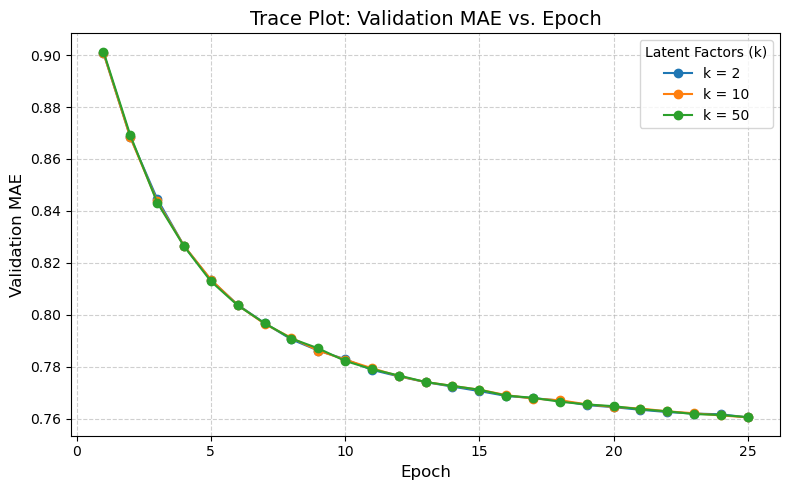

In [16]:
import matplotlib.pyplot as plt

# Organize data by k
results_by_k = {}
for result in all_results:
    k = result["k"]
    if k not in results_by_k:
        results_by_k[k] = {"epochs": [], "mae_valid": []}
    results_by_k[k]["epochs"].append(result["epoch"] + 1)  # Convert to 1-based epoch
    results_by_k[k]["mae_valid"].append(result["mae_valid"])

# Debugging: Check data structure
print("Data grouped by k:")
for k, values in results_by_k.items():
    print(f"k = {k}, Number of epochs: {len(values['epochs'])}")

# Plotting
plt.figure(figsize=(8, 5))

for k, values in results_by_k.items():
    plt.plot(values["epochs"], values["mae_valid"], marker='o', label=f"k = {k}")

# Plot customization
plt.title("Trace Plot: Validation MAE vs. Epoch", fontsize=14)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Validation MAE", fontsize=12)
plt.legend(title="Latent Factors (k)", fontsize=10)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()

# Display the plot
plt.show()

Data grouped by k:
k = 2, Number of epochs: 25
k = 10, Number of epochs: 25
k = 50, Number of epochs: 25


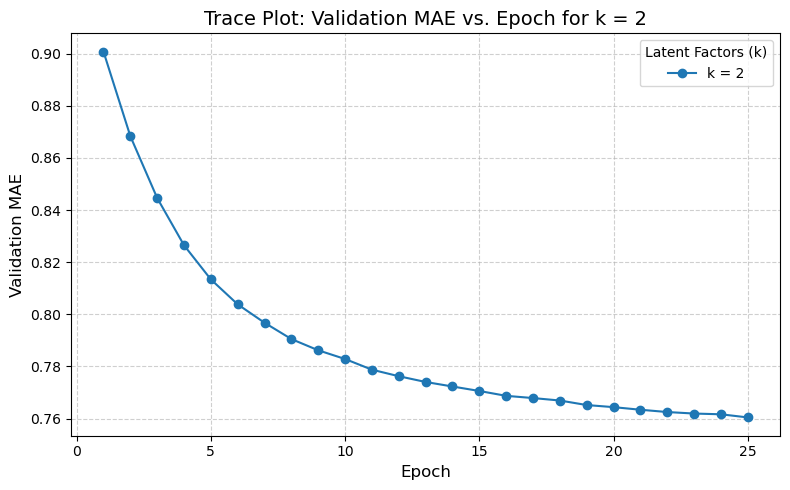

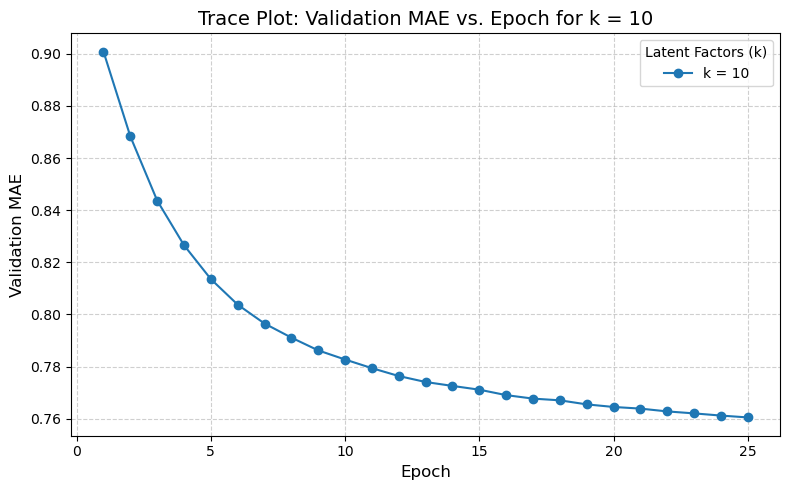

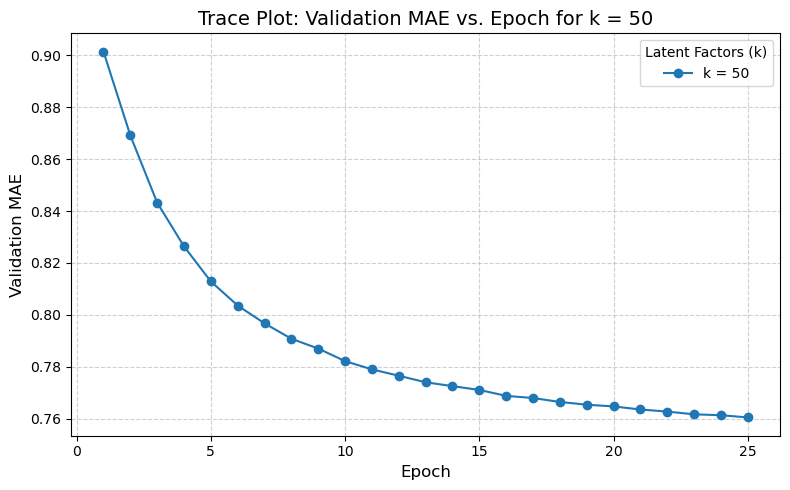

In [22]:
import matplotlib.pyplot as plt

# Organize data by k
results_by_k = {}
for result in all_results:
    k = result["k"]
    if k not in results_by_k:
        results_by_k[k] = {"epochs": [], "mae_valid": []}
    results_by_k[k]["epochs"].append(result["epoch"] + 1)  # Convert to 1-based epoch
    results_by_k[k]["mae_valid"].append(result["mae_valid"])

# Debugging: Check data structure
print("Data grouped by k:")
for k, values in results_by_k.items():
    print(f"k = {k}, Number of epochs: {len(values['epochs'])}")

# Create separate plots for each k
for k, values in results_by_k.items():
    plt.figure(figsize=(8, 5))
    plt.plot(values["epochs"], values["mae_valid"], marker='o', label=f"k = {k}")

    # Plot customization
    plt.title(f"Trace Plot: Validation MAE vs. Epoch for k = {k}", fontsize=14)
    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel("Validation MAE", fontsize=12)
    plt.legend(title="Latent Factors (k)", fontsize=10)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()

    # Display the plot
    plt.show()


In [23]:
## training with different alpha vals (original range), 10 LOOPS ##
train_tuple, valid_tuple, test_tuple, n_users, n_items = load_train_valid_test_datasets()

# Hyperparameters
n_epochs = 10
batch_size = 64
step_size = 0.1
alpha_vals = [0.01, 0.1, 1, 10, 100]
k = 50

all_results = []
best_results = []

for alpha in alpha_vals:
    print(f"\nTraining model with k = {k}, alpha = {alpha}")
    model = CollabFilterOneVectorPerItem(
        n_epochs=n_epochs,
        batch_size=batch_size,
        step_size=step_size,
        n_factors=k,
        alpha=alpha,
    )
    model.init_parameter_dict(n_users, n_items, train_tuple)

    best_mae_valid = float('inf')
    best_epoch = 0
    best_params = None

    for epoch in range(n_epochs):
        # Train the model for one epoch
        model.fit(train_tuple, valid_tuple)

        # Validation metrics
        user_id_valid, item_id_valid, y_valid = valid_tuple
        y_pred_valid = model.predict(user_id_valid, item_id_valid)
#         mse_valid = ag_np.mean((y_pred_valid - y_valid) ** 2)
        mae_valid = ag_np.mean(ag_np.abs(y_pred_valid - y_valid))
        params = model.param_dict.copy()
    
        if mae_valid < best_mae_valid:
            best_mae_valid = mae_valid
            best_epoch = epoch
            best_params = params

        print(f"Epoch {epoch + 1}/{n_epochs} - Validation MAE: {mae_valid:.4f}")
        
        all_results.append({        
            "k": k,
            "alpha": alpha,
            "mae_valid": mae_valid,
            "epoch": epoch})
        
        print("ALL RESULTS: ", all_results)
        
    # Load the best parameters
    model.param_dict = best_params

    # Compute final MAE metrics
    user_id_test, item_id_test, y_test = test_tuple
    y_pred_test = model.predict(user_id_test, item_id_test)
    mae_test = ag_np.mean(ag_np.abs(y_pred_test - y_test))

    mae_valid = ag_np.mean(ag_np.abs(model.predict(user_id_valid, item_id_valid) - y_valid))

    # Save results
    best_results.append({
        "k": k,
        "alpha": alpha,
        "mae_valid": mae_valid,
        "mae_test": mae_test,
        "best_epoch": best_epoch,
        "params": best_params
    })

    print(f"Results for k={k}, alpha={alpha}:")
    print(f"  Best epoch: {best_epoch}")
    print(f"  Validation MAE: {mae_valid:.4f}")
    print(f"  Test MAE: {mae_test:.4f}")

# Final results summary
for res in best_results:
    print(f"k={res['k']}, Validation MAE={res['mae_valid']:.4f}, Test MAE={res['mae_test']:.4f}")


Training model with k = 50, alpha = 0.01
epoch       0.000 | loss_total     0.17971 | train_MAE     3.53059 | valid_MAE     3.54504 | grad_wrt_mu     0.09961 | grad_wrt_b_per_user     0.00011 | grad_wrt_c_per_item     0.00006 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.001 | loss_total     0.20912 | train_MAE     3.52058 | valid_MAE     3.53504 | grad_wrt_mu     0.11052 | grad_wrt_b_per_user     0.00012 | grad_wrt_c_per_item     0.00007 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.002 | loss_total     0.20819 | train_MAE     3.50949 | valid_MAE     3.52394 | grad_wrt_mu     0.10773 | grad_wrt_b_per_user     0.00011 | grad_wrt_c_per_item     0.00006 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.003 | loss_total     0.21087 | train_MAE     3.49868 | valid_MAE     3.51313 | grad_wrt_mu     0.10934 | grad_wrt_b_per_user     0.00012 | grad_wrt_c_per_item     0.00007 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.125 

epoch       0.125 | loss_total     0.01976 | train_MAE     0.93037 | valid_MAE     0.93242 | grad_wrt_mu     0.00085 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.251 | loss_total     0.02068 | train_MAE     0.93026 | valid_MAE     0.93232 | grad_wrt_mu     0.00723 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.376 | loss_total     0.01695 | train_MAE     0.92965 | valid_MAE     0.93170 | grad_wrt_mu     0.00018 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.500 | loss_total     0.02163 | train_MAE     0.92902 | valid_MAE     0.93103 | grad_wrt_mu     0.00457 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.625 | loss_total     0.01854 | train_MAE     0

epoch       0.251 | loss_total     0.01797 | train_MAE     0.91924 | valid_MAE     0.92223 | grad_wrt_mu     0.00013 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.376 | loss_total     0.02122 | train_MAE     0.91878 | valid_MAE     0.92174 | grad_wrt_mu     0.00427 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.500 | loss_total     0.01854 | train_MAE     0.91859 | valid_MAE     0.92155 | grad_wrt_mu     0.00134 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.625 | loss_total     0.01881 | train_MAE     0.91821 | valid_MAE     0.92116 | grad_wrt_mu     0.00122 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.751 | loss_total     0.02583 | train_MAE     0

epoch       0.251 | loss_total     0.01995 | train_MAE     0.91188 | valid_MAE     0.91540 | grad_wrt_mu     0.00001 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.376 | loss_total     0.02137 | train_MAE     0.91156 | valid_MAE     0.91506 | grad_wrt_mu     0.00262 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.500 | loss_total     0.02570 | train_MAE     0.91182 | valid_MAE     0.91536 | grad_wrt_mu     0.00237 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.625 | loss_total     0.02230 | train_MAE     0.91194 | valid_MAE     0.91551 | grad_wrt_mu     0.00122 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.751 | loss_total     0.02398 | train_MAE     0

epoch       0.251 | loss_total     0.01534 | train_MAE     0.90738 | valid_MAE     0.91125 | grad_wrt_mu     0.00084 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.376 | loss_total     0.01503 | train_MAE     0.90830 | valid_MAE     0.91225 | grad_wrt_mu     0.01071 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.500 | loss_total     0.01958 | train_MAE     0.90752 | valid_MAE     0.91141 | grad_wrt_mu     0.00311 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.625 | loss_total     0.02336 | train_MAE     0.90763 | valid_MAE     0.91153 | grad_wrt_mu     0.00081 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.751 | loss_total     0.01750 | train_MAE     0

epoch       0.251 | loss_total     0.02059 | train_MAE     0.90470 | valid_MAE     0.90880 | grad_wrt_mu     0.00101 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.376 | loss_total     0.02511 | train_MAE     0.90414 | valid_MAE     0.90820 | grad_wrt_mu     0.00321 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.500 | loss_total     0.01843 | train_MAE     0.90344 | valid_MAE     0.90745 | grad_wrt_mu     0.00162 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.625 | loss_total     0.01760 | train_MAE     0.90448 | valid_MAE     0.90858 | grad_wrt_mu     0.00322 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.751 | loss_total     0.01815 | train_MAE     0

epoch       0.125 | loss_total     0.02259 | train_MAE     0.90315 | valid_MAE     0.90743 | grad_wrt_mu     0.00802 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.251 | loss_total     0.02108 | train_MAE     0.90304 | valid_MAE     0.90730 | grad_wrt_mu     0.00123 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.376 | loss_total     0.02297 | train_MAE     0.90348 | valid_MAE     0.90779 | grad_wrt_mu     0.00195 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.500 | loss_total     0.01946 | train_MAE     0.90336 | valid_MAE     0.90765 | grad_wrt_mu     0.00001 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.625 | loss_total     0.01838 | train_MAE     0

epoch       0.125 | loss_total     0.01661 | train_MAE     0.90189 | valid_MAE     0.90625 | grad_wrt_mu     0.00048 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.251 | loss_total     0.02408 | train_MAE     0.90172 | valid_MAE     0.90606 | grad_wrt_mu     0.00408 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.376 | loss_total     0.01740 | train_MAE     0.90208 | valid_MAE     0.90645 | grad_wrt_mu     0.00473 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.500 | loss_total     0.01745 | train_MAE     0.90163 | valid_MAE     0.90598 | grad_wrt_mu     0.00098 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.625 | loss_total     0.01644 | train_MAE     0

epoch       0.125 | loss_total     0.02195 | train_MAE     0.90055 | valid_MAE     0.90492 | grad_wrt_mu     0.00142 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.251 | loss_total     0.02219 | train_MAE     0.90128 | valid_MAE     0.90570 | grad_wrt_mu     0.00726 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.376 | loss_total     0.01350 | train_MAE     0.90147 | valid_MAE     0.90591 | grad_wrt_mu     0.00333 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.500 | loss_total     0.02338 | train_MAE     0.90158 | valid_MAE     0.90603 | grad_wrt_mu     0.00050 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.625 | loss_total     0.01754 | train_MAE     0

epoch       0.125 | loss_total     0.02188 | train_MAE     0.90129 | valid_MAE     0.90581 | grad_wrt_mu     0.00078 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.251 | loss_total     0.02118 | train_MAE     0.90123 | valid_MAE     0.90574 | grad_wrt_mu     0.00266 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.376 | loss_total     0.02273 | train_MAE     0.90087 | valid_MAE     0.90535 | grad_wrt_mu     0.00679 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.500 | loss_total     0.02776 | train_MAE     0.90068 | valid_MAE     0.90514 | grad_wrt_mu     0.00653 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.625 | loss_total     0.02061 | train_MAE     0

epoch       0.125 | loss_total     0.09847 | train_MAE     2.34940 | valid_MAE     2.36273 | grad_wrt_mu     0.06353 | grad_wrt_b_per_user     0.00008 | grad_wrt_c_per_item     0.00004 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.251 | loss_total     0.06780 | train_MAE     1.68008 | valid_MAE     1.68915 | grad_wrt_mu     0.04560 | grad_wrt_b_per_user     0.00006 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.376 | loss_total     0.04520 | train_MAE     1.36822 | valid_MAE     1.37564 | grad_wrt_mu     0.02663 | grad_wrt_b_per_user     0.00005 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.500 | loss_total     0.03635 | train_MAE     1.17752 | valid_MAE     1.18396 | grad_wrt_mu     0.01654 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.625 | loss_total     0.03714 | train_MAE     1

epoch       0.125 | loss_total     0.03594 | train_MAE     0.97335 | valid_MAE     0.97716 | grad_wrt_mu     0.00097 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.251 | loss_total     0.03868 | train_MAE     0.97341 | valid_MAE     0.97723 | grad_wrt_mu     0.00706 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.376 | loss_total     0.03313 | train_MAE     0.97300 | valid_MAE     0.97678 | grad_wrt_mu     0.00008 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.500 | loss_total     0.03933 | train_MAE     0.97253 | valid_MAE     0.97628 | grad_wrt_mu     0.00465 | grad_wrt_b_per_user     0.00005 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.625 | loss_total     0.03531 | train_MAE     0

epoch       0.125 | loss_total     0.03710 | train_MAE     0.97305 | valid_MAE     0.97686 | grad_wrt_mu     0.00386 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.251 | loss_total     0.03378 | train_MAE     0.97325 | valid_MAE     0.97708 | grad_wrt_mu     0.00011 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.376 | loss_total     0.03641 | train_MAE     0.97286 | valid_MAE     0.97666 | grad_wrt_mu     0.00401 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.500 | loss_total     0.03476 | train_MAE     0.97275 | valid_MAE     0.97654 | grad_wrt_mu     0.00111 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.625 | loss_total     0.03517 | train_MAE     0

epoch       0.125 | loss_total     0.03636 | train_MAE     0.97292 | valid_MAE     0.97673 | grad_wrt_mu     0.00094 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.251 | loss_total     0.03617 | train_MAE     0.97270 | valid_MAE     0.97648 | grad_wrt_mu     0.00006 | grad_wrt_b_per_user     0.00005 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.376 | loss_total     0.03919 | train_MAE     0.97248 | valid_MAE     0.97624 | grad_wrt_mu     0.00278 | grad_wrt_b_per_user     0.00005 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.500 | loss_total     0.04126 | train_MAE     0.97287 | valid_MAE     0.97667 | grad_wrt_mu     0.00248 | grad_wrt_b_per_user     0.00005 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.625 | loss_total     0.03898 | train_MAE     0

epoch       0.125 | loss_total     0.03895 | train_MAE     0.97259 | valid_MAE     0.97636 | grad_wrt_mu     0.00152 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.251 | loss_total     0.03103 | train_MAE     0.97258 | valid_MAE     0.97636 | grad_wrt_mu     0.00103 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.376 | loss_total     0.03427 | train_MAE     0.97357 | valid_MAE     0.97743 | grad_wrt_mu     0.01050 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.500 | loss_total     0.03651 | train_MAE     0.97279 | valid_MAE     0.97657 | grad_wrt_mu     0.00291 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.625 | loss_total     0.04022 | train_MAE     0

epoch       0.125 | loss_total     0.04016 | train_MAE     0.97224 | valid_MAE     0.97598 | grad_wrt_mu     0.00459 | grad_wrt_b_per_user     0.00005 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.251 | loss_total     0.03747 | train_MAE     0.97277 | valid_MAE     0.97656 | grad_wrt_mu     0.00149 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.376 | loss_total     0.04064 | train_MAE     0.97225 | valid_MAE     0.97599 | grad_wrt_mu     0.00318 | grad_wrt_b_per_user     0.00005 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.500 | loss_total     0.03543 | train_MAE     0.97158 | valid_MAE     0.97527 | grad_wrt_mu     0.00237 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.625 | loss_total     0.03520 | train_MAE     0

epoch       0.125 | loss_total     0.03634 | train_MAE     0.97301 | valid_MAE     0.97683 | grad_wrt_mu     0.00781 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.251 | loss_total     0.03782 | train_MAE     0.97288 | valid_MAE     0.97668 | grad_wrt_mu     0.00190 | grad_wrt_b_per_user     0.00005 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.376 | loss_total     0.04070 | train_MAE     0.97338 | valid_MAE     0.97723 | grad_wrt_mu     0.00165 | grad_wrt_b_per_user     0.00005 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.500 | loss_total     0.03647 | train_MAE     0.97326 | valid_MAE     0.97710 | grad_wrt_mu     0.00006 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.625 | loss_total     0.03382 | train_MAE     0

epoch       0.125 | loss_total     0.03327 | train_MAE     0.97293 | valid_MAE     0.97674 | grad_wrt_mu     0.00048 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.251 | loss_total     0.04090 | train_MAE     0.97282 | valid_MAE     0.97661 | grad_wrt_mu     0.00440 | grad_wrt_b_per_user     0.00005 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.376 | loss_total     0.03239 | train_MAE     0.97312 | valid_MAE     0.97694 | grad_wrt_mu     0.00438 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.500 | loss_total     0.03312 | train_MAE     0.97273 | valid_MAE     0.97651 | grad_wrt_mu     0.00060 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.625 | loss_total     0.03369 | train_MAE     0

epoch       0.125 | loss_total     0.03900 | train_MAE     0.97238 | valid_MAE     0.97613 | grad_wrt_mu     0.00168 | grad_wrt_b_per_user     0.00005 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.251 | loss_total     0.03653 | train_MAE     0.97311 | valid_MAE     0.97693 | grad_wrt_mu     0.00688 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.376 | loss_total     0.03077 | train_MAE     0.97331 | valid_MAE     0.97715 | grad_wrt_mu     0.00351 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.500 | loss_total     0.03982 | train_MAE     0.97342 | valid_MAE     0.97727 | grad_wrt_mu     0.00036 | grad_wrt_b_per_user     0.00005 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.625 | loss_total     0.03579 | train_MAE     0

epoch       0.125 | loss_total     0.03796 | train_MAE     0.97361 | valid_MAE     0.97748 | grad_wrt_mu     0.00033 | grad_wrt_b_per_user     0.00005 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.251 | loss_total     0.03831 | train_MAE     0.97351 | valid_MAE     0.97737 | grad_wrt_mu     0.00261 | grad_wrt_b_per_user     0.00005 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.376 | loss_total     0.03691 | train_MAE     0.97317 | valid_MAE     0.97699 | grad_wrt_mu     0.00720 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.500 | loss_total     0.04354 | train_MAE     0.97298 | valid_MAE     0.97679 | grad_wrt_mu     0.00721 | grad_wrt_b_per_user     0.00005 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.625 | loss_total     0.03777 | train_MAE     0

epoch       0.125 | loss_total     0.12630 | train_MAE     2.51547 | valid_MAE     2.52985 | grad_wrt_mu     0.04153 | grad_wrt_b_per_user     0.00010 | grad_wrt_c_per_item     0.00006 | grad_wrt_U     0.00002 | grad_wrt_V     0.00002
epoch       0.251 | loss_total     0.12564 | train_MAE     2.12996 | valid_MAE     2.14190 | grad_wrt_mu     0.02242 | grad_wrt_b_per_user     0.00011 | grad_wrt_c_per_item     0.00006 | grad_wrt_U     0.00001 | grad_wrt_V     0.00001
epoch       0.376 | loss_total     0.11506 | train_MAE     1.97264 | valid_MAE     1.98357 | grad_wrt_mu     0.00832 | grad_wrt_b_per_user     0.00011 | grad_wrt_c_per_item     0.00006 | grad_wrt_U     0.00001 | grad_wrt_V     0.00001
epoch       0.500 | loss_total     0.11200 | train_MAE     1.90316 | valid_MAE     1.91364 | grad_wrt_mu     0.00337 | grad_wrt_b_per_user     0.00010 | grad_wrt_c_per_item     0.00006 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.625 | loss_total     0.11288 | train_MAE     1

epoch       0.125 | loss_total     0.11694 | train_MAE     1.85671 | valid_MAE     1.86692 | grad_wrt_mu     0.00104 | grad_wrt_b_per_user     0.00011 | grad_wrt_c_per_item     0.00006 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.251 | loss_total     0.12818 | train_MAE     1.85761 | valid_MAE     1.86782 | grad_wrt_mu     0.00701 | grad_wrt_b_per_user     0.00012 | grad_wrt_c_per_item     0.00006 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.376 | loss_total     0.11283 | train_MAE     1.85472 | valid_MAE     1.86491 | grad_wrt_mu     0.00007 | grad_wrt_b_per_user     0.00011 | grad_wrt_c_per_item     0.00006 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.500 | loss_total     0.12613 | train_MAE     1.85249 | valid_MAE     1.86266 | grad_wrt_mu     0.00465 | grad_wrt_b_per_user     0.00011 | grad_wrt_c_per_item     0.00006 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.625 | loss_total     0.11852 | train_MAE     1

epoch       0.125 | loss_total     0.12249 | train_MAE     1.85553 | valid_MAE     1.86572 | grad_wrt_mu     0.00388 | grad_wrt_b_per_user     0.00011 | grad_wrt_c_per_item     0.00006 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.251 | loss_total     0.11334 | train_MAE     1.85735 | valid_MAE     1.86756 | grad_wrt_mu     0.00012 | grad_wrt_b_per_user     0.00011 | grad_wrt_c_per_item     0.00006 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.376 | loss_total     0.11046 | train_MAE     1.85448 | valid_MAE     1.86466 | grad_wrt_mu     0.00400 | grad_wrt_b_per_user     0.00010 | grad_wrt_c_per_item     0.00006 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.500 | loss_total     0.11309 | train_MAE     1.85416 | valid_MAE     1.86434 | grad_wrt_mu     0.00110 | grad_wrt_b_per_user     0.00011 | grad_wrt_c_per_item     0.00006 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.625 | loss_total     0.11686 | train_MAE     1

epoch       0.125 | loss_total     0.11460 | train_MAE     1.85504 | valid_MAE     1.86523 | grad_wrt_mu     0.00100 | grad_wrt_b_per_user     0.00011 | grad_wrt_c_per_item     0.00006 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.251 | loss_total     0.11581 | train_MAE     1.85343 | valid_MAE     1.86361 | grad_wrt_mu     0.00015 | grad_wrt_b_per_user     0.00011 | grad_wrt_c_per_item     0.00006 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.376 | loss_total     0.12324 | train_MAE     1.85205 | valid_MAE     1.86221 | grad_wrt_mu     0.00268 | grad_wrt_b_per_user     0.00011 | grad_wrt_c_per_item     0.00006 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.500 | loss_total     0.11736 | train_MAE     1.85521 | valid_MAE     1.86540 | grad_wrt_mu     0.00250 | grad_wrt_b_per_user     0.00010 | grad_wrt_c_per_item     0.00006 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.625 | loss_total     0.12074 | train_MAE     1

epoch       0.125 | loss_total     0.11666 | train_MAE     1.85393 | valid_MAE     1.86411 | grad_wrt_mu     0.00158 | grad_wrt_b_per_user     0.00011 | grad_wrt_c_per_item     0.00006 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.251 | loss_total     0.10924 | train_MAE     1.85368 | valid_MAE     1.86386 | grad_wrt_mu     0.00110 | grad_wrt_b_per_user     0.00011 | grad_wrt_c_per_item     0.00006 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.376 | loss_total     0.12872 | train_MAE     1.86019 | valid_MAE     1.87040 | grad_wrt_mu     0.01058 | grad_wrt_b_per_user     0.00012 | grad_wrt_c_per_item     0.00006 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.500 | loss_total     0.12035 | train_MAE     1.85390 | valid_MAE     1.86408 | grad_wrt_mu     0.00281 | grad_wrt_b_per_user     0.00011 | grad_wrt_c_per_item     0.00006 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.625 | loss_total     0.12137 | train_MAE     1

epoch       0.125 | loss_total     0.11352 | train_MAE     1.85099 | valid_MAE     1.86113 | grad_wrt_mu     0.00472 | grad_wrt_b_per_user     0.00010 | grad_wrt_c_per_item     0.00006 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.251 | loss_total     0.11515 | train_MAE     1.85546 | valid_MAE     1.86563 | grad_wrt_mu     0.00150 | grad_wrt_b_per_user     0.00010 | grad_wrt_c_per_item     0.00006 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.376 | loss_total     0.11606 | train_MAE     1.85193 | valid_MAE     1.86208 | grad_wrt_mu     0.00321 | grad_wrt_b_per_user     0.00011 | grad_wrt_c_per_item     0.00006 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.500 | loss_total     0.11933 | train_MAE     1.84763 | valid_MAE     1.85776 | grad_wrt_mu     0.00234 | grad_wrt_b_per_user     0.00011 | grad_wrt_c_per_item     0.00006 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.625 | loss_total     0.12054 | train_MAE     1

epoch       0.125 | loss_total     0.10471 | train_MAE     1.85594 | valid_MAE     1.86613 | grad_wrt_mu     0.00778 | grad_wrt_b_per_user     0.00010 | grad_wrt_c_per_item     0.00006 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.251 | loss_total     0.11480 | train_MAE     1.85490 | valid_MAE     1.86508 | grad_wrt_mu     0.00202 | grad_wrt_b_per_user     0.00010 | grad_wrt_c_per_item     0.00006 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.376 | loss_total     0.12267 | train_MAE     1.85884 | valid_MAE     1.86904 | grad_wrt_mu     0.00169 | grad_wrt_b_per_user     0.00011 | grad_wrt_c_per_item     0.00006 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.500 | loss_total     0.11622 | train_MAE     1.85734 | valid_MAE     1.86754 | grad_wrt_mu     0.00010 | grad_wrt_b_per_user     0.00011 | grad_wrt_c_per_item     0.00006 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.625 | loss_total     0.10926 | train_MAE     1

epoch       0.125 | loss_total     0.11367 | train_MAE     1.85653 | valid_MAE     1.86674 | grad_wrt_mu     0.00055 | grad_wrt_b_per_user     0.00011 | grad_wrt_c_per_item     0.00006 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.251 | loss_total     0.11448 | train_MAE     1.85571 | valid_MAE     1.86591 | grad_wrt_mu     0.00440 | grad_wrt_b_per_user     0.00011 | grad_wrt_c_per_item     0.00006 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.376 | loss_total     0.10571 | train_MAE     1.85725 | valid_MAE     1.86745 | grad_wrt_mu     0.00428 | grad_wrt_b_per_user     0.00010 | grad_wrt_c_per_item     0.00006 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.500 | loss_total     0.11202 | train_MAE     1.85431 | valid_MAE     1.86449 | grad_wrt_mu     0.00058 | grad_wrt_b_per_user     0.00011 | grad_wrt_c_per_item     0.00006 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.625 | loss_total     0.11214 | train_MAE     1

epoch       0.125 | loss_total     0.12152 | train_MAE     1.85164 | valid_MAE     1.86180 | grad_wrt_mu     0.00163 | grad_wrt_b_per_user     0.00011 | grad_wrt_c_per_item     0.00006 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.251 | loss_total     0.10631 | train_MAE     1.85833 | valid_MAE     1.86854 | grad_wrt_mu     0.00667 | grad_wrt_b_per_user     0.00010 | grad_wrt_c_per_item     0.00006 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.376 | loss_total     0.11536 | train_MAE     1.85851 | valid_MAE     1.86871 | grad_wrt_mu     0.00362 | grad_wrt_b_per_user     0.00011 | grad_wrt_c_per_item     0.00006 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.500 | loss_total     0.11882 | train_MAE     1.85835 | valid_MAE     1.86856 | grad_wrt_mu     0.00030 | grad_wrt_b_per_user     0.00011 | grad_wrt_c_per_item     0.00006 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.625 | loss_total     0.12395 | train_MAE     1

epoch       0.125 | loss_total     0.11691 | train_MAE     1.85926 | valid_MAE     1.86948 | grad_wrt_mu     0.00023 | grad_wrt_b_per_user     0.00011 | grad_wrt_c_per_item     0.00006 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.251 | loss_total     0.12147 | train_MAE     1.85838 | valid_MAE     1.86858 | grad_wrt_mu     0.00263 | grad_wrt_b_per_user     0.00011 | grad_wrt_c_per_item     0.00006 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.376 | loss_total     0.10601 | train_MAE     1.85596 | valid_MAE     1.86616 | grad_wrt_mu     0.00731 | grad_wrt_b_per_user     0.00010 | grad_wrt_c_per_item     0.00006 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.500 | loss_total     0.11285 | train_MAE     1.85470 | valid_MAE     1.86488 | grad_wrt_mu     0.00739 | grad_wrt_b_per_user     0.00011 | grad_wrt_c_per_item     0.00006 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.625 | loss_total     0.11894 | train_MAE     1

epoch       0.125 | loss_total     0.18391 | train_MAE     3.21206 | valid_MAE     3.22653 | grad_wrt_mu     0.00414 | grad_wrt_b_per_user     0.00018 | grad_wrt_c_per_item     0.00010 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.251 | loss_total     0.20541 | train_MAE     3.20730 | valid_MAE     3.22176 | grad_wrt_mu     0.00253 | grad_wrt_b_per_user     0.00019 | grad_wrt_c_per_item     0.00011 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.376 | loss_total     0.19416 | train_MAE     3.20981 | valid_MAE     3.22427 | grad_wrt_mu     0.00046 | grad_wrt_b_per_user     0.00019 | grad_wrt_c_per_item     0.00011 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.500 | loss_total     0.19170 | train_MAE     3.20677 | valid_MAE     3.22123 | grad_wrt_mu     0.00058 | grad_wrt_b_per_user     0.00018 | grad_wrt_c_per_item     0.00011 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.625 | loss_total     0.18990 | train_MAE     3

epoch       0.125 | loss_total     0.19823 | train_MAE     3.20837 | valid_MAE     3.22284 | grad_wrt_mu     0.00094 | grad_wrt_b_per_user     0.00019 | grad_wrt_c_per_item     0.00011 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.251 | loss_total     0.21786 | train_MAE     3.21036 | valid_MAE     3.22482 | grad_wrt_mu     0.00749 | grad_wrt_b_per_user     0.00020 | grad_wrt_c_per_item     0.00011 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.376 | loss_total     0.19269 | train_MAE     3.20857 | valid_MAE     3.22304 | grad_wrt_mu     0.00003 | grad_wrt_b_per_user     0.00019 | grad_wrt_c_per_item     0.00011 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.500 | loss_total     0.21308 | train_MAE     3.20906 | valid_MAE     3.22352 | grad_wrt_mu     0.00509 | grad_wrt_b_per_user     0.00019 | grad_wrt_c_per_item     0.00011 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.625 | loss_total     0.20192 | train_MAE     3

epoch       0.125 | loss_total     0.20801 | train_MAE     3.20561 | valid_MAE     3.22007 | grad_wrt_mu     0.00292 | grad_wrt_b_per_user     0.00019 | grad_wrt_c_per_item     0.00011 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.251 | loss_total     0.19317 | train_MAE     3.21019 | valid_MAE     3.22465 | grad_wrt_mu     0.00059 | grad_wrt_b_per_user     0.00019 | grad_wrt_c_per_item     0.00011 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.376 | loss_total     0.18466 | train_MAE     3.20913 | valid_MAE     3.22360 | grad_wrt_mu     0.00368 | grad_wrt_b_per_user     0.00018 | grad_wrt_c_per_item     0.00011 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.500 | loss_total     0.19152 | train_MAE     3.20907 | valid_MAE     3.22353 | grad_wrt_mu     0.00077 | grad_wrt_b_per_user     0.00019 | grad_wrt_c_per_item     0.00010 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.625 | loss_total     0.19881 | train_MAE     3

epoch       0.125 | loss_total     0.19301 | train_MAE     3.20784 | valid_MAE     3.22230 | grad_wrt_mu     0.00119 | grad_wrt_b_per_user     0.00019 | grad_wrt_c_per_item     0.00011 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.251 | loss_total     0.19563 | train_MAE     3.20729 | valid_MAE     3.22175 | grad_wrt_mu     0.00040 | grad_wrt_b_per_user     0.00019 | grad_wrt_c_per_item     0.00011 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.376 | loss_total     0.20736 | train_MAE     3.20476 | valid_MAE     3.21922 | grad_wrt_mu     0.00166 | grad_wrt_b_per_user     0.00019 | grad_wrt_c_per_item     0.00011 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.500 | loss_total     0.19370 | train_MAE     3.20751 | valid_MAE     3.22197 | grad_wrt_mu     0.00277 | grad_wrt_b_per_user     0.00018 | grad_wrt_c_per_item     0.00011 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.625 | loss_total     0.20270 | train_MAE     3

epoch       0.125 | loss_total     0.19438 | train_MAE     3.20992 | valid_MAE     3.22439 | grad_wrt_mu     0.00096 | grad_wrt_b_per_user     0.00019 | grad_wrt_c_per_item     0.00011 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.251 | loss_total     0.18764 | train_MAE     3.20790 | valid_MAE     3.22235 | grad_wrt_mu     0.00117 | grad_wrt_b_per_user     0.00019 | grad_wrt_c_per_item     0.00011 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.376 | loss_total     0.22334 | train_MAE     3.20988 | valid_MAE     3.22434 | grad_wrt_mu     0.01074 | grad_wrt_b_per_user     0.00020 | grad_wrt_c_per_item     0.00011 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.500 | loss_total     0.20442 | train_MAE     3.20652 | valid_MAE     3.22098 | grad_wrt_mu     0.00226 | grad_wrt_b_per_user     0.00019 | grad_wrt_c_per_item     0.00011 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.625 | loss_total     0.20263 | train_MAE     3

epoch       0.125 | loss_total     0.18701 | train_MAE     3.20807 | valid_MAE     3.22253 | grad_wrt_mu     0.00453 | grad_wrt_b_per_user     0.00018 | grad_wrt_c_per_item     0.00011 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.251 | loss_total     0.19290 | train_MAE     3.20946 | valid_MAE     3.22392 | grad_wrt_mu     0.00113 | grad_wrt_b_per_user     0.00018 | grad_wrt_c_per_item     0.00010 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.376 | loss_total     0.19167 | train_MAE     3.20774 | valid_MAE     3.22220 | grad_wrt_mu     0.00318 | grad_wrt_b_per_user     0.00018 | grad_wrt_c_per_item     0.00010 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.500 | loss_total     0.20345 | train_MAE     3.20588 | valid_MAE     3.22034 | grad_wrt_mu     0.00204 | grad_wrt_b_per_user     0.00019 | grad_wrt_c_per_item     0.00011 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.625 | loss_total     0.20607 | train_MAE     3

epoch       0.125 | loss_total     0.17325 | train_MAE     3.20734 | valid_MAE     3.22180 | grad_wrt_mu     0.00820 | grad_wrt_b_per_user     0.00018 | grad_wrt_c_per_item     0.00010 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.251 | loss_total     0.19183 | train_MAE     3.20893 | valid_MAE     3.22339 | grad_wrt_mu     0.00180 | grad_wrt_b_per_user     0.00018 | grad_wrt_c_per_item     0.00010 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.376 | loss_total     0.20466 | train_MAE     3.21037 | valid_MAE     3.22483 | grad_wrt_mu     0.00211 | grad_wrt_b_per_user     0.00019 | grad_wrt_c_per_item     0.00011 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.500 | loss_total     0.19609 | train_MAE     3.20884 | valid_MAE     3.22330 | grad_wrt_mu     0.00012 | grad_wrt_b_per_user     0.00019 | grad_wrt_c_per_item     0.00010 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.625 | loss_total     0.18484 | train_MAE     3

epoch       0.125 | loss_total     0.19423 | train_MAE     3.21023 | valid_MAE     3.22469 | grad_wrt_mu     0.00109 | grad_wrt_b_per_user     0.00019 | grad_wrt_c_per_item     0.00011 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.251 | loss_total     0.18799 | train_MAE     3.20940 | valid_MAE     3.22386 | grad_wrt_mu     0.00407 | grad_wrt_b_per_user     0.00018 | grad_wrt_c_per_item     0.00010 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.376 | loss_total     0.17921 | train_MAE     3.20756 | valid_MAE     3.22202 | grad_wrt_mu     0.00471 | grad_wrt_b_per_user     0.00019 | grad_wrt_c_per_item     0.00010 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.500 | loss_total     0.19114 | train_MAE     3.20878 | valid_MAE     3.22324 | grad_wrt_mu     0.00038 | grad_wrt_b_per_user     0.00019 | grad_wrt_c_per_item     0.00011 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.625 | loss_total     0.19057 | train_MAE     3

epoch       0.125 | loss_total     0.20424 | train_MAE     3.20624 | valid_MAE     3.22070 | grad_wrt_mu     0.00118 | grad_wrt_b_per_user     0.00019 | grad_wrt_c_per_item     0.00011 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.251 | loss_total     0.17629 | train_MAE     3.21250 | valid_MAE     3.22697 | grad_wrt_mu     0.00546 | grad_wrt_b_per_user     0.00018 | grad_wrt_c_per_item     0.00010 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.376 | loss_total     0.20013 | train_MAE     3.20889 | valid_MAE     3.22335 | grad_wrt_mu     0.00356 | grad_wrt_b_per_user     0.00019 | grad_wrt_c_per_item     0.00011 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.500 | loss_total     0.19796 | train_MAE     3.20795 | valid_MAE     3.22241 | grad_wrt_mu     0.00067 | grad_wrt_b_per_user     0.00019 | grad_wrt_c_per_item     0.00011 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.625 | loss_total     0.21228 | train_MAE     3

epoch       0.125 | loss_total     0.19602 | train_MAE     3.20877 | valid_MAE     3.22322 | grad_wrt_mu     0.00039 | grad_wrt_b_per_user     0.00019 | grad_wrt_c_per_item     0.00011 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.251 | loss_total     0.20484 | train_MAE     3.20921 | valid_MAE     3.22367 | grad_wrt_mu     0.00269 | grad_wrt_b_per_user     0.00019 | grad_wrt_c_per_item     0.00011 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.376 | loss_total     0.17525 | train_MAE     3.20905 | valid_MAE     3.22352 | grad_wrt_mu     0.00712 | grad_wrt_b_per_user     0.00018 | grad_wrt_c_per_item     0.00010 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.500 | loss_total     0.18211 | train_MAE     3.20739 | valid_MAE     3.22185 | grad_wrt_mu     0.00769 | grad_wrt_b_per_user     0.00018 | grad_wrt_c_per_item     0.00010 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.625 | loss_total     0.20020 | train_MAE     3

epoch       0.125 | loss_total     0.19822 | train_MAE     3.49545 | valid_MAE     3.50990 | grad_wrt_mu     0.00550 | grad_wrt_b_per_user     0.00020 | grad_wrt_c_per_item     0.00012 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.251 | loss_total     0.22209 | train_MAE     3.49548 | valid_MAE     3.50993 | grad_wrt_mu     0.00288 | grad_wrt_b_per_user     0.00021 | grad_wrt_c_per_item     0.00012 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.376 | loss_total     0.20999 | train_MAE     3.49554 | valid_MAE     3.50999 | grad_wrt_mu     0.00016 | grad_wrt_b_per_user     0.00020 | grad_wrt_c_per_item     0.00012 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.500 | loss_total     0.20755 | train_MAE     3.49480 | valid_MAE     3.50925 | grad_wrt_mu     0.00218 | grad_wrt_b_per_user     0.00020 | grad_wrt_c_per_item     0.00012 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.625 | loss_total     0.20517 | train_MAE     3

epoch       0.125 | loss_total     0.21435 | train_MAE     3.49578 | valid_MAE     3.51023 | grad_wrt_mu     0.00187 | grad_wrt_b_per_user     0.00020 | grad_wrt_c_per_item     0.00012 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.251 | loss_total     0.23563 | train_MAE     3.49509 | valid_MAE     3.50954 | grad_wrt_mu     0.00558 | grad_wrt_b_per_user     0.00022 | grad_wrt_c_per_item     0.00012 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.376 | loss_total     0.20852 | train_MAE     3.49604 | valid_MAE     3.51049 | grad_wrt_mu     0.00169 | grad_wrt_b_per_user     0.00021 | grad_wrt_c_per_item     0.00011 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.500 | loss_total     0.23033 | train_MAE     3.49596 | valid_MAE     3.51041 | grad_wrt_mu     0.00634 | grad_wrt_b_per_user     0.00021 | grad_wrt_c_per_item     0.00012 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.625 | loss_total     0.21845 | train_MAE     3

epoch       0.125 | loss_total     0.22499 | train_MAE     3.49483 | valid_MAE     3.50928 | grad_wrt_mu     0.00181 | grad_wrt_b_per_user     0.00021 | grad_wrt_c_per_item     0.00012 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.251 | loss_total     0.20901 | train_MAE     3.49633 | valid_MAE     3.51079 | grad_wrt_mu     0.00263 | grad_wrt_b_per_user     0.00020 | grad_wrt_c_per_item     0.00012 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.376 | loss_total     0.19938 | train_MAE     3.49644 | valid_MAE     3.51089 | grad_wrt_mu     0.00093 | grad_wrt_b_per_user     0.00020 | grad_wrt_c_per_item     0.00012 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.500 | loss_total     0.20709 | train_MAE     3.49601 | valid_MAE     3.51046 | grad_wrt_mu     0.00064 | grad_wrt_b_per_user     0.00020 | grad_wrt_c_per_item     0.00011 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.625 | loss_total     0.21507 | train_MAE     3

epoch       0.125 | loss_total     0.20856 | train_MAE     3.49610 | valid_MAE     3.51055 | grad_wrt_mu     0.00093 | grad_wrt_b_per_user     0.00020 | grad_wrt_c_per_item     0.00012 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.251 | loss_total     0.21146 | train_MAE     3.49542 | valid_MAE     3.50987 | grad_wrt_mu     0.00021 | grad_wrt_b_per_user     0.00021 | grad_wrt_c_per_item     0.00012 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.376 | loss_total     0.22405 | train_MAE     3.49413 | valid_MAE     3.50858 | grad_wrt_mu     0.00136 | grad_wrt_b_per_user     0.00021 | grad_wrt_c_per_item     0.00012 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.500 | loss_total     0.20886 | train_MAE     3.49475 | valid_MAE     3.50920 | grad_wrt_mu     0.00478 | grad_wrt_b_per_user     0.00020 | grad_wrt_c_per_item     0.00012 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.625 | loss_total     0.21897 | train_MAE     3

epoch       0.125 | loss_total     0.20980 | train_MAE     3.49622 | valid_MAE     3.51068 | grad_wrt_mu     0.00085 | grad_wrt_b_per_user     0.00021 | grad_wrt_c_per_item     0.00011 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.251 | loss_total     0.20319 | train_MAE     3.49511 | valid_MAE     3.50956 | grad_wrt_mu     0.00220 | grad_wrt_b_per_user     0.00021 | grad_wrt_c_per_item     0.00012 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.376 | loss_total     0.24210 | train_MAE     3.49549 | valid_MAE     3.50994 | grad_wrt_mu     0.01023 | grad_wrt_b_per_user     0.00022 | grad_wrt_c_per_item     0.00012 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.500 | loss_total     0.22112 | train_MAE     3.49535 | valid_MAE     3.50980 | grad_wrt_mu     0.00250 | grad_wrt_b_per_user     0.00021 | grad_wrt_c_per_item     0.00012 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.625 | loss_total     0.21875 | train_MAE     3

epoch       0.125 | loss_total     0.20160 | train_MAE     3.49564 | valid_MAE     3.51009 | grad_wrt_mu     0.00395 | grad_wrt_b_per_user     0.00020 | grad_wrt_c_per_item     0.00012 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.251 | loss_total     0.20833 | train_MAE     3.49568 | valid_MAE     3.51013 | grad_wrt_mu     0.00089 | grad_wrt_b_per_user     0.00021 | grad_wrt_c_per_item     0.00011 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.376 | loss_total     0.20668 | train_MAE     3.49473 | valid_MAE     3.50919 | grad_wrt_mu     0.00531 | grad_wrt_b_per_user     0.00020 | grad_wrt_c_per_item     0.00012 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.500 | loss_total     0.22014 | train_MAE     3.49516 | valid_MAE     3.50961 | grad_wrt_mu     0.00189 | grad_wrt_b_per_user     0.00021 | grad_wrt_c_per_item     0.00012 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.625 | loss_total     0.22304 | train_MAE     3

epoch       0.125 | loss_total     0.18683 | train_MAE     3.49539 | valid_MAE     3.50984 | grad_wrt_mu     0.00816 | grad_wrt_b_per_user     0.00019 | grad_wrt_c_per_item     0.00012 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.251 | loss_total     0.20712 | train_MAE     3.49609 | valid_MAE     3.51055 | grad_wrt_mu     0.00006 | grad_wrt_b_per_user     0.00019 | grad_wrt_c_per_item     0.00011 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.376 | loss_total     0.22092 | train_MAE     3.49545 | valid_MAE     3.50990 | grad_wrt_mu     0.00133 | grad_wrt_b_per_user     0.00020 | grad_wrt_c_per_item     0.00012 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.500 | loss_total     0.21194 | train_MAE     3.49508 | valid_MAE     3.50953 | grad_wrt_mu     0.00129 | grad_wrt_b_per_user     0.00020 | grad_wrt_c_per_item     0.00012 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.625 | loss_total     0.19984 | train_MAE     3

epoch       0.125 | loss_total     0.21022 | train_MAE     3.49554 | valid_MAE     3.50999 | grad_wrt_mu     0.00064 | grad_wrt_b_per_user     0.00021 | grad_wrt_c_per_item     0.00012 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.251 | loss_total     0.20258 | train_MAE     3.49479 | valid_MAE     3.50924 | grad_wrt_mu     0.00660 | grad_wrt_b_per_user     0.00020 | grad_wrt_c_per_item     0.00011 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.376 | loss_total     0.19380 | train_MAE     3.49386 | valid_MAE     3.50831 | grad_wrt_mu     0.00953 | grad_wrt_b_per_user     0.00021 | grad_wrt_c_per_item     0.00011 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.500 | loss_total     0.20683 | train_MAE     3.49562 | valid_MAE     3.51007 | grad_wrt_mu     0.00010 | grad_wrt_b_per_user     0.00021 | grad_wrt_c_per_item     0.00011 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.625 | loss_total     0.20612 | train_MAE     3

epoch       0.125 | loss_total     0.22066 | train_MAE     3.49495 | valid_MAE     3.50940 | grad_wrt_mu     0.00024 | grad_wrt_b_per_user     0.00021 | grad_wrt_c_per_item     0.00012 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.251 | loss_total     0.19020 | train_MAE     3.49644 | valid_MAE     3.51089 | grad_wrt_mu     0.00387 | grad_wrt_b_per_user     0.00019 | grad_wrt_c_per_item     0.00011 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.376 | loss_total     0.21695 | train_MAE     3.49530 | valid_MAE     3.50975 | grad_wrt_mu     0.00280 | grad_wrt_b_per_user     0.00020 | grad_wrt_c_per_item     0.00012 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.500 | loss_total     0.21367 | train_MAE     3.49437 | valid_MAE     3.50882 | grad_wrt_mu     0.00403 | grad_wrt_b_per_user     0.00021 | grad_wrt_c_per_item     0.00012 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.625 | loss_total     0.22980 | train_MAE     3

epoch       0.125 | loss_total     0.21172 | train_MAE     3.49518 | valid_MAE     3.50963 | grad_wrt_mu     0.00148 | grad_wrt_b_per_user     0.00020 | grad_wrt_c_per_item     0.00012 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.251 | loss_total     0.22138 | train_MAE     3.49503 | valid_MAE     3.50948 | grad_wrt_mu     0.00097 | grad_wrt_b_per_user     0.00021 | grad_wrt_c_per_item     0.00012 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.376 | loss_total     0.18900 | train_MAE     3.49635 | valid_MAE     3.51080 | grad_wrt_mu     0.00465 | grad_wrt_b_per_user     0.00019 | grad_wrt_c_per_item     0.00011 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.500 | loss_total     0.19584 | train_MAE     3.49587 | valid_MAE     3.51032 | grad_wrt_mu     0.00614 | grad_wrt_b_per_user     0.00020 | grad_wrt_c_per_item     0.00011 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.625 | loss_total     0.21631 | train_MAE     3

Data grouped by alpha:
alpha = 1e-05, Number of epochs: 25


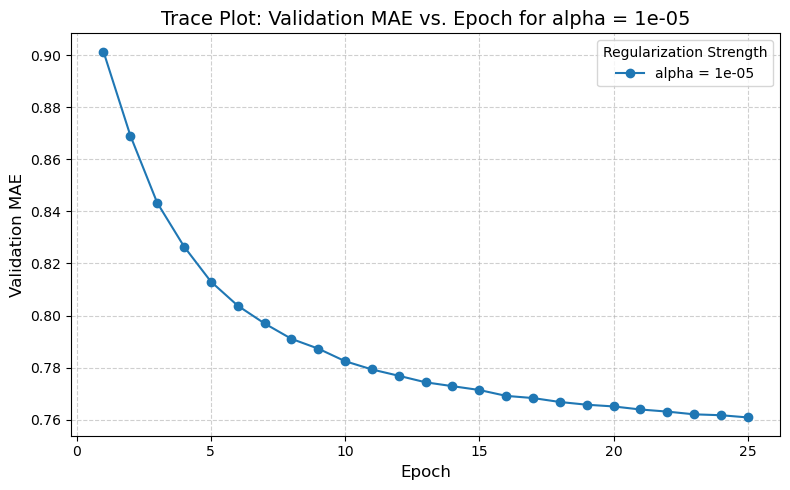

In [24]:
import matplotlib.pyplot as plt

# Organize data by alpha
results_by_alpha = {}
for result in all_results:
    alpha = result["alpha"]
    if alpha not in results_by_alpha:
        results_by_alpha[alpha] = {"epochs": [], "mae_valid": []}
    results_by_alpha[alpha]["epochs"].append(result["epoch"] + 1)  # Convert to 1-based epoch
    results_by_alpha[alpha]["mae_valid"].append(result["mae_valid"])

# Debugging: Check grouped data
print("Data grouped by alpha:")
for alpha, values in results_by_alpha.items():
    print(f"alpha = {alpha}, Number of epochs: {len(values['epochs'])}")

# Create separate plots for each alpha
for alpha, values in results_by_alpha.items():
    plt.figure(figsize=(8, 5))
    plt.plot(values["epochs"], values["mae_valid"], marker='o', label=f"alpha = {alpha}")

    # Customize plot
    plt.title(f"Trace Plot: Validation MAE vs. Epoch for alpha = {alpha}", fontsize=14)
    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel("Validation MAE", fontsize=12)
    plt.legend(title="Regularization Strength", fontsize=10)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()

    # Show plot
    plt.show()


In [32]:
# THIS WILL RUN VERY LONG
## training with different alpha vals (0.0001, 0.001, 0.01, 0.1) 25 LOOPS##
train_tuple, valid_tuple, test_tuple, n_users, n_items = load_train_valid_test_datasets()

# Hyperparameters
n_epochs = 25
batch_size = 64
step_size = 0.1
alpha_vals = [0.0001, 0.001, 0.01, 0.1]
k = 50

all_results = []
best_results = []

for alpha in alpha_vals:
    print(f"\nTraining model with k = {k}, alpha = {alpha}")
    model = CollabFilterOneVectorPerItem(
        n_epochs=n_epochs,
        batch_size=batch_size,
        step_size=step_size,
        n_factors=k,
        alpha=alpha,
    )
    model.init_parameter_dict(n_users, n_items, train_tuple)

    best_mae_valid = float('inf')
    best_epoch = 0
    best_params = None

    for epoch in range(n_epochs):
        # Train the model for one epoch
        model.fit(train_tuple, valid_tuple)

        # Validation metrics
        user_id_valid, item_id_valid, y_valid = valid_tuple
        y_pred_valid = model.predict(user_id_valid, item_id_valid)
#         mse_valid = ag_np.mean((y_pred_valid - y_valid) ** 2)
        mae_valid = ag_np.mean(ag_np.abs(y_pred_valid - y_valid))
        params = model.param_dict.copy()
    
        if mae_valid < best_mae_valid:
            best_mae_valid = mae_valid
            best_epoch = epoch
            best_params = params

        print(f"Epoch {epoch + 1}/{n_epochs} - Validation MAE: {mae_valid:.4f}")
        
        all_results.append({        
            "k": k,
            "alpha": alpha,
            "mae_valid": mae_valid,
            "epoch": epoch})
        
        print("ALL RESULTS: ", all_results)
        
    # Load the best parameters
    model.param_dict = best_params

    # Compute final MAE metrics
    user_id_test, item_id_test, y_test = test_tuple
    y_pred_test = model.predict(user_id_test, item_id_test)
    mae_test = ag_np.mean(ag_np.abs(y_pred_test - y_test))

    mae_valid = ag_np.mean(ag_np.abs(model.predict(user_id_valid, item_id_valid) - y_valid))

    # Save results
    best_results.append({
        "k": k,
        "alpha": alpha,
        "mae_valid": mae_valid,
        "mae_test": mae_test,
        "best_epoch": best_epoch,
        "params": best_params
    })

    print(f"Results for k={k}, alpha={alpha}:")
    print(f"  Best epoch: {best_epoch}")
    print(f"  Validation MAE: {mae_valid:.4f}")
    print(f"  Test MAE: {mae_test:.4f}")

# Final results summary
for res in best_results:
    print(f"k={res['k']}, Validation MAE={res['mae_valid']:.4f}, Test MAE={res['mae_test']:.4f}")


Training model with k = 50, alpha = 0.0001
epoch       0.000 | loss_total     0.17969 | train_MAE     3.53059 | valid_MAE     3.54504 | grad_wrt_mu     0.09961 | grad_wrt_b_per_user     0.00011 | grad_wrt_c_per_item     0.00006 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.001 | loss_total     0.20910 | train_MAE     3.52058 | valid_MAE     3.53504 | grad_wrt_mu     0.11053 | grad_wrt_b_per_user     0.00012 | grad_wrt_c_per_item     0.00007 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.002 | loss_total     0.20817 | train_MAE     3.50949 | valid_MAE     3.52394 | grad_wrt_mu     0.10774 | grad_wrt_b_per_user     0.00011 | grad_wrt_c_per_item     0.00006 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.003 | loss_total     0.21085 | train_MAE     3.49868 | valid_MAE     3.51313 | grad_wrt_mu     0.10935 | grad_wrt_b_per_user     0.00012 | grad_wrt_c_per_item     0.00007 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.12

epoch      12.000 | loss_total     0.01886 | train_MAE     0.91980 | valid_MAE     0.92208 | grad_wrt_mu     0.00479 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      13.000 | loss_total     0.01878 | train_MAE     0.91746 | valid_MAE     0.91986 | grad_wrt_mu     0.01025 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      14.000 | loss_total     0.01871 | train_MAE     0.91606 | valid_MAE     0.91866 | grad_wrt_mu     0.00817 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      15.000 | loss_total     0.01865 | train_MAE     0.91431 | valid_MAE     0.91707 | grad_wrt_mu     0.00215 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      16.000 | loss_total     0.01858 | train_MAE     0

epoch       3.000 | loss_total     0.01788 | train_MAE     0.89183 | valid_MAE     0.89634 | grad_wrt_mu     0.00285 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       3.500 | loss_total     0.01785 | train_MAE     0.89134 | valid_MAE     0.89593 | grad_wrt_mu     0.00363 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       4.000 | loss_total     0.01782 | train_MAE     0.89080 | valid_MAE     0.89547 | grad_wrt_mu     0.00612 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       4.500 | loss_total     0.01772 | train_MAE     0.88907 | valid_MAE     0.89372 | grad_wrt_mu     0.00385 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       5.000 | loss_total     0.01778 | train_MAE     0

epoch       0.500 | loss_total     0.01498 | train_MAE     0.86054 | valid_MAE     0.86736 | grad_wrt_mu     0.00084 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.625 | loss_total     0.01374 | train_MAE     0.86135 | valid_MAE     0.86828 | grad_wrt_mu     0.00273 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.751 | loss_total     0.01508 | train_MAE     0.86145 | valid_MAE     0.86841 | grad_wrt_mu     0.00191 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.876 | loss_total     0.01755 | train_MAE     0.86206 | valid_MAE     0.86910 | grad_wrt_mu     0.00412 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.000 | loss_total     0.01886 | train_MAE     0

epoch      19.000 | loss_total     0.01643 | train_MAE     0.84164 | valid_MAE     0.84990 | grad_wrt_mu     0.00538 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      20.000 | loss_total     0.01641 | train_MAE     0.84031 | valid_MAE     0.84859 | grad_wrt_mu     0.00186 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      21.000 | loss_total     0.01639 | train_MAE     0.83993 | valid_MAE     0.84832 | grad_wrt_mu     0.00009 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      22.000 | loss_total     0.01636 | train_MAE     0.83920 | valid_MAE     0.84766 | grad_wrt_mu     0.00001 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      23.000 | loss_total     0.01634 | train_MAE     0

epoch       6.000 | loss_total     0.01617 | train_MAE     0.83040 | valid_MAE     0.83933 | grad_wrt_mu     0.00171 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       6.500 | loss_total     0.01619 | train_MAE     0.83131 | valid_MAE     0.84036 | grad_wrt_mu     0.00477 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       7.000 | loss_total     0.01615 | train_MAE     0.83033 | valid_MAE     0.83937 | grad_wrt_mu     0.00403 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       7.500 | loss_total     0.01604 | train_MAE     0.83005 | valid_MAE     0.83913 | grad_wrt_mu     0.00512 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       8.000 | loss_total     0.01613 | train_MAE     0

epoch       1.125 | loss_total     0.01618 | train_MAE     0.81715 | valid_MAE     0.82728 | grad_wrt_mu     0.00496 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.251 | loss_total     0.01541 | train_MAE     0.81722 | valid_MAE     0.82738 | grad_wrt_mu     0.00169 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.376 | loss_total     0.01791 | train_MAE     0.81700 | valid_MAE     0.82715 | grad_wrt_mu     0.00067 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.500 | loss_total     0.01260 | train_MAE     0.81690 | valid_MAE     0.82706 | grad_wrt_mu     0.00300 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.625 | loss_total     0.01730 | train_MAE     0

epoch      24.000 | loss_total     0.01550 | train_MAE     0.80408 | valid_MAE     0.81509 | grad_wrt_mu     0.00426 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      24.999 | loss_total     0.01549 | train_MAE     0.80351 | valid_MAE     0.81455 | grad_wrt_mu     0.00397 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
Epoch 5/25 - Validation MAE: 0.8145
ALL RESULTS:  [{'k': 50, 'alpha': 0.0001, 'mae_valid': 0.9015670224723613, 'epoch': 0}, {'k': 50, 'alpha': 0.0001, 'mae_valid': 0.869690597767307, 'epoch': 1}, {'k': 50, 'alpha': 0.0001, 'mae_valid': 0.8442611505581268, 'epoch': 2}, {'k': 50, 'alpha': 0.0001, 'mae_valid': 0.82774587584322, 'epoch': 3}, {'k': 50, 'alpha': 0.0001, 'mae_valid': 0.8145135712530364, 'epoch': 4}]
epoch       0.000 | loss_total     0.00951 | train_MAE     0.80348 | valid_MAE     0.81451 | grad_wrt_mu     0.00040 

epoch       9.000 | loss_total     0.01539 | train_MAE     0.79945 | valid_MAE     0.81083 | grad_wrt_mu     0.00452 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      10.000 | loss_total     0.01538 | train_MAE     0.79993 | valid_MAE     0.81146 | grad_wrt_mu     0.00412 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      11.000 | loss_total     0.01537 | train_MAE     0.79914 | valid_MAE     0.81066 | grad_wrt_mu     0.00427 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      12.000 | loss_total     0.01536 | train_MAE     0.79876 | valid_MAE     0.81032 | grad_wrt_mu     0.00406 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      13.000 | loss_total     0.01535 | train_MAE     0

epoch       1.625 | loss_total     0.01899 | train_MAE     0.79319 | valid_MAE     0.80529 | grad_wrt_mu     0.00213 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.751 | loss_total     0.01346 | train_MAE     0.79271 | valid_MAE     0.80475 | grad_wrt_mu     0.00483 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.876 | loss_total     0.01313 | train_MAE     0.79256 | valid_MAE     0.80459 | grad_wrt_mu     0.00194 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       2.000 | loss_total     0.01624 | train_MAE     0.79337 | valid_MAE     0.80553 | grad_wrt_mu     0.00280 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       2.500 | loss_total     0.01517 | train_MAE     0

epoch       0.125 | loss_total     0.01334 | train_MAE     0.78611 | valid_MAE     0.79910 | grad_wrt_mu     0.00374 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.251 | loss_total     0.01518 | train_MAE     0.78596 | valid_MAE     0.79894 | grad_wrt_mu     0.00011 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.376 | loss_total     0.01074 | train_MAE     0.78499 | valid_MAE     0.79784 | grad_wrt_mu     0.00470 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.500 | loss_total     0.01374 | train_MAE     0.78499 | valid_MAE     0.79784 | grad_wrt_mu     0.00449 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.625 | loss_total     0.01499 | train_MAE     0

epoch      16.000 | loss_total     0.01493 | train_MAE     0.78148 | valid_MAE     0.79494 | grad_wrt_mu     0.00770 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      17.000 | loss_total     0.01492 | train_MAE     0.78147 | valid_MAE     0.79499 | grad_wrt_mu     0.00321 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      18.000 | loss_total     0.01492 | train_MAE     0.78080 | valid_MAE     0.79430 | grad_wrt_mu     0.00242 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      19.000 | loss_total     0.01491 | train_MAE     0.78022 | valid_MAE     0.79369 | grad_wrt_mu     0.00021 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      20.000 | loss_total     0.01490 | train_MAE     0

epoch       4.000 | loss_total     0.01486 | train_MAE     0.77872 | valid_MAE     0.79262 | grad_wrt_mu     0.00403 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       4.500 | loss_total     0.01489 | train_MAE     0.77843 | valid_MAE     0.79231 | grad_wrt_mu     0.01048 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       5.000 | loss_total     0.01485 | train_MAE     0.77815 | valid_MAE     0.79202 | grad_wrt_mu     0.00456 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       5.500 | loss_total     0.01489 | train_MAE     0.77821 | valid_MAE     0.79212 | grad_wrt_mu     0.00847 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       6.000 | loss_total     0.01484 | train_MAE     0

epoch       0.376 | loss_total     0.01423 | train_MAE     0.77398 | valid_MAE     0.78843 | grad_wrt_mu     0.00050 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.500 | loss_total     0.01445 | train_MAE     0.77418 | valid_MAE     0.78867 | grad_wrt_mu     0.00010 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.625 | loss_total     0.01153 | train_MAE     0.77438 | valid_MAE     0.78890 | grad_wrt_mu     0.00592 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.751 | loss_total     0.01303 | train_MAE     0.77408 | valid_MAE     0.78855 | grad_wrt_mu     0.00166 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.876 | loss_total     0.01436 | train_MAE     0

epoch      18.000 | loss_total     0.01466 | train_MAE     0.77081 | valid_MAE     0.78570 | grad_wrt_mu     0.00073 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      19.000 | loss_total     0.01466 | train_MAE     0.77103 | valid_MAE     0.78601 | grad_wrt_mu     0.00586 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      20.000 | loss_total     0.01465 | train_MAE     0.77057 | valid_MAE     0.78552 | grad_wrt_mu     0.00016 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      21.000 | loss_total     0.01465 | train_MAE     0.77049 | valid_MAE     0.78548 | grad_wrt_mu     0.00067 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      22.000 | loss_total     0.01464 | train_MAE     0

epoch       4.500 | loss_total     0.01464 | train_MAE     0.76901 | valid_MAE     0.78418 | grad_wrt_mu     0.00376 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       5.000 | loss_total     0.01461 | train_MAE     0.76901 | valid_MAE     0.78421 | grad_wrt_mu     0.00279 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       5.500 | loss_total     0.01462 | train_MAE     0.76872 | valid_MAE     0.78388 | grad_wrt_mu     0.00275 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       6.000 | loss_total     0.01461 | train_MAE     0.76883 | valid_MAE     0.78404 | grad_wrt_mu     0.00494 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       6.500 | loss_total     0.01463 | train_MAE     0

epoch       0.500 | loss_total     0.01625 | train_MAE     0.76599 | valid_MAE     0.78164 | grad_wrt_mu     0.00381 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.625 | loss_total     0.01311 | train_MAE     0.76543 | valid_MAE     0.78097 | grad_wrt_mu     0.00085 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.751 | loss_total     0.01613 | train_MAE     0.76592 | valid_MAE     0.78157 | grad_wrt_mu     0.00399 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.876 | loss_total     0.01515 | train_MAE     0.76573 | valid_MAE     0.78135 | grad_wrt_mu     0.00687 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.000 | loss_total     0.01196 | train_MAE     0

epoch      19.000 | loss_total     0.01449 | train_MAE     0.76331 | valid_MAE     0.77931 | grad_wrt_mu     0.00269 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      20.000 | loss_total     0.01448 | train_MAE     0.76408 | valid_MAE     0.78028 | grad_wrt_mu     0.00369 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      21.000 | loss_total     0.01448 | train_MAE     0.76337 | valid_MAE     0.77947 | grad_wrt_mu     0.00350 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      22.000 | loss_total     0.01447 | train_MAE     0.76277 | valid_MAE     0.77879 | grad_wrt_mu     0.00055 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      23.000 | loss_total     0.01448 | train_MAE     0

epoch       4.500 | loss_total     0.01444 | train_MAE     0.76238 | valid_MAE     0.77866 | grad_wrt_mu     0.00384 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       5.000 | loss_total     0.01445 | train_MAE     0.76259 | valid_MAE     0.77894 | grad_wrt_mu     0.00648 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       5.500 | loss_total     0.01444 | train_MAE     0.76228 | valid_MAE     0.77858 | grad_wrt_mu     0.00635 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       6.000 | loss_total     0.01445 | train_MAE     0.76223 | valid_MAE     0.77855 | grad_wrt_mu     0.00198 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       6.500 | loss_total     0.01452 | train_MAE     0

epoch       0.376 | loss_total     0.01634 | train_MAE     0.76051 | valid_MAE     0.77729 | grad_wrt_mu     0.00276 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.500 | loss_total     0.01361 | train_MAE     0.76030 | valid_MAE     0.77703 | grad_wrt_mu     0.00180 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.625 | loss_total     0.01243 | train_MAE     0.76000 | valid_MAE     0.77667 | grad_wrt_mu     0.00311 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.751 | loss_total     0.01377 | train_MAE     0.76029 | valid_MAE     0.77703 | grad_wrt_mu     0.00442 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.876 | loss_total     0.01510 | train_MAE     0

epoch      18.000 | loss_total     0.01436 | train_MAE     0.75848 | valid_MAE     0.77551 | grad_wrt_mu     0.00104 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      19.000 | loss_total     0.01434 | train_MAE     0.75834 | valid_MAE     0.77537 | grad_wrt_mu     0.00367 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      20.000 | loss_total     0.01435 | train_MAE     0.75832 | valid_MAE     0.77539 | grad_wrt_mu     0.00331 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      21.000 | loss_total     0.01435 | train_MAE     0.75803 | valid_MAE     0.77507 | grad_wrt_mu     0.00545 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      22.000 | loss_total     0.01434 | train_MAE     0

epoch       4.000 | loss_total     0.01433 | train_MAE     0.75746 | valid_MAE     0.77468 | grad_wrt_mu     0.00470 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       4.500 | loss_total     0.01438 | train_MAE     0.75807 | valid_MAE     0.77544 | grad_wrt_mu     0.00316 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       5.000 | loss_total     0.01432 | train_MAE     0.75704 | valid_MAE     0.77419 | grad_wrt_mu     0.00064 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       5.500 | loss_total     0.01429 | train_MAE     0.75709 | valid_MAE     0.77427 | grad_wrt_mu     0.00487 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       6.000 | loss_total     0.01433 | train_MAE     0

epoch       0.125 | loss_total     0.01368 | train_MAE     0.75555 | valid_MAE     0.77309 | grad_wrt_mu     0.00117 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.251 | loss_total     0.01276 | train_MAE     0.75525 | valid_MAE     0.77272 | grad_wrt_mu     0.00196 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.376 | loss_total     0.01348 | train_MAE     0.75569 | valid_MAE     0.77328 | grad_wrt_mu     0.00057 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.500 | loss_total     0.01238 | train_MAE     0.75593 | valid_MAE     0.77358 | grad_wrt_mu     0.00230 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.625 | loss_total     0.01562 | train_MAE     0

epoch      16.000 | loss_total     0.01426 | train_MAE     0.75511 | valid_MAE     0.77312 | grad_wrt_mu     0.00056 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      17.000 | loss_total     0.01426 | train_MAE     0.75447 | valid_MAE     0.77236 | grad_wrt_mu     0.00104 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      18.000 | loss_total     0.01425 | train_MAE     0.75448 | valid_MAE     0.77241 | grad_wrt_mu     0.00611 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      19.000 | loss_total     0.01425 | train_MAE     0.75418 | valid_MAE     0.77207 | grad_wrt_mu     0.00089 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      20.000 | loss_total     0.01425 | train_MAE     0

epoch       2.500 | loss_total     0.01422 | train_MAE     0.75353 | valid_MAE     0.77154 | grad_wrt_mu     0.00454 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       3.000 | loss_total     0.01423 | train_MAE     0.75351 | valid_MAE     0.77153 | grad_wrt_mu     0.00382 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       3.500 | loss_total     0.01427 | train_MAE     0.75312 | valid_MAE     0.77107 | grad_wrt_mu     0.00443 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       4.000 | loss_total     0.01423 | train_MAE     0.75378 | valid_MAE     0.77192 | grad_wrt_mu     0.00744 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       4.500 | loss_total     0.01425 | train_MAE     0

epoch       0.125 | loss_total     0.01034 | train_MAE     0.75246 | valid_MAE     0.77094 | grad_wrt_mu     0.00271 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.251 | loss_total     0.01666 | train_MAE     0.75228 | valid_MAE     0.77072 | grad_wrt_mu     0.00355 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.376 | loss_total     0.01495 | train_MAE     0.75157 | valid_MAE     0.76983 | grad_wrt_mu     0.00100 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.500 | loss_total     0.01682 | train_MAE     0.75247 | valid_MAE     0.77096 | grad_wrt_mu     0.00296 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.625 | loss_total     0.00961 | train_MAE     0

epoch      16.000 | loss_total     0.01417 | train_MAE     0.75122 | valid_MAE     0.76987 | grad_wrt_mu     0.00262 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      17.000 | loss_total     0.01417 | train_MAE     0.75165 | valid_MAE     0.77043 | grad_wrt_mu     0.00289 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      18.000 | loss_total     0.01418 | train_MAE     0.75093 | valid_MAE     0.76957 | grad_wrt_mu     0.00460 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      19.000 | loss_total     0.01418 | train_MAE     0.75119 | valid_MAE     0.76992 | grad_wrt_mu     0.00034 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      20.000 | loss_total     0.01416 | train_MAE     0

epoch       2.500 | loss_total     0.01421 | train_MAE     0.75057 | valid_MAE     0.76939 | grad_wrt_mu     0.00501 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       3.000 | loss_total     0.01416 | train_MAE     0.75028 | valid_MAE     0.76903 | grad_wrt_mu     0.00367 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       3.500 | loss_total     0.01418 | train_MAE     0.75038 | valid_MAE     0.76917 | grad_wrt_mu     0.00204 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       4.000 | loss_total     0.01416 | train_MAE     0.75026 | valid_MAE     0.76904 | grad_wrt_mu     0.00209 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       4.500 | loss_total     0.01415 | train_MAE     0

epoch       0.125 | loss_total     0.01078 | train_MAE     0.74933 | valid_MAE     0.76844 | grad_wrt_mu     0.00220 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.251 | loss_total     0.01698 | train_MAE     0.74921 | valid_MAE     0.76829 | grad_wrt_mu     0.00085 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.376 | loss_total     0.01249 | train_MAE     0.74909 | valid_MAE     0.76815 | grad_wrt_mu     0.00435 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.500 | loss_total     0.01040 | train_MAE     0.74995 | valid_MAE     0.76923 | grad_wrt_mu     0.00110 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.625 | loss_total     0.01346 | train_MAE     0

epoch      16.000 | loss_total     0.01412 | train_MAE     0.74862 | valid_MAE     0.76795 | grad_wrt_mu     0.00380 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      17.000 | loss_total     0.01411 | train_MAE     0.74829 | valid_MAE     0.76756 | grad_wrt_mu     0.00048 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      18.000 | loss_total     0.01411 | train_MAE     0.74864 | valid_MAE     0.76803 | grad_wrt_mu     0.00000 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      19.000 | loss_total     0.01410 | train_MAE     0.74825 | valid_MAE     0.76756 | grad_wrt_mu     0.00113 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      20.000 | loss_total     0.01411 | train_MAE     0

epoch       2.000 | loss_total     0.01472 | train_MAE     0.74748 | valid_MAE     0.76677 | grad_wrt_mu     0.00107 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       2.500 | loss_total     0.01406 | train_MAE     0.74767 | valid_MAE     0.76703 | grad_wrt_mu     0.00487 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       3.000 | loss_total     0.01410 | train_MAE     0.74792 | valid_MAE     0.76737 | grad_wrt_mu     0.00273 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       3.500 | loss_total     0.01404 | train_MAE     0.74784 | valid_MAE     0.76727 | grad_wrt_mu     0.00179 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       4.000 | loss_total     0.01410 | train_MAE     0

epoch       0.125 | loss_total     0.01731 | train_MAE     0.74673 | valid_MAE     0.76640 | grad_wrt_mu     0.00692 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.251 | loss_total     0.01327 | train_MAE     0.74668 | valid_MAE     0.76633 | grad_wrt_mu     0.00157 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.376 | loss_total     0.01723 | train_MAE     0.74683 | valid_MAE     0.76651 | grad_wrt_mu     0.00204 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.500 | loss_total     0.01729 | train_MAE     0.74706 | valid_MAE     0.76681 | grad_wrt_mu     0.00526 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.625 | loss_total     0.01626 | train_MAE     0

epoch      16.000 | loss_total     0.01405 | train_MAE     0.74613 | valid_MAE     0.76600 | grad_wrt_mu     0.00611 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      17.000 | loss_total     0.01406 | train_MAE     0.74617 | valid_MAE     0.76607 | grad_wrt_mu     0.00226 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      18.000 | loss_total     0.01406 | train_MAE     0.74623 | valid_MAE     0.76616 | grad_wrt_mu     0.00140 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      19.000 | loss_total     0.01405 | train_MAE     0.74559 | valid_MAE     0.76538 | grad_wrt_mu     0.00360 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      20.000 | loss_total     0.01405 | train_MAE     0

epoch       1.876 | loss_total     0.01357 | train_MAE     0.74564 | valid_MAE     0.76562 | grad_wrt_mu     0.00336 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       2.000 | loss_total     0.01293 | train_MAE     0.74562 | valid_MAE     0.76559 | grad_wrt_mu     0.00251 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       2.500 | loss_total     0.01406 | train_MAE     0.74543 | valid_MAE     0.76537 | grad_wrt_mu     0.00065 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       3.000 | loss_total     0.01405 | train_MAE     0.74564 | valid_MAE     0.76564 | grad_wrt_mu     0.00230 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       3.500 | loss_total     0.01402 | train_MAE     0

epoch       0.125 | loss_total     0.01420 | train_MAE     0.74451 | valid_MAE     0.76468 | grad_wrt_mu     0.00145 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.251 | loss_total     0.01161 | train_MAE     0.74445 | valid_MAE     0.76460 | grad_wrt_mu     0.00291 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.376 | loss_total     0.01362 | train_MAE     0.74465 | valid_MAE     0.76485 | grad_wrt_mu     0.00107 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.500 | loss_total     0.01658 | train_MAE     0.74466 | valid_MAE     0.76487 | grad_wrt_mu     0.00191 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.625 | loss_total     0.01996 | train_MAE     0

epoch      16.000 | loss_total     0.01401 | train_MAE     0.74417 | valid_MAE     0.76456 | grad_wrt_mu     0.00309 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      17.000 | loss_total     0.01401 | train_MAE     0.74435 | valid_MAE     0.76479 | grad_wrt_mu     0.00544 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      18.000 | loss_total     0.01402 | train_MAE     0.74422 | valid_MAE     0.76465 | grad_wrt_mu     0.00284 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      19.000 | loss_total     0.01402 | train_MAE     0.74394 | valid_MAE     0.76433 | grad_wrt_mu     0.00694 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      20.000 | loss_total     0.01401 | train_MAE     0

epoch       1.876 | loss_total     0.01506 | train_MAE     0.74402 | valid_MAE     0.76457 | grad_wrt_mu     0.00162 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       2.000 | loss_total     0.01752 | train_MAE     0.74430 | valid_MAE     0.76492 | grad_wrt_mu     0.00331 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       2.500 | loss_total     0.01400 | train_MAE     0.74375 | valid_MAE     0.76423 | grad_wrt_mu     0.00549 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       3.000 | loss_total     0.01400 | train_MAE     0.74389 | valid_MAE     0.76443 | grad_wrt_mu     0.00022 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       3.500 | loss_total     0.01406 | train_MAE     0

epoch       0.125 | loss_total     0.09445 | train_MAE     2.32857 | valid_MAE     2.34176 | grad_wrt_mu     0.06650 | grad_wrt_b_per_user     0.00007 | grad_wrt_c_per_item     0.00004 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.251 | loss_total     0.05801 | train_MAE     1.62594 | valid_MAE     1.63470 | grad_wrt_mu     0.04942 | grad_wrt_b_per_user     0.00006 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.376 | loss_total     0.03190 | train_MAE     1.28744 | valid_MAE     1.29444 | grad_wrt_mu     0.03026 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.500 | loss_total     0.02092 | train_MAE     1.06676 | valid_MAE     1.07262 | grad_wrt_mu     0.01964 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.625 | loss_total     0.02100 | train_MAE     0

epoch      16.000 | loss_total     0.01881 | train_MAE     0.91350 | valid_MAE     0.91637 | grad_wrt_mu     0.00007 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      17.000 | loss_total     0.01875 | train_MAE     0.91209 | valid_MAE     0.91513 | grad_wrt_mu     0.00033 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      18.000 | loss_total     0.01868 | train_MAE     0.91010 | valid_MAE     0.91325 | grad_wrt_mu     0.00538 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      19.000 | loss_total     0.01863 | train_MAE     0.90763 | valid_MAE     0.91085 | grad_wrt_mu     0.00495 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      20.000 | loss_total     0.01858 | train_MAE     0

epoch       1.751 | loss_total     0.01816 | train_MAE     0.89639 | valid_MAE     0.90065 | grad_wrt_mu     0.00192 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.876 | loss_total     0.01978 | train_MAE     0.89626 | valid_MAE     0.90054 | grad_wrt_mu     0.00242 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       2.000 | loss_total     0.01900 | train_MAE     0.89619 | valid_MAE     0.90049 | grad_wrt_mu     0.00061 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       2.500 | loss_total     0.01830 | train_MAE     0.89605 | valid_MAE     0.90046 | grad_wrt_mu     0.00180 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       3.000 | loss_total     0.01819 | train_MAE     0

epoch       0.125 | loss_total     0.02207 | train_MAE     0.86742 | valid_MAE     0.87392 | grad_wrt_mu     0.00450 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.251 | loss_total     0.01700 | train_MAE     0.86774 | valid_MAE     0.87429 | grad_wrt_mu     0.00052 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.376 | loss_total     0.02213 | train_MAE     0.86703 | valid_MAE     0.87354 | grad_wrt_mu     0.00321 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.500 | loss_total     0.01545 | train_MAE     0.86622 | valid_MAE     0.87267 | grad_wrt_mu     0.00095 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.625 | loss_total     0.01427 | train_MAE     0

epoch      16.000 | loss_total     0.01714 | train_MAE     0.85378 | valid_MAE     0.86145 | grad_wrt_mu     0.00106 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      17.000 | loss_total     0.01713 | train_MAE     0.85281 | valid_MAE     0.86052 | grad_wrt_mu     0.00835 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      18.000 | loss_total     0.01711 | train_MAE     0.85178 | valid_MAE     0.85952 | grad_wrt_mu     0.00232 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      19.000 | loss_total     0.01710 | train_MAE     0.85040 | valid_MAE     0.85814 | grad_wrt_mu     0.00545 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      20.000 | loss_total     0.01709 | train_MAE     0

epoch       1.625 | loss_total     0.02259 | train_MAE     0.84545 | valid_MAE     0.85362 | grad_wrt_mu     0.00383 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.751 | loss_total     0.02151 | train_MAE     0.84561 | valid_MAE     0.85381 | grad_wrt_mu     0.00357 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.876 | loss_total     0.01820 | train_MAE     0.84483 | valid_MAE     0.85297 | grad_wrt_mu     0.00017 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       2.000 | loss_total     0.01823 | train_MAE     0.84404 | valid_MAE     0.85213 | grad_wrt_mu     0.00204 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       2.500 | loss_total     0.01687 | train_MAE     0

epoch       0.125 | loss_total     0.01585 | train_MAE     0.83098 | valid_MAE     0.84006 | grad_wrt_mu     0.00281 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.251 | loss_total     0.01219 | train_MAE     0.83081 | valid_MAE     0.83989 | grad_wrt_mu     0.00170 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.376 | loss_total     0.01478 | train_MAE     0.83028 | valid_MAE     0.83933 | grad_wrt_mu     0.00517 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.500 | loss_total     0.01584 | train_MAE     0.83040 | valid_MAE     0.83946 | grad_wrt_mu     0.00357 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.625 | loss_total     0.01658 | train_MAE     0

epoch      16.000 | loss_total     0.01662 | train_MAE     0.82331 | valid_MAE     0.83292 | grad_wrt_mu     0.00828 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      17.000 | loss_total     0.01660 | train_MAE     0.82330 | valid_MAE     0.83297 | grad_wrt_mu     0.00120 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      18.000 | loss_total     0.01661 | train_MAE     0.82270 | valid_MAE     0.83239 | grad_wrt_mu     0.00064 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      19.000 | loss_total     0.01660 | train_MAE     0.82184 | valid_MAE     0.83153 | grad_wrt_mu     0.00349 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      20.000 | loss_total     0.01659 | train_MAE     0

epoch       1.625 | loss_total     0.01556 | train_MAE     0.81862 | valid_MAE     0.82850 | grad_wrt_mu     0.00083 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.751 | loss_total     0.01263 | train_MAE     0.81907 | valid_MAE     0.82900 | grad_wrt_mu     0.00132 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.876 | loss_total     0.01567 | train_MAE     0.81941 | valid_MAE     0.82938 | grad_wrt_mu     0.00131 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       2.000 | loss_total     0.02194 | train_MAE     0.81975 | valid_MAE     0.82976 | grad_wrt_mu     0.00020 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       2.500 | loss_total     0.01654 | train_MAE     0

epoch       0.125 | loss_total     0.01720 | train_MAE     0.81178 | valid_MAE     0.82232 | grad_wrt_mu     0.00244 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.251 | loss_total     0.01135 | train_MAE     0.81149 | valid_MAE     0.82200 | grad_wrt_mu     0.00478 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.376 | loss_total     0.02157 | train_MAE     0.81134 | valid_MAE     0.82184 | grad_wrt_mu     0.00510 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.500 | loss_total     0.01744 | train_MAE     0.81117 | valid_MAE     0.82165 | grad_wrt_mu     0.01019 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.625 | loss_total     0.01367 | train_MAE     0

epoch      16.000 | loss_total     0.01640 | train_MAE     0.80742 | valid_MAE     0.81821 | grad_wrt_mu     0.00282 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      17.000 | loss_total     0.01639 | train_MAE     0.80726 | valid_MAE     0.81808 | grad_wrt_mu     0.00528 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      18.000 | loss_total     0.01639 | train_MAE     0.80712 | valid_MAE     0.81796 | grad_wrt_mu     0.00398 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      19.000 | loss_total     0.01639 | train_MAE     0.80690 | valid_MAE     0.81777 | grad_wrt_mu     0.00138 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      20.000 | loss_total     0.01639 | train_MAE     0

epoch       1.500 | loss_total     0.01847 | train_MAE     0.80536 | valid_MAE     0.81635 | grad_wrt_mu     0.00174 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.625 | loss_total     0.01902 | train_MAE     0.80575 | valid_MAE     0.81680 | grad_wrt_mu     0.00100 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.751 | loss_total     0.01567 | train_MAE     0.80562 | valid_MAE     0.81665 | grad_wrt_mu     0.00143 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.876 | loss_total     0.02012 | train_MAE     0.80566 | valid_MAE     0.81670 | grad_wrt_mu     0.00285 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       2.000 | loss_total     0.01697 | train_MAE     0

epoch       0.125 | loss_total     0.01528 | train_MAE     0.80110 | valid_MAE     0.81245 | grad_wrt_mu     0.00582 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.251 | loss_total     0.01678 | train_MAE     0.80123 | valid_MAE     0.81260 | grad_wrt_mu     0.00021 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.376 | loss_total     0.01536 | train_MAE     0.80078 | valid_MAE     0.81210 | grad_wrt_mu     0.00121 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.500 | loss_total     0.02119 | train_MAE     0.80188 | valid_MAE     0.81334 | grad_wrt_mu     0.00425 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.625 | loss_total     0.01223 | train_MAE     0

epoch      16.000 | loss_total     0.01631 | train_MAE     0.79869 | valid_MAE     0.81023 | grad_wrt_mu     0.00331 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      17.000 | loss_total     0.01630 | train_MAE     0.79912 | valid_MAE     0.81075 | grad_wrt_mu     0.00168 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      18.000 | loss_total     0.01630 | train_MAE     0.79894 | valid_MAE     0.81057 | grad_wrt_mu     0.00574 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      19.000 | loss_total     0.01630 | train_MAE     0.79891 | valid_MAE     0.81057 | grad_wrt_mu     0.00023 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      20.000 | loss_total     0.01630 | train_MAE     0

epoch       1.500 | loss_total     0.01692 | train_MAE     0.79737 | valid_MAE     0.80906 | grad_wrt_mu     0.00113 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.625 | loss_total     0.01535 | train_MAE     0.79744 | valid_MAE     0.80914 | grad_wrt_mu     0.00015 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.751 | loss_total     0.01645 | train_MAE     0.79731 | valid_MAE     0.80900 | grad_wrt_mu     0.00031 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.876 | loss_total     0.02548 | train_MAE     0.79743 | valid_MAE     0.80914 | grad_wrt_mu     0.00684 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       2.000 | loss_total     0.01807 | train_MAE     0

epoch       0.125 | loss_total     0.01415 | train_MAE     0.79479 | valid_MAE     0.80675 | grad_wrt_mu     0.00698 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.251 | loss_total     0.02390 | train_MAE     0.79470 | valid_MAE     0.80664 | grad_wrt_mu     0.00122 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.376 | loss_total     0.01680 | train_MAE     0.79480 | valid_MAE     0.80675 | grad_wrt_mu     0.00265 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.500 | loss_total     0.01296 | train_MAE     0.79522 | valid_MAE     0.80724 | grad_wrt_mu     0.00439 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.625 | loss_total     0.01959 | train_MAE     0

epoch      16.000 | loss_total     0.01626 | train_MAE     0.79316 | valid_MAE     0.80526 | grad_wrt_mu     0.00560 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      17.000 | loss_total     0.01625 | train_MAE     0.79323 | valid_MAE     0.80536 | grad_wrt_mu     0.00413 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      18.000 | loss_total     0.01625 | train_MAE     0.79380 | valid_MAE     0.80601 | grad_wrt_mu     0.00602 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      19.000 | loss_total     0.01625 | train_MAE     0.79331 | valid_MAE     0.80549 | grad_wrt_mu     0.00016 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      20.000 | loss_total     0.01625 | train_MAE     0

epoch       1.376 | loss_total     0.01011 | train_MAE     0.79342 | valid_MAE     0.80576 | grad_wrt_mu     0.00327 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.500 | loss_total     0.01444 | train_MAE     0.79270 | valid_MAE     0.80494 | grad_wrt_mu     0.00062 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.625 | loss_total     0.01636 | train_MAE     0.79224 | valid_MAE     0.80443 | grad_wrt_mu     0.00317 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.751 | loss_total     0.01577 | train_MAE     0.79180 | valid_MAE     0.80394 | grad_wrt_mu     0.00247 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.876 | loss_total     0.01692 | train_MAE     0

epoch       0.125 | loss_total     0.01594 | train_MAE     0.79114 | valid_MAE     0.80360 | grad_wrt_mu     0.00428 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.251 | loss_total     0.01551 | train_MAE     0.79079 | valid_MAE     0.80321 | grad_wrt_mu     0.00422 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.376 | loss_total     0.01466 | train_MAE     0.79056 | valid_MAE     0.80296 | grad_wrt_mu     0.00405 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.500 | loss_total     0.01594 | train_MAE     0.79081 | valid_MAE     0.80324 | grad_wrt_mu     0.00078 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.625 | loss_total     0.01932 | train_MAE     0

epoch      16.000 | loss_total     0.01623 | train_MAE     0.78945 | valid_MAE     0.80195 | grad_wrt_mu     0.00517 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      17.000 | loss_total     0.01623 | train_MAE     0.79019 | valid_MAE     0.80278 | grad_wrt_mu     0.00643 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      18.000 | loss_total     0.01623 | train_MAE     0.78997 | valid_MAE     0.80255 | grad_wrt_mu     0.00097 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      19.000 | loss_total     0.01623 | train_MAE     0.78987 | valid_MAE     0.80245 | grad_wrt_mu     0.00489 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      20.000 | loss_total     0.01623 | train_MAE     0

epoch       1.251 | loss_total     0.01922 | train_MAE     0.78949 | valid_MAE     0.80212 | grad_wrt_mu     0.01144 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.376 | loss_total     0.01263 | train_MAE     0.78975 | valid_MAE     0.80242 | grad_wrt_mu     0.00141 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.500 | loss_total     0.01470 | train_MAE     0.78964 | valid_MAE     0.80230 | grad_wrt_mu     0.00294 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.625 | loss_total     0.01537 | train_MAE     0.78904 | valid_MAE     0.80163 | grad_wrt_mu     0.00055 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.751 | loss_total     0.01443 | train_MAE     0

epoch      24.999 | loss_total     0.01622 | train_MAE     0.78845 | valid_MAE     0.80125 | grad_wrt_mu     0.00323 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
Epoch 14/25 - Validation MAE: 0.8012
ALL RESULTS:  [{'k': 50, 'alpha': 0.0001, 'mae_valid': 0.9015670224723613, 'epoch': 0}, {'k': 50, 'alpha': 0.0001, 'mae_valid': 0.869690597767307, 'epoch': 1}, {'k': 50, 'alpha': 0.0001, 'mae_valid': 0.8442611505581268, 'epoch': 2}, {'k': 50, 'alpha': 0.0001, 'mae_valid': 0.82774587584322, 'epoch': 3}, {'k': 50, 'alpha': 0.0001, 'mae_valid': 0.8145135712530364, 'epoch': 4}, {'k': 50, 'alpha': 0.0001, 'mae_valid': 0.8054286251679409, 'epoch': 5}, {'k': 50, 'alpha': 0.0001, 'mae_valid': 0.7987254962862034, 'epoch': 6}, {'k': 50, 'alpha': 0.0001, 'mae_valid': 0.792962479491699, 'epoch': 7}, {'k': 50, 'alpha': 0.0001, 'mae_valid': 0.7893230397435873, 'epoch': 8}, {'k': 50, 'alpha': 0.0001, 'mae_valid': 0.7845905829142449, 

epoch       3.500 | loss_total     0.01620 | train_MAE     0.78794 | valid_MAE     0.80073 | grad_wrt_mu     0.00361 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       4.000 | loss_total     0.01621 | train_MAE     0.78792 | valid_MAE     0.80071 | grad_wrt_mu     0.00471 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       4.500 | loss_total     0.01627 | train_MAE     0.78871 | valid_MAE     0.80160 | grad_wrt_mu     0.00322 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       5.000 | loss_total     0.01621 | train_MAE     0.78742 | valid_MAE     0.80016 | grad_wrt_mu     0.00129 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       5.500 | loss_total     0.01618 | train_MAE     0

epoch       0.125 | loss_total     0.01609 | train_MAE     0.78686 | valid_MAE     0.79975 | grad_wrt_mu     0.00203 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.251 | loss_total     0.01488 | train_MAE     0.78648 | valid_MAE     0.79933 | grad_wrt_mu     0.00219 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.376 | loss_total     0.01538 | train_MAE     0.78702 | valid_MAE     0.79994 | grad_wrt_mu     0.00070 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.500 | loss_total     0.01368 | train_MAE     0.78737 | valid_MAE     0.80032 | grad_wrt_mu     0.00144 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.625 | loss_total     0.01725 | train_MAE     0

epoch      16.000 | loss_total     0.01621 | train_MAE     0.78729 | valid_MAE     0.80038 | grad_wrt_mu     0.00162 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      17.000 | loss_total     0.01621 | train_MAE     0.78651 | valid_MAE     0.79952 | grad_wrt_mu     0.00176 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      18.000 | loss_total     0.01621 | train_MAE     0.78662 | valid_MAE     0.79966 | grad_wrt_mu     0.00640 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      19.000 | loss_total     0.01621 | train_MAE     0.78629 | valid_MAE     0.79929 | grad_wrt_mu     0.00159 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      20.000 | loss_total     0.01620 | train_MAE     0

epoch       1.125 | loss_total     0.01491 | train_MAE     0.78603 | valid_MAE     0.79905 | grad_wrt_mu     0.00199 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.251 | loss_total     0.01516 | train_MAE     0.78591 | valid_MAE     0.79891 | grad_wrt_mu     0.00123 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.376 | loss_total     0.01763 | train_MAE     0.78599 | valid_MAE     0.79901 | grad_wrt_mu     0.00374 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.500 | loss_total     0.01636 | train_MAE     0.78595 | valid_MAE     0.79897 | grad_wrt_mu     0.00059 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.625 | loss_total     0.01657 | train_MAE     0

epoch      24.000 | loss_total     0.01620 | train_MAE     0.78542 | valid_MAE     0.79856 | grad_wrt_mu     0.00437 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      24.999 | loss_total     0.01620 | train_MAE     0.78582 | valid_MAE     0.79901 | grad_wrt_mu     0.00241 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
Epoch 17/25 - Validation MAE: 0.7990
ALL RESULTS:  [{'k': 50, 'alpha': 0.0001, 'mae_valid': 0.9015670224723613, 'epoch': 0}, {'k': 50, 'alpha': 0.0001, 'mae_valid': 0.869690597767307, 'epoch': 1}, {'k': 50, 'alpha': 0.0001, 'mae_valid': 0.8442611505581268, 'epoch': 2}, {'k': 50, 'alpha': 0.0001, 'mae_valid': 0.82774587584322, 'epoch': 3}, {'k': 50, 'alpha': 0.0001, 'mae_valid': 0.8145135712530364, 'epoch': 4}, {'k': 50, 'alpha': 0.0001, 'mae_valid': 0.8054286251679409, 'epoch': 5}, {'k': 50, 'alpha': 0.0001, 'mae_valid': 0.7

epoch       2.500 | loss_total     0.01620 | train_MAE     0.78546 | valid_MAE     0.79862 | grad_wrt_mu     0.00365 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       3.000 | loss_total     0.01621 | train_MAE     0.78559 | valid_MAE     0.79878 | grad_wrt_mu     0.00133 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       3.500 | loss_total     0.01616 | train_MAE     0.78513 | valid_MAE     0.79826 | grad_wrt_mu     0.00560 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       4.000 | loss_total     0.01620 | train_MAE     0.78540 | valid_MAE     0.79857 | grad_wrt_mu     0.00086 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       4.500 | loss_total     0.01624 | train_MAE     0

epoch       0.125 | loss_total     0.01643 | train_MAE     0.78558 | valid_MAE     0.79893 | grad_wrt_mu     0.00585 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.251 | loss_total     0.01590 | train_MAE     0.78490 | valid_MAE     0.79816 | grad_wrt_mu     0.00651 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.376 | loss_total     0.01536 | train_MAE     0.78500 | valid_MAE     0.79827 | grad_wrt_mu     0.01043 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.500 | loss_total     0.01774 | train_MAE     0.78505 | valid_MAE     0.79833 | grad_wrt_mu     0.00294 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.625 | loss_total     0.01473 | train_MAE     0

epoch      16.000 | loss_total     0.01620 | train_MAE     0.78447 | valid_MAE     0.79777 | grad_wrt_mu     0.00176 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      17.000 | loss_total     0.01620 | train_MAE     0.78422 | valid_MAE     0.79748 | grad_wrt_mu     0.00080 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      18.000 | loss_total     0.01620 | train_MAE     0.78435 | valid_MAE     0.79764 | grad_wrt_mu     0.00469 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      19.000 | loss_total     0.01620 | train_MAE     0.78441 | valid_MAE     0.79771 | grad_wrt_mu     0.00121 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      20.000 | loss_total     0.01620 | train_MAE     0

epoch       1.000 | loss_total     0.01654 | train_MAE     0.78387 | valid_MAE     0.79715 | grad_wrt_mu     0.00456 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.125 | loss_total     0.01427 | train_MAE     0.78423 | valid_MAE     0.79756 | grad_wrt_mu     0.00158 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.251 | loss_total     0.01978 | train_MAE     0.78389 | valid_MAE     0.79717 | grad_wrt_mu     0.00439 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.376 | loss_total     0.01769 | train_MAE     0.78405 | valid_MAE     0.79735 | grad_wrt_mu     0.00040 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.500 | loss_total     0.01212 | train_MAE     0

epoch      23.000 | loss_total     0.01620 | train_MAE     0.78398 | valid_MAE     0.79739 | grad_wrt_mu     0.00204 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      24.000 | loss_total     0.01620 | train_MAE     0.78483 | valid_MAE     0.79835 | grad_wrt_mu     0.00149 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      24.999 | loss_total     0.01620 | train_MAE     0.78434 | valid_MAE     0.79781 | grad_wrt_mu     0.00104 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
Epoch 20/25 - Validation MAE: 0.7978
ALL RESULTS:  [{'k': 50, 'alpha': 0.0001, 'mae_valid': 0.9015670224723613, 'epoch': 0}, {'k': 50, 'alpha': 0.0001, 'mae_valid': 0.869690597767307, 'epoch': 1}, {'k': 50, 'alpha': 0.0001, 'mae_valid': 0.8442611505581268, 'epoch': 2}, {'k': 50, 'alpha': 0.0001

epoch       1.876 | loss_total     0.01901 | train_MAE     0.78361 | valid_MAE     0.79699 | grad_wrt_mu     0.00208 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       2.000 | loss_total     0.01658 | train_MAE     0.78334 | valid_MAE     0.79669 | grad_wrt_mu     0.00166 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       2.500 | loss_total     0.01615 | train_MAE     0.78360 | valid_MAE     0.79698 | grad_wrt_mu     0.00467 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       3.000 | loss_total     0.01620 | train_MAE     0.78398 | valid_MAE     0.79742 | grad_wrt_mu     0.00217 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       3.500 | loss_total     0.01615 | train_MAE     0

epoch       0.125 | loss_total     0.01943 | train_MAE     0.78335 | valid_MAE     0.79681 | grad_wrt_mu     0.00693 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.251 | loss_total     0.01561 | train_MAE     0.78321 | valid_MAE     0.79665 | grad_wrt_mu     0.00150 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.376 | loss_total     0.02017 | train_MAE     0.78347 | valid_MAE     0.79694 | grad_wrt_mu     0.00231 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.500 | loss_total     0.01993 | train_MAE     0.78386 | valid_MAE     0.79738 | grad_wrt_mu     0.00611 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.625 | loss_total     0.01956 | train_MAE     0

epoch      16.000 | loss_total     0.01619 | train_MAE     0.78329 | valid_MAE     0.79681 | grad_wrt_mu     0.00641 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      17.000 | loss_total     0.01619 | train_MAE     0.78338 | valid_MAE     0.79692 | grad_wrt_mu     0.00276 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      18.000 | loss_total     0.01620 | train_MAE     0.78351 | valid_MAE     0.79707 | grad_wrt_mu     0.00040 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      19.000 | loss_total     0.01619 | train_MAE     0.78269 | valid_MAE     0.79614 | grad_wrt_mu     0.00284 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      20.000 | loss_total     0.01619 | train_MAE     0

epoch       1.000 | loss_total     0.01581 | train_MAE     0.78282 | valid_MAE     0.79632 | grad_wrt_mu     0.00572 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.125 | loss_total     0.01536 | train_MAE     0.78278 | valid_MAE     0.79627 | grad_wrt_mu     0.00202 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.251 | loss_total     0.01681 | train_MAE     0.78289 | valid_MAE     0.79639 | grad_wrt_mu     0.00103 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.376 | loss_total     0.01620 | train_MAE     0.78318 | valid_MAE     0.79672 | grad_wrt_mu     0.00373 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.500 | loss_total     0.01728 | train_MAE     0

epoch      23.000 | loss_total     0.01619 | train_MAE     0.78276 | valid_MAE     0.79632 | grad_wrt_mu     0.00075 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      24.000 | loss_total     0.01620 | train_MAE     0.78276 | valid_MAE     0.79633 | grad_wrt_mu     0.00450 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      24.999 | loss_total     0.01620 | train_MAE     0.78261 | valid_MAE     0.79616 | grad_wrt_mu     0.00199 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
Epoch 23/25 - Validation MAE: 0.7962
ALL RESULTS:  [{'k': 50, 'alpha': 0.0001, 'mae_valid': 0.9015670224723613, 'epoch': 0}, {'k': 50, 'alpha': 0.0001, 'mae_valid': 0.869690597767307, 'epoch': 1}, {'k': 50, 'alpha': 0.0001, 'mae_valid': 0.8442611505581268, 'epoch': 2}, {'k': 50, 'alpha': 0.0001

epoch       1.751 | loss_total     0.01276 | train_MAE     0.78344 | valid_MAE     0.79710 | grad_wrt_mu     0.00468 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.876 | loss_total     0.01648 | train_MAE     0.78356 | valid_MAE     0.79724 | grad_wrt_mu     0.00297 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       2.000 | loss_total     0.01995 | train_MAE     0.78270 | valid_MAE     0.79627 | grad_wrt_mu     0.00102 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       2.500 | loss_total     0.01621 | train_MAE     0.78315 | valid_MAE     0.79678 | grad_wrt_mu     0.00273 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       3.000 | loss_total     0.01619 | train_MAE     0

epoch       0.125 | loss_total     0.01610 | train_MAE     0.78251 | valid_MAE     0.79612 | grad_wrt_mu     0.00751 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.251 | loss_total     0.01782 | train_MAE     0.78250 | valid_MAE     0.79612 | grad_wrt_mu     0.00325 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.376 | loss_total     0.01644 | train_MAE     0.78272 | valid_MAE     0.79637 | grad_wrt_mu     0.00540 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.500 | loss_total     0.01953 | train_MAE     0.78262 | valid_MAE     0.79625 | grad_wrt_mu     0.00189 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.625 | loss_total     0.01899 | train_MAE     0

epoch      16.000 | loss_total     0.01620 | train_MAE     0.78278 | valid_MAE     0.79647 | grad_wrt_mu     0.00603 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      17.000 | loss_total     0.01619 | train_MAE     0.78293 | valid_MAE     0.79665 | grad_wrt_mu     0.00200 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      18.000 | loss_total     0.01620 | train_MAE     0.78293 | valid_MAE     0.79665 | grad_wrt_mu     0.00179 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      19.000 | loss_total     0.01619 | train_MAE     0.78270 | valid_MAE     0.79639 | grad_wrt_mu     0.00362 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      20.000 | loss_total     0.01619 | train_MAE     0

epoch       0.751 | loss_total     0.02459 | train_MAE     0.97500 | valid_MAE     0.97819 | grad_wrt_mu     0.01071 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.876 | loss_total     0.01969 | train_MAE     0.96471 | valid_MAE     0.96704 | grad_wrt_mu     0.00679 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.000 | loss_total     0.02799 | train_MAE     0.95771 | valid_MAE     0.95947 | grad_wrt_mu     0.00002 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.125 | loss_total     0.01444 | train_MAE     0.95369 | valid_MAE     0.95514 | grad_wrt_mu     0.00012 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.251 | loss_total     0.01645 | train_MAE     0

epoch      21.000 | loss_total     0.02083 | train_MAE     0.91797 | valid_MAE     0.92095 | grad_wrt_mu     0.00240 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      22.000 | loss_total     0.02083 | train_MAE     0.91758 | valid_MAE     0.92066 | grad_wrt_mu     0.00416 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      23.000 | loss_total     0.02080 | train_MAE     0.91751 | valid_MAE     0.92072 | grad_wrt_mu     0.00018 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      24.000 | loss_total     0.02079 | train_MAE     0.91628 | valid_MAE     0.91952 | grad_wrt_mu     0.00656 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      24.999 | loss_total     0.02079 | train_MAE     0

epoch       1.376 | loss_total     0.02390 | train_MAE     0.91459 | valid_MAE     0.91796 | grad_wrt_mu     0.00430 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.500 | loss_total     0.01776 | train_MAE     0.91497 | valid_MAE     0.91838 | grad_wrt_mu     0.00377 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.625 | loss_total     0.02448 | train_MAE     0.91430 | valid_MAE     0.91767 | grad_wrt_mu     0.00412 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.751 | loss_total     0.02060 | train_MAE     0.91399 | valid_MAE     0.91736 | grad_wrt_mu     0.00166 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.876 | loss_total     0.02231 | train_MAE     0

epoch       0.125 | loss_total     0.02500 | train_MAE     0.90451 | valid_MAE     0.90860 | grad_wrt_mu     0.00449 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.251 | loss_total     0.02059 | train_MAE     0.90492 | valid_MAE     0.90905 | grad_wrt_mu     0.00095 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.376 | loss_total     0.02510 | train_MAE     0.90429 | valid_MAE     0.90836 | grad_wrt_mu     0.00317 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.500 | loss_total     0.01843 | train_MAE     0.90354 | valid_MAE     0.90756 | grad_wrt_mu     0.00165 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.625 | loss_total     0.01760 | train_MAE     0

epoch      16.000 | loss_total     0.02067 | train_MAE     0.90315 | valid_MAE     0.90755 | grad_wrt_mu     0.00042 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      17.000 | loss_total     0.02067 | train_MAE     0.90284 | valid_MAE     0.90722 | grad_wrt_mu     0.00920 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      18.000 | loss_total     0.02066 | train_MAE     0.90253 | valid_MAE     0.90691 | grad_wrt_mu     0.00229 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      19.000 | loss_total     0.02066 | train_MAE     0.90184 | valid_MAE     0.90617 | grad_wrt_mu     0.00585 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      20.000 | loss_total     0.02067 | train_MAE     0

epoch       0.751 | loss_total     0.02314 | train_MAE     0.90178 | valid_MAE     0.90621 | grad_wrt_mu     0.00461 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.876 | loss_total     0.02456 | train_MAE     0.90120 | valid_MAE     0.90558 | grad_wrt_mu     0.00249 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.000 | loss_total     0.01863 | train_MAE     0.90099 | valid_MAE     0.90535 | grad_wrt_mu     0.00425 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.125 | loss_total     0.02045 | train_MAE     0.90070 | valid_MAE     0.90504 | grad_wrt_mu     0.00465 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.251 | loss_total     0.02472 | train_MAE     0

epoch      21.000 | loss_total     0.02066 | train_MAE     0.90064 | valid_MAE     0.90513 | grad_wrt_mu     0.00175 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      22.000 | loss_total     0.02066 | train_MAE     0.90044 | valid_MAE     0.90492 | grad_wrt_mu     0.00078 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      23.000 | loss_total     0.02067 | train_MAE     0.90105 | valid_MAE     0.90559 | grad_wrt_mu     0.00030 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      24.000 | loss_total     0.02067 | train_MAE     0.90025 | valid_MAE     0.90473 | grad_wrt_mu     0.00252 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      24.999 | loss_total     0.02067 | train_MAE     0

epoch       1.251 | loss_total     0.01981 | train_MAE     0.90062 | valid_MAE     0.90514 | grad_wrt_mu     0.00055 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.376 | loss_total     0.02310 | train_MAE     0.90053 | valid_MAE     0.90504 | grad_wrt_mu     0.00009 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.500 | loss_total     0.01632 | train_MAE     0.90038 | valid_MAE     0.90487 | grad_wrt_mu     0.00236 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.625 | loss_total     0.02207 | train_MAE     0.89944 | valid_MAE     0.90386 | grad_wrt_mu     0.00458 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.751 | loss_total     0.01931 | train_MAE     0

epoch      24.999 | loss_total     0.02066 | train_MAE     0.89926 | valid_MAE     0.90372 | grad_wrt_mu     0.00409 | grad_wrt_b_per_user     0.00005 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
Epoch 5/25 - Validation MAE: 0.9037
ALL RESULTS:  [{'k': 50, 'alpha': 0.0001, 'mae_valid': 0.9015670224723613, 'epoch': 0}, {'k': 50, 'alpha': 0.0001, 'mae_valid': 0.869690597767307, 'epoch': 1}, {'k': 50, 'alpha': 0.0001, 'mae_valid': 0.8442611505581268, 'epoch': 2}, {'k': 50, 'alpha': 0.0001, 'mae_valid': 0.82774587584322, 'epoch': 3}, {'k': 50, 'alpha': 0.0001, 'mae_valid': 0.8145135712530364, 'epoch': 4}, {'k': 50, 'alpha': 0.0001, 'mae_valid': 0.8054286251679409, 'epoch': 5}, {'k': 50, 'alpha': 0.0001, 'mae_valid': 0.7987254962862034, 'epoch': 6}, {'k': 50, 'alpha': 0.0001, 'mae_valid': 0.792962479491699, 'epoch': 7}, {'k': 50, 'alpha': 0.0001, 'mae_valid': 0.7893230397435873, 'epoch': 8}, {'k': 50, 'alpha': 0.0001, 'mae_valid': 0.7845905829142449, '

epoch       1.751 | loss_total     0.01635 | train_MAE     0.89982 | valid_MAE     0.90433 | grad_wrt_mu     0.00148 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.876 | loss_total     0.01905 | train_MAE     0.90029 | valid_MAE     0.90484 | grad_wrt_mu     0.00131 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       2.000 | loss_total     0.02628 | train_MAE     0.90086 | valid_MAE     0.90546 | grad_wrt_mu     0.00132 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       2.500 | loss_total     0.02062 | train_MAE     0.89988 | valid_MAE     0.90439 | grad_wrt_mu     0.00398 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       3.000 | loss_total     0.02066 | train_MAE     0

epoch       0.125 | loss_total     0.02144 | train_MAE     0.89972 | valid_MAE     0.90424 | grad_wrt_mu     0.00119 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.251 | loss_total     0.01569 | train_MAE     0.89950 | valid_MAE     0.90400 | grad_wrt_mu     0.00513 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.376 | loss_total     0.02531 | train_MAE     0.89951 | valid_MAE     0.90401 | grad_wrt_mu     0.00601 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.500 | loss_total     0.02220 | train_MAE     0.89923 | valid_MAE     0.90371 | grad_wrt_mu     0.01136 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.625 | loss_total     0.01740 | train_MAE     0

epoch      16.000 | loss_total     0.02067 | train_MAE     0.89942 | valid_MAE     0.90392 | grad_wrt_mu     0.00262 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      17.000 | loss_total     0.02066 | train_MAE     0.89940 | valid_MAE     0.90390 | grad_wrt_mu     0.00515 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      18.000 | loss_total     0.02066 | train_MAE     0.89941 | valid_MAE     0.90392 | grad_wrt_mu     0.00341 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      19.000 | loss_total     0.02066 | train_MAE     0.89952 | valid_MAE     0.90403 | grad_wrt_mu     0.00155 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      20.000 | loss_total     0.02067 | train_MAE     0

epoch       0.625 | loss_total     0.02041 | train_MAE     0.89956 | valid_MAE     0.90408 | grad_wrt_mu     0.00064 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.751 | loss_total     0.01700 | train_MAE     0.89926 | valid_MAE     0.90375 | grad_wrt_mu     0.00401 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.876 | loss_total     0.02095 | train_MAE     0.90034 | valid_MAE     0.90492 | grad_wrt_mu     0.00165 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.000 | loss_total     0.01676 | train_MAE     0.90024 | valid_MAE     0.90482 | grad_wrt_mu     0.00562 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.125 | loss_total     0.02269 | train_MAE     0

epoch      20.000 | loss_total     0.02067 | train_MAE     0.89973 | valid_MAE     0.90426 | grad_wrt_mu     0.00096 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      21.000 | loss_total     0.02066 | train_MAE     0.89962 | valid_MAE     0.90415 | grad_wrt_mu     0.00557 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      22.000 | loss_total     0.02066 | train_MAE     0.89974 | valid_MAE     0.90428 | grad_wrt_mu     0.00870 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      23.000 | loss_total     0.02067 | train_MAE     0.90013 | valid_MAE     0.90469 | grad_wrt_mu     0.00327 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      24.000 | loss_total     0.02066 | train_MAE     0

epoch       1.000 | loss_total     0.01620 | train_MAE     0.89907 | valid_MAE     0.90354 | grad_wrt_mu     0.00498 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.125 | loss_total     0.02452 | train_MAE     0.89958 | valid_MAE     0.90410 | grad_wrt_mu     0.00275 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.251 | loss_total     0.01758 | train_MAE     0.90037 | valid_MAE     0.90496 | grad_wrt_mu     0.00319 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.376 | loss_total     0.02010 | train_MAE     0.90013 | valid_MAE     0.90470 | grad_wrt_mu     0.00140 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.500 | loss_total     0.02005 | train_MAE     0

epoch      23.000 | loss_total     0.02066 | train_MAE     0.89974 | valid_MAE     0.90428 | grad_wrt_mu     0.00368 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      24.000 | loss_total     0.02066 | train_MAE     0.90033 | valid_MAE     0.90491 | grad_wrt_mu     0.00107 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      24.999 | loss_total     0.02066 | train_MAE     0.90084 | valid_MAE     0.90548 | grad_wrt_mu     0.00409 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
Epoch 9/25 - Validation MAE: 0.9054
ALL RESULTS:  [{'k': 50, 'alpha': 0.0001, 'mae_valid': 0.9015670224723613, 'epoch': 0}, {'k': 50, 'alpha': 0.0001, 'mae_valid': 0.869690597767307, 'epoch': 1}, {'k': 50, 'alpha': 0.0001, 'mae_valid': 0.8442611505581268, 'epoch': 2}, {'k': 50, 'alpha': 0.0001,

epoch       1.376 | loss_total     0.01458 | train_MAE     0.90011 | valid_MAE     0.90469 | grad_wrt_mu     0.00253 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.500 | loss_total     0.02056 | train_MAE     0.89933 | valid_MAE     0.90383 | grad_wrt_mu     0.00105 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.625 | loss_total     0.01764 | train_MAE     0.89942 | valid_MAE     0.90393 | grad_wrt_mu     0.00150 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.751 | loss_total     0.01978 | train_MAE     0.89942 | valid_MAE     0.90393 | grad_wrt_mu     0.00118 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.876 | loss_total     0.02958 | train_MAE     0

epoch       0.125 | loss_total     0.01815 | train_MAE     0.89952 | valid_MAE     0.90404 | grad_wrt_mu     0.00831 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.251 | loss_total     0.03039 | train_MAE     0.89940 | valid_MAE     0.90391 | grad_wrt_mu     0.00301 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.376 | loss_total     0.02163 | train_MAE     0.89946 | valid_MAE     0.90397 | grad_wrt_mu     0.00275 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.500 | loss_total     0.01735 | train_MAE     0.89995 | valid_MAE     0.90451 | grad_wrt_mu     0.00575 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.625 | loss_total     0.02343 | train_MAE     0

epoch      16.000 | loss_total     0.02067 | train_MAE     0.89936 | valid_MAE     0.90387 | grad_wrt_mu     0.00580 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      17.000 | loss_total     0.02066 | train_MAE     0.89953 | valid_MAE     0.90405 | grad_wrt_mu     0.00455 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      18.000 | loss_total     0.02066 | train_MAE     0.90032 | valid_MAE     0.90491 | grad_wrt_mu     0.00610 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      19.000 | loss_total     0.02066 | train_MAE     0.89990 | valid_MAE     0.90445 | grad_wrt_mu     0.00053 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      20.000 | loss_total     0.02066 | train_MAE     0

epoch       0.376 | loss_total     0.02317 | train_MAE     0.90086 | valid_MAE     0.90549 | grad_wrt_mu     0.00257 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.500 | loss_total     0.02320 | train_MAE     0.89958 | valid_MAE     0.90410 | grad_wrt_mu     0.00242 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.625 | loss_total     0.02193 | train_MAE     0.89900 | valid_MAE     0.90348 | grad_wrt_mu     0.00135 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.751 | loss_total     0.02124 | train_MAE     0.89971 | valid_MAE     0.90424 | grad_wrt_mu     0.00298 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.876 | loss_total     0.02217 | train_MAE     0

epoch      18.000 | loss_total     0.02066 | train_MAE     0.89988 | valid_MAE     0.90443 | grad_wrt_mu     0.00448 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      19.000 | loss_total     0.02067 | train_MAE     0.89934 | valid_MAE     0.90385 | grad_wrt_mu     0.00351 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      20.000 | loss_total     0.02066 | train_MAE     0.90044 | valid_MAE     0.90504 | grad_wrt_mu     0.00348 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      21.000 | loss_total     0.02067 | train_MAE     0.89975 | valid_MAE     0.90429 | grad_wrt_mu     0.00576 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      22.000 | loss_total     0.02067 | train_MAE     0

epoch       0.625 | loss_total     0.02565 | train_MAE     0.90002 | valid_MAE     0.90459 | grad_wrt_mu     0.00850 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.751 | loss_total     0.01814 | train_MAE     0.89990 | valid_MAE     0.90445 | grad_wrt_mu     0.00083 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.876 | loss_total     0.03158 | train_MAE     0.89919 | valid_MAE     0.90368 | grad_wrt_mu     0.01098 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.000 | loss_total     0.02433 | train_MAE     0.89971 | valid_MAE     0.90424 | grad_wrt_mu     0.00975 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.125 | loss_total     0.02612 | train_MAE     0

epoch      20.000 | loss_total     0.02067 | train_MAE     0.90053 | valid_MAE     0.90513 | grad_wrt_mu     0.00521 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      21.000 | loss_total     0.02067 | train_MAE     0.90025 | valid_MAE     0.90483 | grad_wrt_mu     0.00473 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      22.000 | loss_total     0.02067 | train_MAE     0.89978 | valid_MAE     0.90432 | grad_wrt_mu     0.00483 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      23.000 | loss_total     0.02066 | train_MAE     0.90054 | valid_MAE     0.90515 | grad_wrt_mu     0.00346 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      24.000 | loss_total     0.02067 | train_MAE     0

epoch       0.876 | loss_total     0.02245 | train_MAE     0.89975 | valid_MAE     0.90429 | grad_wrt_mu     0.00142 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.000 | loss_total     0.01481 | train_MAE     0.89959 | valid_MAE     0.90411 | grad_wrt_mu     0.00162 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.125 | loss_total     0.02324 | train_MAE     0.89970 | valid_MAE     0.90423 | grad_wrt_mu     0.00726 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.251 | loss_total     0.02468 | train_MAE     0.89990 | valid_MAE     0.90445 | grad_wrt_mu     0.01329 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.376 | loss_total     0.01769 | train_MAE     0

epoch      22.000 | loss_total     0.02066 | train_MAE     0.90014 | valid_MAE     0.90471 | grad_wrt_mu     0.00425 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      23.000 | loss_total     0.02066 | train_MAE     0.89968 | valid_MAE     0.90421 | grad_wrt_mu     0.00631 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      24.000 | loss_total     0.02067 | train_MAE     0.89988 | valid_MAE     0.90443 | grad_wrt_mu     0.00874 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      24.999 | loss_total     0.02066 | train_MAE     0.90009 | valid_MAE     0.90466 | grad_wrt_mu     0.00026 | grad_wrt_b_per_user     0.00005 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
Epoch 14/25 - Validation MAE: 0.9047
ALL RESULTS:  [{'k': 50

epoch       1.000 | loss_total     0.01631 | train_MAE     0.90003 | valid_MAE     0.90460 | grad_wrt_mu     0.00597 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.125 | loss_total     0.02108 | train_MAE     0.90022 | valid_MAE     0.90480 | grad_wrt_mu     0.00534 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.251 | loss_total     0.01857 | train_MAE     0.90008 | valid_MAE     0.90465 | grad_wrt_mu     0.00291 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.376 | loss_total     0.02589 | train_MAE     0.89984 | valid_MAE     0.90438 | grad_wrt_mu     0.00881 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.500 | loss_total     0.02220 | train_MAE     0

epoch      23.000 | loss_total     0.02066 | train_MAE     0.89968 | valid_MAE     0.90421 | grad_wrt_mu     0.00296 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      24.000 | loss_total     0.02067 | train_MAE     0.89926 | valid_MAE     0.90375 | grad_wrt_mu     0.00041 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      24.999 | loss_total     0.02067 | train_MAE     0.90029 | valid_MAE     0.90487 | grad_wrt_mu     0.00669 | grad_wrt_b_per_user     0.00005 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
Epoch 15/25 - Validation MAE: 0.9048
ALL RESULTS:  [{'k': 50, 'alpha': 0.0001, 'mae_valid': 0.9015670224723613, 'epoch': 0}, {'k': 50, 'alpha': 0.0001, 'mae_valid': 0.869690597767307, 'epoch': 1}, {'k': 50, 'alpha': 0.0001, 'mae_valid': 0.8442611505581268, 'epoch': 2}, {'k': 50, 'alpha': 0.0001

epoch       1.125 | loss_total     0.02150 | train_MAE     0.89998 | valid_MAE     0.90455 | grad_wrt_mu     0.00099 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.251 | loss_total     0.02672 | train_MAE     0.89967 | valid_MAE     0.90420 | grad_wrt_mu     0.00687 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.376 | loss_total     0.01725 | train_MAE     0.89927 | valid_MAE     0.90375 | grad_wrt_mu     0.00102 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.500 | loss_total     0.01561 | train_MAE     0.89982 | valid_MAE     0.90436 | grad_wrt_mu     0.00827 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.625 | loss_total     0.01922 | train_MAE     0

epoch      24.000 | loss_total     0.02066 | train_MAE     0.90007 | valid_MAE     0.90463 | grad_wrt_mu     0.00422 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      24.999 | loss_total     0.02067 | train_MAE     0.89972 | valid_MAE     0.90426 | grad_wrt_mu     0.00057 | grad_wrt_b_per_user     0.00005 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
Epoch 16/25 - Validation MAE: 0.9042
ALL RESULTS:  [{'k': 50, 'alpha': 0.0001, 'mae_valid': 0.9015670224723613, 'epoch': 0}, {'k': 50, 'alpha': 0.0001, 'mae_valid': 0.869690597767307, 'epoch': 1}, {'k': 50, 'alpha': 0.0001, 'mae_valid': 0.8442611505581268, 'epoch': 2}, {'k': 50, 'alpha': 0.0001, 'mae_valid': 0.82774587584322, 'epoch': 3}, {'k': 50, 'alpha': 0.0001, 'mae_valid': 0.8145135712530364, 'epoch': 4}, {'k': 50, 'alpha': 0.0001, 'mae_valid': 0.8054286251679409, 'epoch': 5}, {'k': 50, 'alpha': 0.0001, 'mae_valid': 0.7

epoch       1.251 | loss_total     0.02199 | train_MAE     0.89924 | valid_MAE     0.90373 | grad_wrt_mu     0.00231 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.376 | loss_total     0.02185 | train_MAE     0.89941 | valid_MAE     0.90392 | grad_wrt_mu     0.00187 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.500 | loss_total     0.02283 | train_MAE     0.89945 | valid_MAE     0.90397 | grad_wrt_mu     0.00144 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.625 | loss_total     0.02164 | train_MAE     0.89980 | valid_MAE     0.90434 | grad_wrt_mu     0.00221 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.751 | loss_total     0.02229 | train_MAE     0

epoch      24.999 | loss_total     0.02066 | train_MAE     0.90014 | valid_MAE     0.90472 | grad_wrt_mu     0.00343 | grad_wrt_b_per_user     0.00005 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
Epoch 17/25 - Validation MAE: 0.9047
ALL RESULTS:  [{'k': 50, 'alpha': 0.0001, 'mae_valid': 0.9015670224723613, 'epoch': 0}, {'k': 50, 'alpha': 0.0001, 'mae_valid': 0.869690597767307, 'epoch': 1}, {'k': 50, 'alpha': 0.0001, 'mae_valid': 0.8442611505581268, 'epoch': 2}, {'k': 50, 'alpha': 0.0001, 'mae_valid': 0.82774587584322, 'epoch': 3}, {'k': 50, 'alpha': 0.0001, 'mae_valid': 0.8145135712530364, 'epoch': 4}, {'k': 50, 'alpha': 0.0001, 'mae_valid': 0.8054286251679409, 'epoch': 5}, {'k': 50, 'alpha': 0.0001, 'mae_valid': 0.7987254962862034, 'epoch': 6}, {'k': 50, 'alpha': 0.0001, 'mae_valid': 0.792962479491699, 'epoch': 7}, {'k': 50, 'alpha': 0.0001, 'mae_valid': 0.7893230397435873, 'epoch': 8}, {'k': 50, 'alpha': 0.0001, 'mae_valid': 0.7845905829142449, 

epoch       1.251 | loss_total     0.02407 | train_MAE     0.90010 | valid_MAE     0.90467 | grad_wrt_mu     0.00254 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.376 | loss_total     0.01786 | train_MAE     0.89958 | valid_MAE     0.90410 | grad_wrt_mu     0.00256 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.500 | loss_total     0.01464 | train_MAE     0.89968 | valid_MAE     0.90420 | grad_wrt_mu     0.00842 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.625 | loss_total     0.02258 | train_MAE     0.89947 | valid_MAE     0.90398 | grad_wrt_mu     0.00232 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.751 | loss_total     0.02245 | train_MAE     0

epoch      24.999 | loss_total     0.02067 | train_MAE     0.89954 | valid_MAE     0.90406 | grad_wrt_mu     0.00658 | grad_wrt_b_per_user     0.00005 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
Epoch 18/25 - Validation MAE: 0.9041
ALL RESULTS:  [{'k': 50, 'alpha': 0.0001, 'mae_valid': 0.9015670224723613, 'epoch': 0}, {'k': 50, 'alpha': 0.0001, 'mae_valid': 0.869690597767307, 'epoch': 1}, {'k': 50, 'alpha': 0.0001, 'mae_valid': 0.8442611505581268, 'epoch': 2}, {'k': 50, 'alpha': 0.0001, 'mae_valid': 0.82774587584322, 'epoch': 3}, {'k': 50, 'alpha': 0.0001, 'mae_valid': 0.8145135712530364, 'epoch': 4}, {'k': 50, 'alpha': 0.0001, 'mae_valid': 0.8054286251679409, 'epoch': 5}, {'k': 50, 'alpha': 0.0001, 'mae_valid': 0.7987254962862034, 'epoch': 6}, {'k': 50, 'alpha': 0.0001, 'mae_valid': 0.792962479491699, 'epoch': 7}, {'k': 50, 'alpha': 0.0001, 'mae_valid': 0.7893230397435873, 'epoch': 8}, {'k': 50, 'alpha': 0.0001, 'mae_valid': 0.7845905829142449, 

epoch       1.251 | loss_total     0.01908 | train_MAE     0.89900 | valid_MAE     0.90348 | grad_wrt_mu     0.00182 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.376 | loss_total     0.02318 | train_MAE     0.89932 | valid_MAE     0.90383 | grad_wrt_mu     0.00303 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.500 | loss_total     0.01914 | train_MAE     0.89961 | valid_MAE     0.90415 | grad_wrt_mu     0.00058 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.625 | loss_total     0.02151 | train_MAE     0.89965 | valid_MAE     0.90418 | grad_wrt_mu     0.00052 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.751 | loss_total     0.02561 | train_MAE     0

epoch      24.999 | loss_total     0.02067 | train_MAE     0.89980 | valid_MAE     0.90434 | grad_wrt_mu     0.00454 | grad_wrt_b_per_user     0.00005 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
Epoch 19/25 - Validation MAE: 0.9043
ALL RESULTS:  [{'k': 50, 'alpha': 0.0001, 'mae_valid': 0.9015670224723613, 'epoch': 0}, {'k': 50, 'alpha': 0.0001, 'mae_valid': 0.869690597767307, 'epoch': 1}, {'k': 50, 'alpha': 0.0001, 'mae_valid': 0.8442611505581268, 'epoch': 2}, {'k': 50, 'alpha': 0.0001, 'mae_valid': 0.82774587584322, 'epoch': 3}, {'k': 50, 'alpha': 0.0001, 'mae_valid': 0.8145135712530364, 'epoch': 4}, {'k': 50, 'alpha': 0.0001, 'mae_valid': 0.8054286251679409, 'epoch': 5}, {'k': 50, 'alpha': 0.0001, 'mae_valid': 0.7987254962862034, 'epoch': 6}, {'k': 50, 'alpha': 0.0001, 'mae_valid': 0.792962479491699, 'epoch': 7}, {'k': 50, 'alpha': 0.0001, 'mae_valid': 0.7893230397435873, 'epoch': 8}, {'k': 50, 'alpha': 0.0001, 'mae_valid': 0.7845905829142449, 

epoch       1.251 | loss_total     0.02520 | train_MAE     0.89918 | valid_MAE     0.90366 | grad_wrt_mu     0.00184 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.376 | loss_total     0.02123 | train_MAE     0.89907 | valid_MAE     0.90354 | grad_wrt_mu     0.00115 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.500 | loss_total     0.01566 | train_MAE     0.89804 | valid_MAE     0.90243 | grad_wrt_mu     0.00308 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.625 | loss_total     0.01762 | train_MAE     0.89893 | valid_MAE     0.90340 | grad_wrt_mu     0.00341 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.751 | loss_total     0.01974 | train_MAE     0

epoch      24.999 | loss_total     0.02067 | train_MAE     0.90031 | valid_MAE     0.90490 | grad_wrt_mu     0.00422 | grad_wrt_b_per_user     0.00005 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
Epoch 20/25 - Validation MAE: 0.9050
ALL RESULTS:  [{'k': 50, 'alpha': 0.0001, 'mae_valid': 0.9015670224723613, 'epoch': 0}, {'k': 50, 'alpha': 0.0001, 'mae_valid': 0.869690597767307, 'epoch': 1}, {'k': 50, 'alpha': 0.0001, 'mae_valid': 0.8442611505581268, 'epoch': 2}, {'k': 50, 'alpha': 0.0001, 'mae_valid': 0.82774587584322, 'epoch': 3}, {'k': 50, 'alpha': 0.0001, 'mae_valid': 0.8145135712530364, 'epoch': 4}, {'k': 50, 'alpha': 0.0001, 'mae_valid': 0.8054286251679409, 'epoch': 5}, {'k': 50, 'alpha': 0.0001, 'mae_valid': 0.7987254962862034, 'epoch': 6}, {'k': 50, 'alpha': 0.0001, 'mae_valid': 0.792962479491699, 'epoch': 7}, {'k': 50, 'alpha': 0.0001, 'mae_valid': 0.7893230397435873, 'epoch': 8}, {'k': 50, 'alpha': 0.0001, 'mae_valid': 0.7845905829142449, 

epoch       1.251 | loss_total     0.01765 | train_MAE     0.90041 | valid_MAE     0.90500 | grad_wrt_mu     0.00620 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.376 | loss_total     0.01996 | train_MAE     0.90042 | valid_MAE     0.90501 | grad_wrt_mu     0.00172 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.500 | loss_total     0.02213 | train_MAE     0.90061 | valid_MAE     0.90523 | grad_wrt_mu     0.00319 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.625 | loss_total     0.02072 | train_MAE     0.89994 | valid_MAE     0.90450 | grad_wrt_mu     0.00300 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.751 | loss_total     0.01848 | train_MAE     0

epoch      24.999 | loss_total     0.02067 | train_MAE     0.89995 | valid_MAE     0.90450 | grad_wrt_mu     0.00015 | grad_wrt_b_per_user     0.00005 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
Epoch 21/25 - Validation MAE: 0.9045
ALL RESULTS:  [{'k': 50, 'alpha': 0.0001, 'mae_valid': 0.9015670224723613, 'epoch': 0}, {'k': 50, 'alpha': 0.0001, 'mae_valid': 0.869690597767307, 'epoch': 1}, {'k': 50, 'alpha': 0.0001, 'mae_valid': 0.8442611505581268, 'epoch': 2}, {'k': 50, 'alpha': 0.0001, 'mae_valid': 0.82774587584322, 'epoch': 3}, {'k': 50, 'alpha': 0.0001, 'mae_valid': 0.8145135712530364, 'epoch': 4}, {'k': 50, 'alpha': 0.0001, 'mae_valid': 0.8054286251679409, 'epoch': 5}, {'k': 50, 'alpha': 0.0001, 'mae_valid': 0.7987254962862034, 'epoch': 6}, {'k': 50, 'alpha': 0.0001, 'mae_valid': 0.792962479491699, 'epoch': 7}, {'k': 50, 'alpha': 0.0001, 'mae_valid': 0.7893230397435873, 'epoch': 8}, {'k': 50, 'alpha': 0.0001, 'mae_valid': 0.7845905829142449, 

epoch       1.125 | loss_total     0.01675 | train_MAE     0.89982 | valid_MAE     0.90436 | grad_wrt_mu     0.00278 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.251 | loss_total     0.02485 | train_MAE     0.89970 | valid_MAE     0.90423 | grad_wrt_mu     0.00658 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.376 | loss_total     0.02499 | train_MAE     0.89923 | valid_MAE     0.90372 | grad_wrt_mu     0.00011 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.500 | loss_total     0.02416 | train_MAE     0.89931 | valid_MAE     0.90382 | grad_wrt_mu     0.00761 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.625 | loss_total     0.01864 | train_MAE     0

epoch      24.000 | loss_total     0.02066 | train_MAE     0.90029 | valid_MAE     0.90487 | grad_wrt_mu     0.00491 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      24.999 | loss_total     0.02067 | train_MAE     0.89962 | valid_MAE     0.90415 | grad_wrt_mu     0.00821 | grad_wrt_b_per_user     0.00005 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
Epoch 22/25 - Validation MAE: 0.9043
ALL RESULTS:  [{'k': 50, 'alpha': 0.0001, 'mae_valid': 0.9015670224723613, 'epoch': 0}, {'k': 50, 'alpha': 0.0001, 'mae_valid': 0.869690597767307, 'epoch': 1}, {'k': 50, 'alpha': 0.0001, 'mae_valid': 0.8442611505581268, 'epoch': 2}, {'k': 50, 'alpha': 0.0001, 'mae_valid': 0.82774587584322, 'epoch': 3}, {'k': 50, 'alpha': 0.0001, 'mae_valid': 0.8145135712530364, 'epoch': 4}, {'k': 50, 'alpha': 0.0001, 'mae_valid': 0.8054286251679409, 'epoch': 5}, {'k': 50, 'alpha': 0.0001, 'mae_valid': 0.7

epoch       1.000 | loss_total     0.02002 | train_MAE     0.89934 | valid_MAE     0.90384 | grad_wrt_mu     0.00459 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.125 | loss_total     0.02311 | train_MAE     0.89896 | valid_MAE     0.90342 | grad_wrt_mu     0.00073 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.251 | loss_total     0.02184 | train_MAE     0.89922 | valid_MAE     0.90370 | grad_wrt_mu     0.00067 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.376 | loss_total     0.02223 | train_MAE     0.89963 | valid_MAE     0.90416 | grad_wrt_mu     0.00338 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.500 | loss_total     0.02315 | train_MAE     0

epoch      23.000 | loss_total     0.02066 | train_MAE     0.89940 | valid_MAE     0.90390 | grad_wrt_mu     0.00284 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      24.000 | loss_total     0.02067 | train_MAE     0.89946 | valid_MAE     0.90397 | grad_wrt_mu     0.00527 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      24.999 | loss_total     0.02067 | train_MAE     0.89911 | valid_MAE     0.90360 | grad_wrt_mu     0.00303 | grad_wrt_b_per_user     0.00005 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
Epoch 23/25 - Validation MAE: 0.9036
ALL RESULTS:  [{'k': 50, 'alpha': 0.0001, 'mae_valid': 0.9015670224723613, 'epoch': 0}, {'k': 50, 'alpha': 0.0001, 'mae_valid': 0.869690597767307, 'epoch': 1}, {'k': 50, 'alpha': 0.0001, 'mae_valid': 0.8442611505581268, 'epoch': 2}, {'k': 50, 'alpha': 0.0001

epoch       0.876 | loss_total     0.02569 | train_MAE     0.90054 | valid_MAE     0.90515 | grad_wrt_mu     0.00279 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.000 | loss_total     0.02039 | train_MAE     0.89967 | valid_MAE     0.90420 | grad_wrt_mu     0.00197 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.125 | loss_total     0.02673 | train_MAE     0.89958 | valid_MAE     0.90410 | grad_wrt_mu     0.01047 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.251 | loss_total     0.02022 | train_MAE     0.89988 | valid_MAE     0.90442 | grad_wrt_mu     0.00193 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.376 | loss_total     0.01717 | train_MAE     0

epoch      22.000 | loss_total     0.02066 | train_MAE     0.90004 | valid_MAE     0.90460 | grad_wrt_mu     0.00049 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      23.000 | loss_total     0.02067 | train_MAE     0.89952 | valid_MAE     0.90403 | grad_wrt_mu     0.00362 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      24.000 | loss_total     0.02067 | train_MAE     0.89982 | valid_MAE     0.90436 | grad_wrt_mu     0.00162 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      24.999 | loss_total     0.02066 | train_MAE     0.90006 | valid_MAE     0.90462 | grad_wrt_mu     0.00350 | grad_wrt_b_per_user     0.00005 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
Epoch 24/25 - Validation MAE: 0.9047
ALL RESULTS:  [{'k': 50

epoch       0.625 | loss_total     0.02375 | train_MAE     0.89933 | valid_MAE     0.90383 | grad_wrt_mu     0.00265 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.751 | loss_total     0.02313 | train_MAE     0.90023 | valid_MAE     0.90480 | grad_wrt_mu     0.00242 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.876 | loss_total     0.02066 | train_MAE     0.90018 | valid_MAE     0.90476 | grad_wrt_mu     0.00119 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.000 | loss_total     0.01711 | train_MAE     0.90009 | valid_MAE     0.90466 | grad_wrt_mu     0.00143 | grad_wrt_b_per_user     0.00003 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       1.125 | loss_total     0.01870 | train_MAE     0

epoch      20.000 | loss_total     0.02067 | train_MAE     0.89984 | valid_MAE     0.90439 | grad_wrt_mu     0.00426 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      21.000 | loss_total     0.02066 | train_MAE     0.90031 | valid_MAE     0.90490 | grad_wrt_mu     0.00113 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      22.000 | loss_total     0.02066 | train_MAE     0.89961 | valid_MAE     0.90413 | grad_wrt_mu     0.00392 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      23.000 | loss_total     0.02067 | train_MAE     0.89905 | valid_MAE     0.90353 | grad_wrt_mu     0.00558 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      24.000 | loss_total     0.02067 | train_MAE     0

epoch       0.251 | loss_total     0.06780 | train_MAE     1.68008 | valid_MAE     1.68915 | grad_wrt_mu     0.04560 | grad_wrt_b_per_user     0.00006 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.376 | loss_total     0.04520 | train_MAE     1.36822 | valid_MAE     1.37564 | grad_wrt_mu     0.02663 | grad_wrt_b_per_user     0.00005 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.500 | loss_total     0.03635 | train_MAE     1.17752 | valid_MAE     1.18396 | grad_wrt_mu     0.01654 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.625 | loss_total     0.03714 | train_MAE     1.05710 | valid_MAE     1.06292 | grad_wrt_mu     0.00823 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.751 | loss_total     0.04051 | train_MAE     0

epoch      17.000 | loss_total     0.03731 | train_MAE     0.97343 | valid_MAE     0.97728 | grad_wrt_mu     0.00033 | grad_wrt_b_per_user     0.00005 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      18.000 | loss_total     0.03731 | train_MAE     0.97306 | valid_MAE     0.97688 | grad_wrt_mu     0.00535 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      19.000 | loss_total     0.03731 | train_MAE     0.97226 | valid_MAE     0.97600 | grad_wrt_mu     0.00510 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      20.000 | loss_total     0.03732 | train_MAE     0.97285 | valid_MAE     0.97665 | grad_wrt_mu     0.00491 | grad_wrt_b_per_user     0.00005 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      21.000 | loss_total     0.03731 | train_MAE     0

epoch       0.125 | loss_total     0.03959 | train_MAE     0.97373 | valid_MAE     0.97760 | grad_wrt_mu     0.00135 | grad_wrt_b_per_user     0.00005 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.251 | loss_total     0.04030 | train_MAE     0.97277 | valid_MAE     0.97656 | grad_wrt_mu     0.00332 | grad_wrt_b_per_user     0.00005 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.376 | loss_total     0.03650 | train_MAE     0.97293 | valid_MAE     0.97673 | grad_wrt_mu     0.00155 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.500 | loss_total     0.03849 | train_MAE     0.97274 | valid_MAE     0.97653 | grad_wrt_mu     0.00143 | grad_wrt_b_per_user     0.00005 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.625 | loss_total     0.03656 | train_MAE     0

epoch      16.000 | loss_total     0.03731 | train_MAE     0.97305 | valid_MAE     0.97686 | grad_wrt_mu     0.00823 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      17.000 | loss_total     0.03731 | train_MAE     0.97354 | valid_MAE     0.97740 | grad_wrt_mu     0.00502 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      18.000 | loss_total     0.03732 | train_MAE     0.97405 | valid_MAE     0.97795 | grad_wrt_mu     0.00372 | grad_wrt_b_per_user     0.00005 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      19.000 | loss_total     0.03731 | train_MAE     0.97397 | valid_MAE     0.97786 | grad_wrt_mu     0.00301 | grad_wrt_b_per_user     0.00005 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      20.000 | loss_total     0.03731 | train_MAE     0

epoch       0.125 | loss_total     0.04014 | train_MAE     0.97256 | valid_MAE     0.97634 | grad_wrt_mu     0.00449 | grad_wrt_b_per_user     0.00005 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.251 | loss_total     0.03746 | train_MAE     0.97298 | valid_MAE     0.97678 | grad_wrt_mu     0.00142 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.376 | loss_total     0.04064 | train_MAE     0.97237 | valid_MAE     0.97613 | grad_wrt_mu     0.00314 | grad_wrt_b_per_user     0.00005 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.500 | loss_total     0.03543 | train_MAE     0.97166 | valid_MAE     0.97535 | grad_wrt_mu     0.00239 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.625 | loss_total     0.03520 | train_MAE     0

epoch      16.000 | loss_total     0.03731 | train_MAE     0.97380 | valid_MAE     0.97768 | grad_wrt_mu     0.00017 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      17.000 | loss_total     0.03732 | train_MAE     0.97352 | valid_MAE     0.97738 | grad_wrt_mu     0.00995 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      18.000 | loss_total     0.03731 | train_MAE     0.97335 | valid_MAE     0.97720 | grad_wrt_mu     0.00231 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      19.000 | loss_total     0.03731 | train_MAE     0.97278 | valid_MAE     0.97658 | grad_wrt_mu     0.00620 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      20.000 | loss_total     0.03732 | train_MAE     0

epoch       0.125 | loss_total     0.03880 | train_MAE     0.97253 | valid_MAE     0.97629 | grad_wrt_mu     0.00523 | grad_wrt_b_per_user     0.00005 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.251 | loss_total     0.03919 | train_MAE     0.97246 | valid_MAE     0.97622 | grad_wrt_mu     0.00719 | grad_wrt_b_per_user     0.00005 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.376 | loss_total     0.03691 | train_MAE     0.97320 | valid_MAE     0.97703 | grad_wrt_mu     0.00449 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.500 | loss_total     0.03777 | train_MAE     0.97377 | valid_MAE     0.97765 | grad_wrt_mu     0.00940 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.625 | loss_total     0.03914 | train_MAE     0

epoch      16.000 | loss_total     0.03732 | train_MAE     0.97314 | valid_MAE     0.97697 | grad_wrt_mu     0.00304 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      17.000 | loss_total     0.03732 | train_MAE     0.97208 | valid_MAE     0.97581 | grad_wrt_mu     0.00121 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      18.000 | loss_total     0.03732 | train_MAE     0.97343 | valid_MAE     0.97728 | grad_wrt_mu     0.01350 | grad_wrt_b_per_user     0.00005 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      19.000 | loss_total     0.03731 | train_MAE     0.97265 | valid_MAE     0.97644 | grad_wrt_mu     0.00584 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      20.000 | loss_total     0.03732 | train_MAE     0

epoch       0.125 | loss_total     0.03697 | train_MAE     0.97344 | valid_MAE     0.97729 | grad_wrt_mu     0.00277 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.251 | loss_total     0.03119 | train_MAE     0.97333 | valid_MAE     0.97717 | grad_wrt_mu     0.00182 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.376 | loss_total     0.03667 | train_MAE     0.97269 | valid_MAE     0.97648 | grad_wrt_mu     0.00392 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.500 | loss_total     0.03506 | train_MAE     0.97314 | valid_MAE     0.97697 | grad_wrt_mu     0.00441 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.625 | loss_total     0.03472 | train_MAE     0

epoch      16.000 | loss_total     0.03732 | train_MAE     0.97316 | valid_MAE     0.97699 | grad_wrt_mu     0.00965 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      17.000 | loss_total     0.03731 | train_MAE     0.97344 | valid_MAE     0.97729 | grad_wrt_mu     0.00115 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      18.000 | loss_total     0.03732 | train_MAE     0.97335 | valid_MAE     0.97719 | grad_wrt_mu     0.00006 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      19.000 | loss_total     0.03732 | train_MAE     0.97276 | valid_MAE     0.97655 | grad_wrt_mu     0.00427 | grad_wrt_b_per_user     0.00005 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      20.000 | loss_total     0.03731 | train_MAE     0

epoch       0.125 | loss_total     0.03245 | train_MAE     0.97201 | valid_MAE     0.97573 | grad_wrt_mu     0.00325 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.251 | loss_total     0.03767 | train_MAE     0.97333 | valid_MAE     0.97717 | grad_wrt_mu     0.00261 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.376 | loss_total     0.03795 | train_MAE     0.97324 | valid_MAE     0.97707 | grad_wrt_mu     0.00384 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.500 | loss_total     0.04162 | train_MAE     0.97284 | valid_MAE     0.97665 | grad_wrt_mu     0.00587 | grad_wrt_b_per_user     0.00005 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.625 | loss_total     0.04056 | train_MAE     0

epoch      16.000 | loss_total     0.03732 | train_MAE     0.97331 | valid_MAE     0.97715 | grad_wrt_mu     0.00196 | grad_wrt_b_per_user     0.00005 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      17.000 | loss_total     0.03731 | train_MAE     0.97352 | valid_MAE     0.97737 | grad_wrt_mu     0.00536 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      18.000 | loss_total     0.03732 | train_MAE     0.97334 | valid_MAE     0.97718 | grad_wrt_mu     0.00240 | grad_wrt_b_per_user     0.00005 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      19.000 | loss_total     0.03731 | train_MAE     0.97324 | valid_MAE     0.97708 | grad_wrt_mu     0.00532 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      20.000 | loss_total     0.03732 | train_MAE     0

epoch       0.125 | loss_total     0.03816 | train_MAE     0.97282 | valid_MAE     0.97662 | grad_wrt_mu     0.00053 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.251 | loss_total     0.03408 | train_MAE     0.97267 | valid_MAE     0.97646 | grad_wrt_mu     0.00526 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.376 | loss_total     0.03973 | train_MAE     0.97276 | valid_MAE     0.97655 | grad_wrt_mu     0.00635 | grad_wrt_b_per_user     0.00005 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.500 | loss_total     0.03672 | train_MAE     0.97243 | valid_MAE     0.97619 | grad_wrt_mu     0.01224 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.625 | loss_total     0.03336 | train_MAE     0

epoch      16.000 | loss_total     0.03732 | train_MAE     0.97269 | valid_MAE     0.97647 | grad_wrt_mu     0.00253 | grad_wrt_b_per_user     0.00005 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      17.000 | loss_total     0.03731 | train_MAE     0.97264 | valid_MAE     0.97642 | grad_wrt_mu     0.00498 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      18.000 | loss_total     0.03731 | train_MAE     0.97258 | valid_MAE     0.97636 | grad_wrt_mu     0.00311 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      19.000 | loss_total     0.03732 | train_MAE     0.97278 | valid_MAE     0.97658 | grad_wrt_mu     0.00146 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      20.000 | loss_total     0.03732 | train_MAE     0

epoch       0.125 | loss_total     0.03315 | train_MAE     0.97347 | valid_MAE     0.97733 | grad_wrt_mu     0.00515 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.251 | loss_total     0.04006 | train_MAE     0.97317 | valid_MAE     0.97699 | grad_wrt_mu     0.00104 | grad_wrt_b_per_user     0.00005 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.376 | loss_total     0.03323 | train_MAE     0.97194 | valid_MAE     0.97566 | grad_wrt_mu     0.00664 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.500 | loss_total     0.03623 | train_MAE     0.97226 | valid_MAE     0.97600 | grad_wrt_mu     0.00603 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.625 | loss_total     0.03746 | train_MAE     0

epoch      16.000 | loss_total     0.03732 | train_MAE     0.97306 | valid_MAE     0.97688 | grad_wrt_mu     0.01013 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      17.000 | loss_total     0.03732 | train_MAE     0.97335 | valid_MAE     0.97719 | grad_wrt_mu     0.00215 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      18.000 | loss_total     0.03732 | train_MAE     0.97269 | valid_MAE     0.97648 | grad_wrt_mu     0.00251 | grad_wrt_b_per_user     0.00005 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      19.000 | loss_total     0.03731 | train_MAE     0.97235 | valid_MAE     0.97610 | grad_wrt_mu     0.00068 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      20.000 | loss_total     0.03732 | train_MAE     0

epoch       0.125 | loss_total     0.03853 | train_MAE     0.97300 | valid_MAE     0.97682 | grad_wrt_mu     0.00683 | grad_wrt_b_per_user     0.00005 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.251 | loss_total     0.03959 | train_MAE     0.97320 | valid_MAE     0.97703 | grad_wrt_mu     0.00033 | grad_wrt_b_per_user     0.00005 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.376 | loss_total     0.03534 | train_MAE     0.97273 | valid_MAE     0.97653 | grad_wrt_mu     0.00045 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.500 | loss_total     0.04196 | train_MAE     0.97401 | valid_MAE     0.97792 | grad_wrt_mu     0.00543 | grad_wrt_b_per_user     0.00005 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.625 | loss_total     0.03446 | train_MAE     0

epoch      16.000 | loss_total     0.03732 | train_MAE     0.97271 | valid_MAE     0.97650 | grad_wrt_mu     0.00394 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      17.000 | loss_total     0.03732 | train_MAE     0.97339 | valid_MAE     0.97724 | grad_wrt_mu     0.00500 | grad_wrt_b_per_user     0.00005 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      18.000 | loss_total     0.03731 | train_MAE     0.97332 | valid_MAE     0.97716 | grad_wrt_mu     0.00735 | grad_wrt_b_per_user     0.00005 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      19.000 | loss_total     0.03731 | train_MAE     0.97341 | valid_MAE     0.97726 | grad_wrt_mu     0.00202 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      20.000 | loss_total     0.03732 | train_MAE     0

epoch       0.125 | loss_total     0.03951 | train_MAE     0.97294 | valid_MAE     0.97676 | grad_wrt_mu     0.00632 | grad_wrt_b_per_user     0.00005 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.251 | loss_total     0.03261 | train_MAE     0.97232 | valid_MAE     0.97608 | grad_wrt_mu     0.00467 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.376 | loss_total     0.03435 | train_MAE     0.97306 | valid_MAE     0.97688 | grad_wrt_mu     0.00046 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.500 | loss_total     0.03839 | train_MAE     0.97350 | valid_MAE     0.97736 | grad_wrt_mu     0.00168 | grad_wrt_b_per_user     0.00005 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.625 | loss_total     0.03466 | train_MAE     0

epoch      16.000 | loss_total     0.03732 | train_MAE     0.97265 | valid_MAE     0.97643 | grad_wrt_mu     0.00062 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      17.000 | loss_total     0.03732 | train_MAE     0.97310 | valid_MAE     0.97692 | grad_wrt_mu     0.00282 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      18.000 | loss_total     0.03732 | train_MAE     0.97299 | valid_MAE     0.97680 | grad_wrt_mu     0.00139 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      19.000 | loss_total     0.03732 | train_MAE     0.97333 | valid_MAE     0.97718 | grad_wrt_mu     0.00763 | grad_wrt_b_per_user     0.00005 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      20.000 | loss_total     0.03731 | train_MAE     0

epoch       0.125 | loss_total     0.03671 | train_MAE     0.97275 | valid_MAE     0.97654 | grad_wrt_mu     0.00868 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.251 | loss_total     0.04700 | train_MAE     0.97265 | valid_MAE     0.97643 | grad_wrt_mu     0.00386 | grad_wrt_b_per_user     0.00005 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.376 | loss_total     0.03762 | train_MAE     0.97271 | valid_MAE     0.97649 | grad_wrt_mu     0.00297 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.500 | loss_total     0.03550 | train_MAE     0.97315 | valid_MAE     0.97698 | grad_wrt_mu     0.00633 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.625 | loss_total     0.03985 | train_MAE     0

epoch      16.000 | loss_total     0.03732 | train_MAE     0.97266 | valid_MAE     0.97644 | grad_wrt_mu     0.00577 | grad_wrt_b_per_user     0.00005 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      17.000 | loss_total     0.03731 | train_MAE     0.97276 | valid_MAE     0.97655 | grad_wrt_mu     0.00438 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      18.000 | loss_total     0.03731 | train_MAE     0.97357 | valid_MAE     0.97743 | grad_wrt_mu     0.00648 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      19.000 | loss_total     0.03731 | train_MAE     0.97316 | valid_MAE     0.97699 | grad_wrt_mu     0.00086 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      20.000 | loss_total     0.03731 | train_MAE     0

epoch       0.125 | loss_total     0.03645 | train_MAE     0.97333 | valid_MAE     0.97717 | grad_wrt_mu     0.00383 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.251 | loss_total     0.03925 | train_MAE     0.97339 | valid_MAE     0.97723 | grad_wrt_mu     0.00937 | grad_wrt_b_per_user     0.00005 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.376 | loss_total     0.04057 | train_MAE     0.97411 | valid_MAE     0.97802 | grad_wrt_mu     0.00236 | grad_wrt_b_per_user     0.00005 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.500 | loss_total     0.04049 | train_MAE     0.97279 | valid_MAE     0.97658 | grad_wrt_mu     0.00197 | grad_wrt_b_per_user     0.00005 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.625 | loss_total     0.03946 | train_MAE     0

epoch      16.000 | loss_total     0.03732 | train_MAE     0.97355 | valid_MAE     0.97742 | grad_wrt_mu     0.00026 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      17.000 | loss_total     0.03732 | train_MAE     0.97326 | valid_MAE     0.97710 | grad_wrt_mu     0.00339 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      18.000 | loss_total     0.03731 | train_MAE     0.97308 | valid_MAE     0.97690 | grad_wrt_mu     0.00484 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      19.000 | loss_total     0.03732 | train_MAE     0.97265 | valid_MAE     0.97643 | grad_wrt_mu     0.00376 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      20.000 | loss_total     0.03731 | train_MAE     0

epoch       0.125 | loss_total     0.03828 | train_MAE     0.97334 | valid_MAE     0.97718 | grad_wrt_mu     0.00521 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.251 | loss_total     0.03555 | train_MAE     0.97304 | valid_MAE     0.97686 | grad_wrt_mu     0.00674 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.376 | loss_total     0.03295 | train_MAE     0.97286 | valid_MAE     0.97666 | grad_wrt_mu     0.00439 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.500 | loss_total     0.03753 | train_MAE     0.97315 | valid_MAE     0.97698 | grad_wrt_mu     0.00386 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.625 | loss_total     0.04086 | train_MAE     0

epoch      16.000 | loss_total     0.03731 | train_MAE     0.97249 | valid_MAE     0.97625 | grad_wrt_mu     0.00598 | grad_wrt_b_per_user     0.00005 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      17.000 | loss_total     0.03732 | train_MAE     0.97342 | valid_MAE     0.97728 | grad_wrt_mu     0.00889 | grad_wrt_b_per_user     0.00005 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      18.000 | loss_total     0.03732 | train_MAE     0.97317 | valid_MAE     0.97700 | grad_wrt_mu     0.00049 | grad_wrt_b_per_user     0.00005 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      19.000 | loss_total     0.03731 | train_MAE     0.97329 | valid_MAE     0.97712 | grad_wrt_mu     0.00432 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      20.000 | loss_total     0.03731 | train_MAE     0

epoch       0.125 | loss_total     0.03558 | train_MAE     0.97307 | valid_MAE     0.97690 | grad_wrt_mu     0.00530 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.251 | loss_total     0.03245 | train_MAE     0.97285 | valid_MAE     0.97665 | grad_wrt_mu     0.00241 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.376 | loss_total     0.03806 | train_MAE     0.97374 | valid_MAE     0.97762 | grad_wrt_mu     0.00414 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.500 | loss_total     0.03500 | train_MAE     0.97327 | valid_MAE     0.97710 | grad_wrt_mu     0.00437 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.625 | loss_total     0.03931 | train_MAE     0

epoch      16.000 | loss_total     0.03732 | train_MAE     0.97338 | valid_MAE     0.97723 | grad_wrt_mu     0.00095 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      17.000 | loss_total     0.03731 | train_MAE     0.97220 | valid_MAE     0.97594 | grad_wrt_mu     0.00747 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      18.000 | loss_total     0.03732 | train_MAE     0.97329 | valid_MAE     0.97713 | grad_wrt_mu     0.00136 | grad_wrt_b_per_user     0.00005 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      19.000 | loss_total     0.03731 | train_MAE     0.97287 | valid_MAE     0.97668 | grad_wrt_mu     0.00578 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      20.000 | loss_total     0.03732 | train_MAE     0

epoch       0.125 | loss_total     0.03147 | train_MAE     0.97364 | valid_MAE     0.97751 | grad_wrt_mu     0.00274 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.251 | loss_total     0.03898 | train_MAE     0.97307 | valid_MAE     0.97690 | grad_wrt_mu     0.00341 | grad_wrt_b_per_user     0.00005 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.376 | loss_total     0.03670 | train_MAE     0.97279 | valid_MAE     0.97659 | grad_wrt_mu     0.00681 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.500 | loss_total     0.03807 | train_MAE     0.97260 | valid_MAE     0.97638 | grad_wrt_mu     0.00168 | grad_wrt_b_per_user     0.00005 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.625 | loss_total     0.03544 | train_MAE     0

epoch      16.000 | loss_total     0.03733 | train_MAE     0.97322 | valid_MAE     0.97706 | grad_wrt_mu     0.00984 | grad_wrt_b_per_user     0.00005 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      17.000 | loss_total     0.03731 | train_MAE     0.97332 | valid_MAE     0.97717 | grad_wrt_mu     0.00178 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      18.000 | loss_total     0.03732 | train_MAE     0.97300 | valid_MAE     0.97681 | grad_wrt_mu     0.00248 | grad_wrt_b_per_user     0.00005 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      19.000 | loss_total     0.03732 | train_MAE     0.97320 | valid_MAE     0.97703 | grad_wrt_mu     0.00006 | grad_wrt_b_per_user     0.00005 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      20.000 | loss_total     0.03731 | train_MAE     0

epoch       0.125 | loss_total     0.03653 | train_MAE     0.97255 | valid_MAE     0.97632 | grad_wrt_mu     0.00356 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.251 | loss_total     0.03735 | train_MAE     0.97201 | valid_MAE     0.97574 | grad_wrt_mu     0.00262 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.376 | loss_total     0.03648 | train_MAE     0.97282 | valid_MAE     0.97661 | grad_wrt_mu     0.00138 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.500 | loss_total     0.03310 | train_MAE     0.97345 | valid_MAE     0.97730 | grad_wrt_mu     0.00027 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.625 | loss_total     0.03904 | train_MAE     0

epoch      16.000 | loss_total     0.03732 | train_MAE     0.97406 | valid_MAE     0.97797 | grad_wrt_mu     0.00373 | grad_wrt_b_per_user     0.00005 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      17.000 | loss_total     0.03732 | train_MAE     0.97291 | valid_MAE     0.97672 | grad_wrt_mu     0.00383 | grad_wrt_b_per_user     0.00005 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      18.000 | loss_total     0.03731 | train_MAE     0.97313 | valid_MAE     0.97696 | grad_wrt_mu     0.00636 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      19.000 | loss_total     0.03732 | train_MAE     0.97279 | valid_MAE     0.97658 | grad_wrt_mu     0.00340 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      20.000 | loss_total     0.03732 | train_MAE     0

epoch       0.125 | loss_total     0.04021 | train_MAE     0.97317 | valid_MAE     0.97700 | grad_wrt_mu     0.00380 | grad_wrt_b_per_user     0.00005 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.251 | loss_total     0.03479 | train_MAE     0.97362 | valid_MAE     0.97748 | grad_wrt_mu     0.00808 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.376 | loss_total     0.04143 | train_MAE     0.97320 | valid_MAE     0.97702 | grad_wrt_mu     0.00206 | grad_wrt_b_per_user     0.00005 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.500 | loss_total     0.03630 | train_MAE     0.97287 | valid_MAE     0.97666 | grad_wrt_mu     0.00047 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.625 | loss_total     0.03178 | train_MAE     0

epoch      16.000 | loss_total     0.03732 | train_MAE     0.97331 | valid_MAE     0.97715 | grad_wrt_mu     0.00839 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      17.000 | loss_total     0.03732 | train_MAE     0.97327 | valid_MAE     0.97711 | grad_wrt_mu     0.00110 | grad_wrt_b_per_user     0.00005 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      18.000 | loss_total     0.03732 | train_MAE     0.97317 | valid_MAE     0.97700 | grad_wrt_mu     0.00143 | grad_wrt_b_per_user     0.00005 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      19.000 | loss_total     0.03731 | train_MAE     0.97318 | valid_MAE     0.97701 | grad_wrt_mu     0.00254 | grad_wrt_b_per_user     0.00005 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      20.000 | loss_total     0.03731 | train_MAE     0

epoch       0.125 | loss_total     0.04029 | train_MAE     0.97344 | valid_MAE     0.97728 | grad_wrt_mu     0.00127 | grad_wrt_b_per_user     0.00005 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.251 | loss_total     0.03849 | train_MAE     0.97309 | valid_MAE     0.97690 | grad_wrt_mu     0.00299 | grad_wrt_b_per_user     0.00005 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.376 | loss_total     0.03917 | train_MAE     0.97214 | valid_MAE     0.97587 | grad_wrt_mu     0.00213 | grad_wrt_b_per_user     0.00005 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.500 | loss_total     0.03700 | train_MAE     0.97348 | valid_MAE     0.97734 | grad_wrt_mu     0.00041 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.625 | loss_total     0.03119 | train_MAE     0

epoch      16.000 | loss_total     0.03731 | train_MAE     0.97301 | valid_MAE     0.97683 | grad_wrt_mu     0.00383 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      17.000 | loss_total     0.03731 | train_MAE     0.97395 | valid_MAE     0.97785 | grad_wrt_mu     0.00421 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      18.000 | loss_total     0.03732 | train_MAE     0.97292 | valid_MAE     0.97672 | grad_wrt_mu     0.00393 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      19.000 | loss_total     0.03732 | train_MAE     0.97345 | valid_MAE     0.97730 | grad_wrt_mu     0.00059 | grad_wrt_b_per_user     0.00005 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      20.000 | loss_total     0.03731 | train_MAE     0

epoch       0.125 | loss_total     0.04139 | train_MAE     0.97398 | valid_MAE     0.97788 | grad_wrt_mu     0.00711 | grad_wrt_b_per_user     0.00005 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.251 | loss_total     0.03587 | train_MAE     0.97296 | valid_MAE     0.97676 | grad_wrt_mu     0.00403 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.376 | loss_total     0.04191 | train_MAE     0.97325 | valid_MAE     0.97709 | grad_wrt_mu     0.01039 | grad_wrt_b_per_user     0.00005 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.500 | loss_total     0.04286 | train_MAE     0.97333 | valid_MAE     0.97717 | grad_wrt_mu     0.00258 | grad_wrt_b_per_user     0.00005 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.625 | loss_total     0.03807 | train_MAE     0

epoch      16.000 | loss_total     0.03732 | train_MAE     0.97264 | valid_MAE     0.97642 | grad_wrt_mu     0.00298 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      17.000 | loss_total     0.03732 | train_MAE     0.97254 | valid_MAE     0.97632 | grad_wrt_mu     0.00131 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      18.000 | loss_total     0.03732 | train_MAE     0.97275 | valid_MAE     0.97654 | grad_wrt_mu     0.00530 | grad_wrt_b_per_user     0.00005 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      19.000 | loss_total     0.03731 | train_MAE     0.97305 | valid_MAE     0.97687 | grad_wrt_mu     0.00036 | grad_wrt_b_per_user     0.00005 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      20.000 | loss_total     0.03731 | train_MAE     0

epoch       0.125 | loss_total     0.03196 | train_MAE     0.97302 | valid_MAE     0.97683 | grad_wrt_mu     0.00245 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.251 | loss_total     0.04100 | train_MAE     0.97303 | valid_MAE     0.97684 | grad_wrt_mu     0.00140 | grad_wrt_b_per_user     0.00005 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.376 | loss_total     0.03349 | train_MAE     0.97315 | valid_MAE     0.97698 | grad_wrt_mu     0.00721 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.500 | loss_total     0.03463 | train_MAE     0.97439 | valid_MAE     0.97832 | grad_wrt_mu     0.00041 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.625 | loss_total     0.03942 | train_MAE     0

epoch      16.000 | loss_total     0.03732 | train_MAE     0.97348 | valid_MAE     0.97733 | grad_wrt_mu     0.00456 | grad_wrt_b_per_user     0.00005 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      17.000 | loss_total     0.03731 | train_MAE     0.97262 | valid_MAE     0.97640 | grad_wrt_mu     0.00087 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      18.000 | loss_total     0.03731 | train_MAE     0.97345 | valid_MAE     0.97731 | grad_wrt_mu     0.00013 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      19.000 | loss_total     0.03731 | train_MAE     0.97287 | valid_MAE     0.97667 | grad_wrt_mu     0.00006 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      20.000 | loss_total     0.03732 | train_MAE     0

epoch       0.125 | loss_total     0.03512 | train_MAE     0.97286 | valid_MAE     0.97666 | grad_wrt_mu     0.00008 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.251 | loss_total     0.03869 | train_MAE     0.97275 | valid_MAE     0.97655 | grad_wrt_mu     0.00438 | grad_wrt_b_per_user     0.00005 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.376 | loss_total     0.03624 | train_MAE     0.97286 | valid_MAE     0.97666 | grad_wrt_mu     0.00197 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.500 | loss_total     0.03616 | train_MAE     0.97272 | valid_MAE     0.97652 | grad_wrt_mu     0.00441 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.625 | loss_total     0.04120 | train_MAE     0

epoch      16.000 | loss_total     0.03732 | train_MAE     0.97300 | valid_MAE     0.97681 | grad_wrt_mu     0.00052 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      17.000 | loss_total     0.03732 | train_MAE     0.97253 | valid_MAE     0.97631 | grad_wrt_mu     0.00476 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      18.000 | loss_total     0.03731 | train_MAE     0.97280 | valid_MAE     0.97660 | grad_wrt_mu     0.00426 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      19.000 | loss_total     0.03732 | train_MAE     0.97295 | valid_MAE     0.97676 | grad_wrt_mu     0.00043 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      20.000 | loss_total     0.03731 | train_MAE     0

epoch       0.125 | loss_total     0.03656 | train_MAE     0.97260 | valid_MAE     0.97637 | grad_wrt_mu     0.00741 | grad_wrt_b_per_user     0.00005 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.251 | loss_total     0.03688 | train_MAE     0.97225 | valid_MAE     0.97599 | grad_wrt_mu     0.00216 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.376 | loss_total     0.04540 | train_MAE     0.97293 | valid_MAE     0.97673 | grad_wrt_mu     0.00247 | grad_wrt_b_per_user     0.00005 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.500 | loss_total     0.03841 | train_MAE     0.97355 | valid_MAE     0.97741 | grad_wrt_mu     0.00849 | grad_wrt_b_per_user     0.00005 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.625 | loss_total     0.04369 | train_MAE     0

epoch      16.000 | loss_total     0.03731 | train_MAE     0.97303 | valid_MAE     0.97685 | grad_wrt_mu     0.00683 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      17.000 | loss_total     0.03732 | train_MAE     0.97322 | valid_MAE     0.97705 | grad_wrt_mu     0.00380 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      18.000 | loss_total     0.03732 | train_MAE     0.97333 | valid_MAE     0.97717 | grad_wrt_mu     0.00201 | grad_wrt_b_per_user     0.00005 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      19.000 | loss_total     0.03732 | train_MAE     0.97212 | valid_MAE     0.97585 | grad_wrt_mu     0.00085 | grad_wrt_b_per_user     0.00005 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      20.000 | loss_total     0.03731 | train_MAE     0

epoch       0.125 | loss_total     0.04693 | train_MAE     0.97266 | valid_MAE     0.97645 | grad_wrt_mu     0.00442 | grad_wrt_b_per_user     0.00005 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.251 | loss_total     0.03802 | train_MAE     0.97356 | valid_MAE     0.97743 | grad_wrt_mu     0.00957 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.376 | loss_total     0.03723 | train_MAE     0.97447 | valid_MAE     0.97842 | grad_wrt_mu     0.00439 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.500 | loss_total     0.03323 | train_MAE     0.97328 | valid_MAE     0.97713 | grad_wrt_mu     0.00686 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.625 | loss_total     0.04127 | train_MAE     0

epoch      16.000 | loss_total     0.03732 | train_MAE     0.97326 | valid_MAE     0.97710 | grad_wrt_mu     0.00157 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      17.000 | loss_total     0.03731 | train_MAE     0.97384 | valid_MAE     0.97773 | grad_wrt_mu     0.00461 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      18.000 | loss_total     0.03731 | train_MAE     0.97276 | valid_MAE     0.97655 | grad_wrt_mu     0.00056 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      19.000 | loss_total     0.03732 | train_MAE     0.97275 | valid_MAE     0.97654 | grad_wrt_mu     0.00432 | grad_wrt_b_per_user     0.00005 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      20.000 | loss_total     0.03732 | train_MAE     0

epoch       0.125 | loss_total     0.03981 | train_MAE     0.97205 | valid_MAE     0.97577 | grad_wrt_mu     0.00120 | grad_wrt_b_per_user     0.00005 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.251 | loss_total     0.03549 | train_MAE     0.97193 | valid_MAE     0.97564 | grad_wrt_mu     0.00448 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.376 | loss_total     0.03727 | train_MAE     0.97263 | valid_MAE     0.97640 | grad_wrt_mu     0.00730 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.500 | loss_total     0.03786 | train_MAE     0.97284 | valid_MAE     0.97663 | grad_wrt_mu     0.00106 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.625 | loss_total     0.04339 | train_MAE     0

epoch      16.000 | loss_total     0.03731 | train_MAE     0.97263 | valid_MAE     0.97641 | grad_wrt_mu     0.00193 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      17.000 | loss_total     0.03731 | train_MAE     0.97355 | valid_MAE     0.97741 | grad_wrt_mu     0.00651 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      18.000 | loss_total     0.03732 | train_MAE     0.97313 | valid_MAE     0.97695 | grad_wrt_mu     0.00579 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      19.000 | loss_total     0.03731 | train_MAE     0.97280 | valid_MAE     0.97659 | grad_wrt_mu     0.01116 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      20.000 | loss_total     0.03732 | train_MAE     0

epoch       0.125 | loss_total     0.03569 | train_MAE     0.97270 | valid_MAE     0.97649 | grad_wrt_mu     0.00787 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.251 | loss_total     0.03707 | train_MAE     0.97284 | valid_MAE     0.97664 | grad_wrt_mu     0.00199 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.376 | loss_total     0.03209 | train_MAE     0.97310 | valid_MAE     0.97692 | grad_wrt_mu     0.00722 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.500 | loss_total     0.04352 | train_MAE     0.97305 | valid_MAE     0.97687 | grad_wrt_mu     0.00240 | grad_wrt_b_per_user     0.00005 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.625 | loss_total     0.04178 | train_MAE     0

epoch      16.000 | loss_total     0.03732 | train_MAE     0.97315 | valid_MAE     0.97698 | grad_wrt_mu     0.00675 | grad_wrt_b_per_user     0.00005 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      17.000 | loss_total     0.03731 | train_MAE     0.97356 | valid_MAE     0.97742 | grad_wrt_mu     0.00178 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00002 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      18.000 | loss_total     0.03732 | train_MAE     0.97368 | valid_MAE     0.97756 | grad_wrt_mu     0.00263 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      19.000 | loss_total     0.03732 | train_MAE     0.97338 | valid_MAE     0.97723 | grad_wrt_mu     0.00470 | grad_wrt_b_per_user     0.00004 | grad_wrt_c_per_item     0.00003 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch      20.000 | loss_total     0.03732 | train_MAE     0

Data grouped by alpha:
alpha = 0.0001, Number of epochs: 25
alpha = 0.001, Number of epochs: 25
alpha = 0.01, Number of epochs: 25
alpha = 0.1, Number of epochs: 25


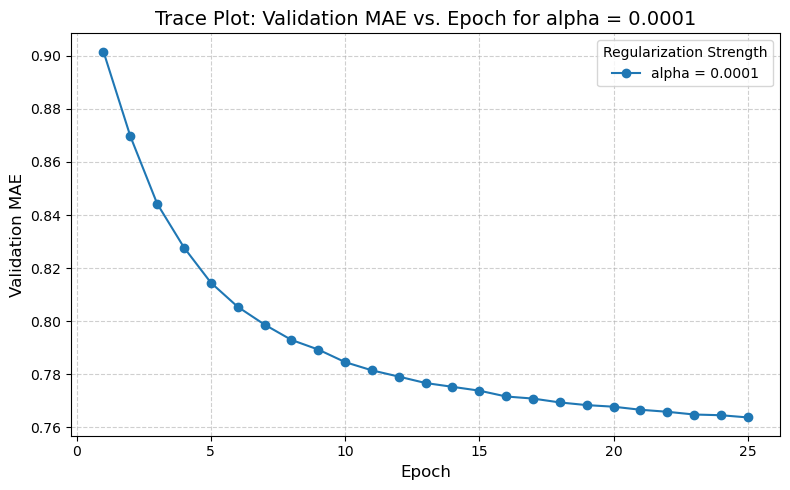

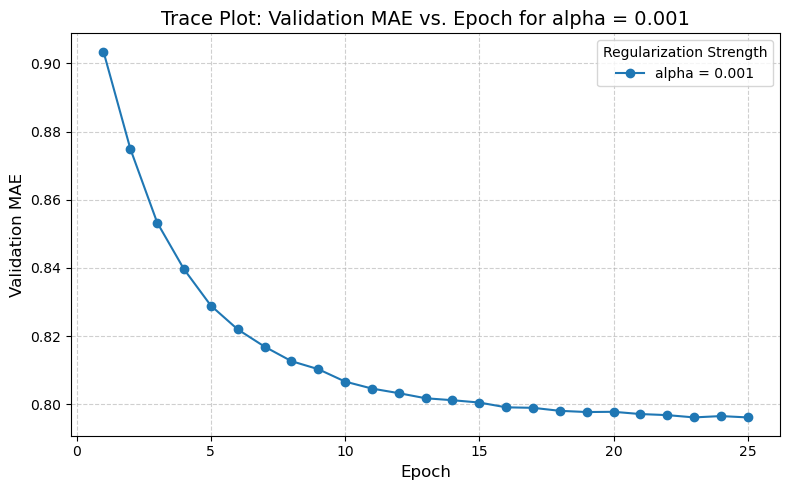

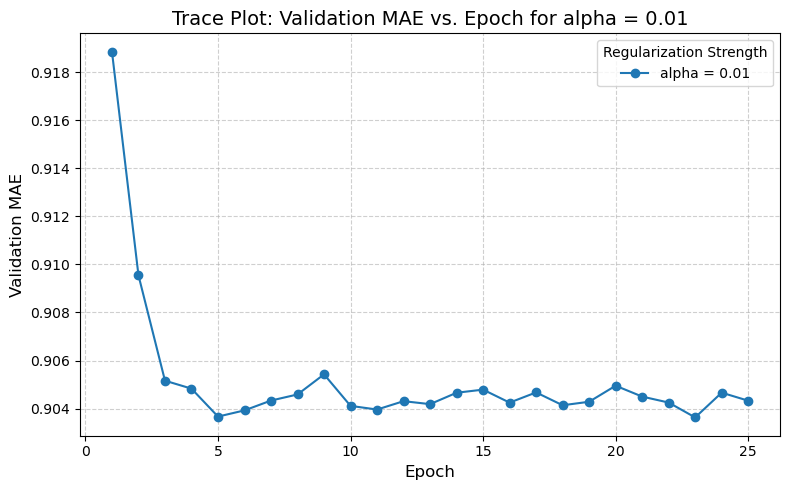

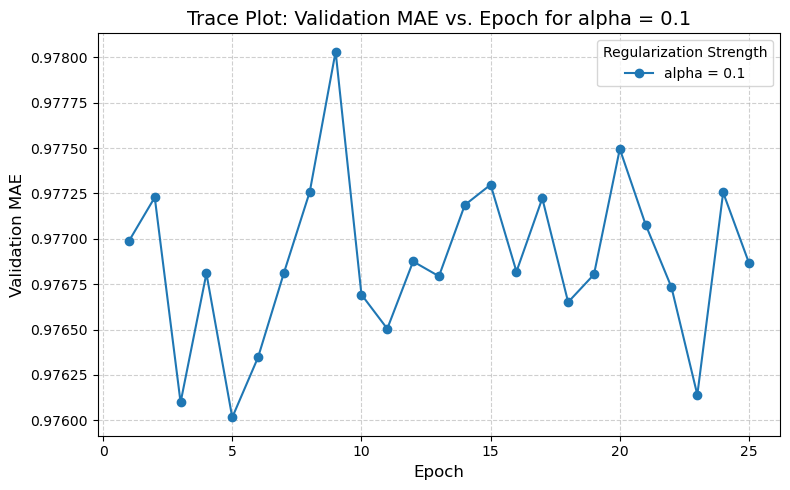

In [34]:
import matplotlib.pyplot as plt

# Organize data by alpha
results_by_alpha = {}
for result in all_results:
    alpha = result["alpha"]
    if alpha not in results_by_alpha:
        results_by_alpha[alpha] = {"epochs": [], "mae_valid": []}
    results_by_alpha[alpha]["epochs"].append(result["epoch"] + 1)  # Convert to 1-based epoch
    results_by_alpha[alpha]["mae_valid"].append(result["mae_valid"])

# Debugging: Check grouped data
print("Data grouped by alpha:")
for alpha, values in results_by_alpha.items():
    print(f"alpha = {alpha}, Number of epochs: {len(values['epochs'])}")

# Create separate plots for each alpha
for alpha, values in results_by_alpha.items():
    plt.figure(figsize=(8, 5))
    plt.plot(values["epochs"], values["mae_valid"], marker='o', label=f"alpha = {alpha}")

    # Customize plot
    plt.title(f"Trace Plot: Validation MAE vs. Epoch for alpha = {alpha}", fontsize=14)
    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel("Validation MAE", fontsize=12)
    plt.legend(title="Regularization Strength", fontsize=10)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()

    # Show plot
    plt.show()

In [33]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
import pandas as pd

# Extract user, item, and ratings from train_tuple, valid_tuple, and test_tuple
user_id_train, item_id_train, y_train = train_tuple
user_id_valid, item_id_valid, y_valid = valid_tuple
user_id_test, item_id_test, y_test = test_tuple

# Create a combined dataset for feature engineering
train_df = pd.DataFrame({'user_id': user_id_train, 'item_id': item_id_train, 'rating': y_train})
valid_df = pd.DataFrame({'user_id': user_id_valid, 'item_id': item_id_valid, 'rating': y_valid})
test_df = pd.DataFrame({'user_id': user_id_test, 'item_id': item_id_test})

# Feature engineering (example: user/item mean ratings)
user_means = train_df.groupby('user_id')['rating'].mean().rename("user_mean_rating")
item_means = train_df.groupby('item_id')['rating'].mean().rename("item_mean_rating")

# Merge these features back into the datasets
train_df = train_df.merge(user_means, on='user_id').merge(item_means, on='item_id')
valid_df = valid_df.merge(user_means, on='user_id', how='left').merge(item_means, on='item_id', how='left')
test_df = test_df.merge(user_means, on='user_id', how='left').merge(item_means, on='item_id', how='left')

# Handle missing values (e.g., for new users/items in validation/test)
valid_df.fillna({'user_mean_rating': train_df['rating'].mean(),
                 'item_mean_rating': train_df['rating'].mean()}, inplace=True)
test_df.fillna({'user_mean_rating': train_df['rating'].mean(),
                'item_mean_rating': train_df['rating'].mean()}, inplace=True)

# Prepare features and labels
X_train = train_df.drop(columns=["rating"])
y_train = train_df["rating"]
X_valid = valid_df.drop(columns=["rating"])
y_valid = valid_df["rating"]
X_test = test_df  # Test set has no "rating" column

# Convert to DMatrix format
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_valid, label=y_valid)
dtest = xgb.DMatrix(X_test)

# Define XGBoost hyperparameters
params = {
    "objective": "reg:squarederror",  # Regression
    "eval_metric": "mae",            # Mean Absolute Error
    "max_depth": 10,                  # Max tree depth
    "eta": 0.1,                      # Learning rate
    "subsample": 0.8,                # Row sampling
    "colsample_bytree": 0.8          # Feature sampling
}

# Train the model
evals = [(dtrain, "train"), (dvalid, "eval")]
xgb_model = xgb.train(params, dtrain, num_boost_round=1000, evals=evals, early_stopping_rounds=50)

# Predict on the test set
y_pred_test = xgb_model.predict(dtest)

# Evaluate test MAE
test_df["rating"] = y_test  # Add back ground truth for comparison
test_mae = mean_absolute_error(test_df["rating"], y_pred_test)
print(f"Test MAE: {test_mae:.4f}")

[0]	train-mae:0.91124	eval-mae:0.91712
[1]	train-mae:0.88906	eval-mae:0.90003
[2]	train-mae:0.86102	eval-mae:0.87672
[3]	train-mae:0.84284	eval-mae:0.86185
[4]	train-mae:0.82617	eval-mae:0.84841
[5]	train-mae:0.80465	eval-mae:0.83140
[6]	train-mae:0.78645	eval-mae:0.81763
[7]	train-mae:0.77512	eval-mae:0.81009
[8]	train-mae:0.76140	eval-mae:0.80005
[9]	train-mae:0.75324	eval-mae:0.79469
[10]	train-mae:0.74612	eval-mae:0.79057
[11]	train-mae:0.73673	eval-mae:0.78448
[12]	train-mae:0.73162	eval-mae:0.78158
[13]	train-mae:0.72690	eval-mae:0.77898
[14]	train-mae:0.72125	eval-mae:0.77601
[15]	train-mae:0.71532	eval-mae:0.77272
[16]	train-mae:0.71022	eval-mae:0.76985
[17]	train-mae:0.70548	eval-mae:0.76772
[18]	train-mae:0.70213	eval-mae:0.76634
[19]	train-mae:0.69893	eval-mae:0.76509
[20]	train-mae:0.69602	eval-mae:0.76436
[21]	train-mae:0.69356	eval-mae:0.76344
[22]	train-mae:0.69052	eval-mae:0.76254
[23]	train-mae:0.68743	eval-mae:0.76166
[24]	train-mae:0.68465	eval-mae:0.76108
[25]	train

In [27]:
import pandas as pd

# Load the masked leaderboard dataset
leaderboard_df = pd.read_csv("data_movie_lens_100k/ratings_masked_leaderboard_set.csv")

# Merge user and item mean ratings into the leaderboard dataset
leaderboard_df = leaderboard_df.merge(user_means, on="user_id", how="left")
leaderboard_df = leaderboard_df.merge(item_means, on="item_id", how="left")

# Fill missing values
leaderboard_df.fillna({
    "user_mean_rating": train_df["rating"].mean(),
    "item_mean_rating": train_df["rating"].mean()
}, inplace=True)

# Drop unnecessary columns (e.g., "rating") to prepare features
X_leaderboard = leaderboard_df.drop(columns=["rating"])


# Convert to DMatrix
dleaderboard = xgb.DMatrix(X_leaderboard)

In [28]:
# Predict ratings
y_pred_leaderboard = xgb_model.predict(dleaderboard)

In [29]:
# Save predictions to a text file
with open("predicted_ratings_leaderboard.txt", "w") as f:
    for pred in y_pred_leaderboard:
        f.write(f"{pred}\n")

print("Predictions saved to predicted_ratings_leaderboard.txt")

Predictions saved to predicted_ratings_leaderboard.txt


In [30]:
import numpy as np

predictions = np.loadtxt("predicted_ratings_leaderboard.txt")
print(f"Loaded predictions shape: {predictions.shape}")  # Should print (10000,)

Loaded predictions shape: (10000,)
